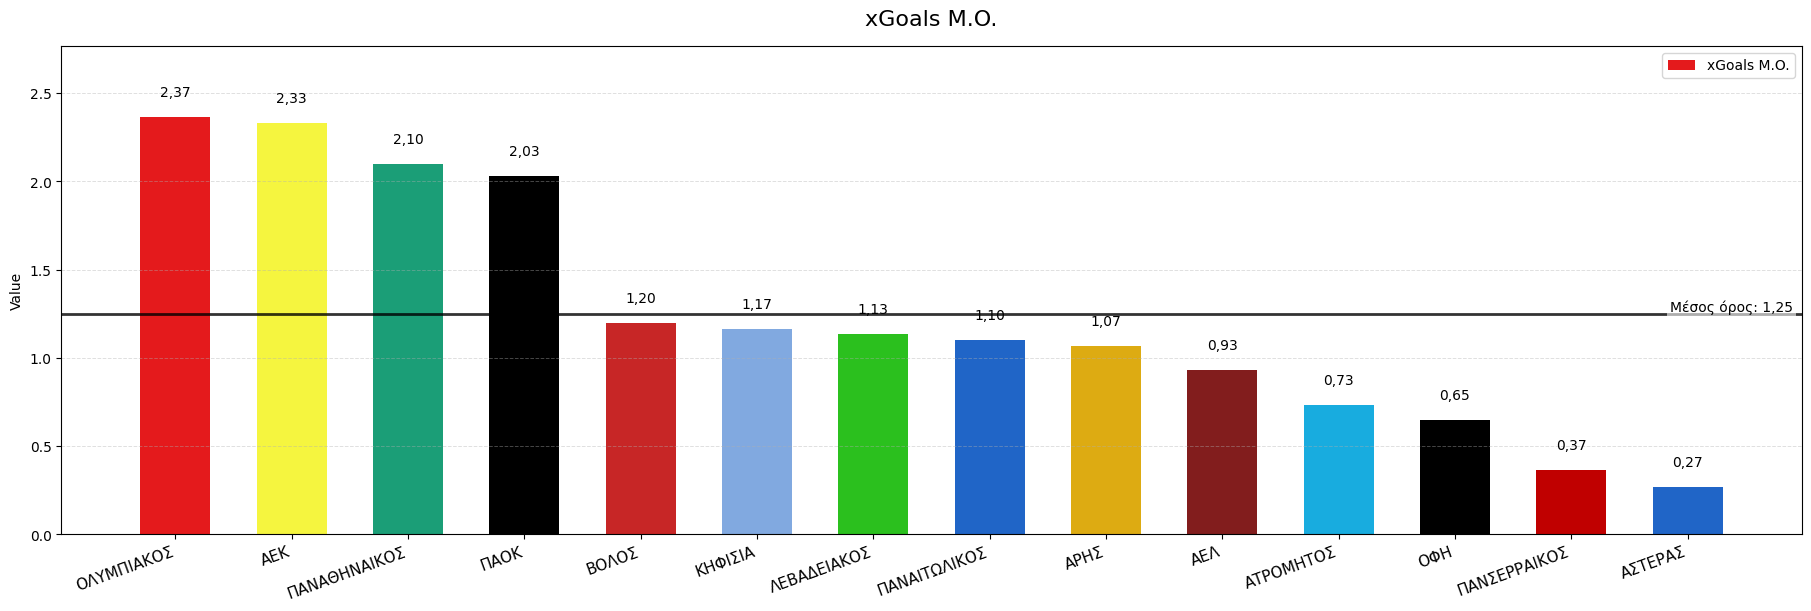

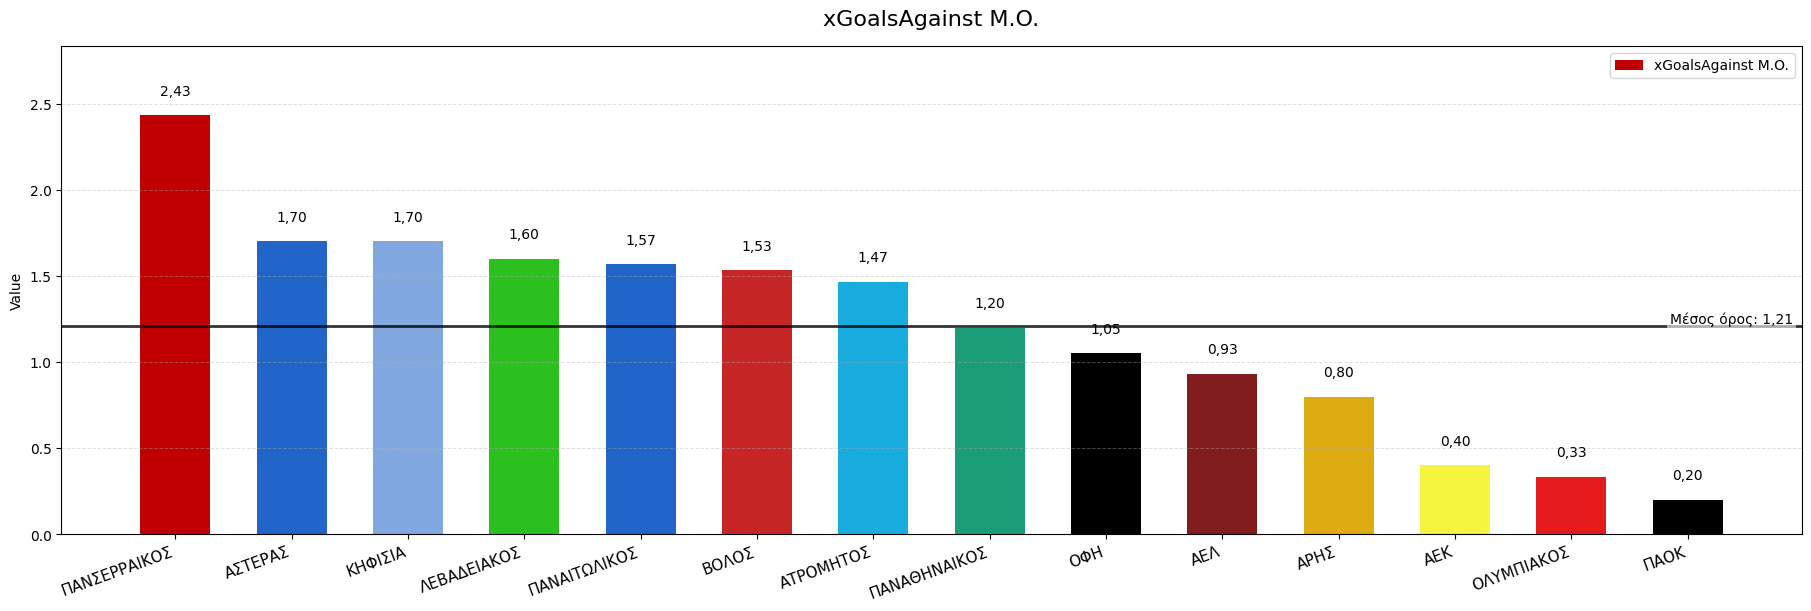

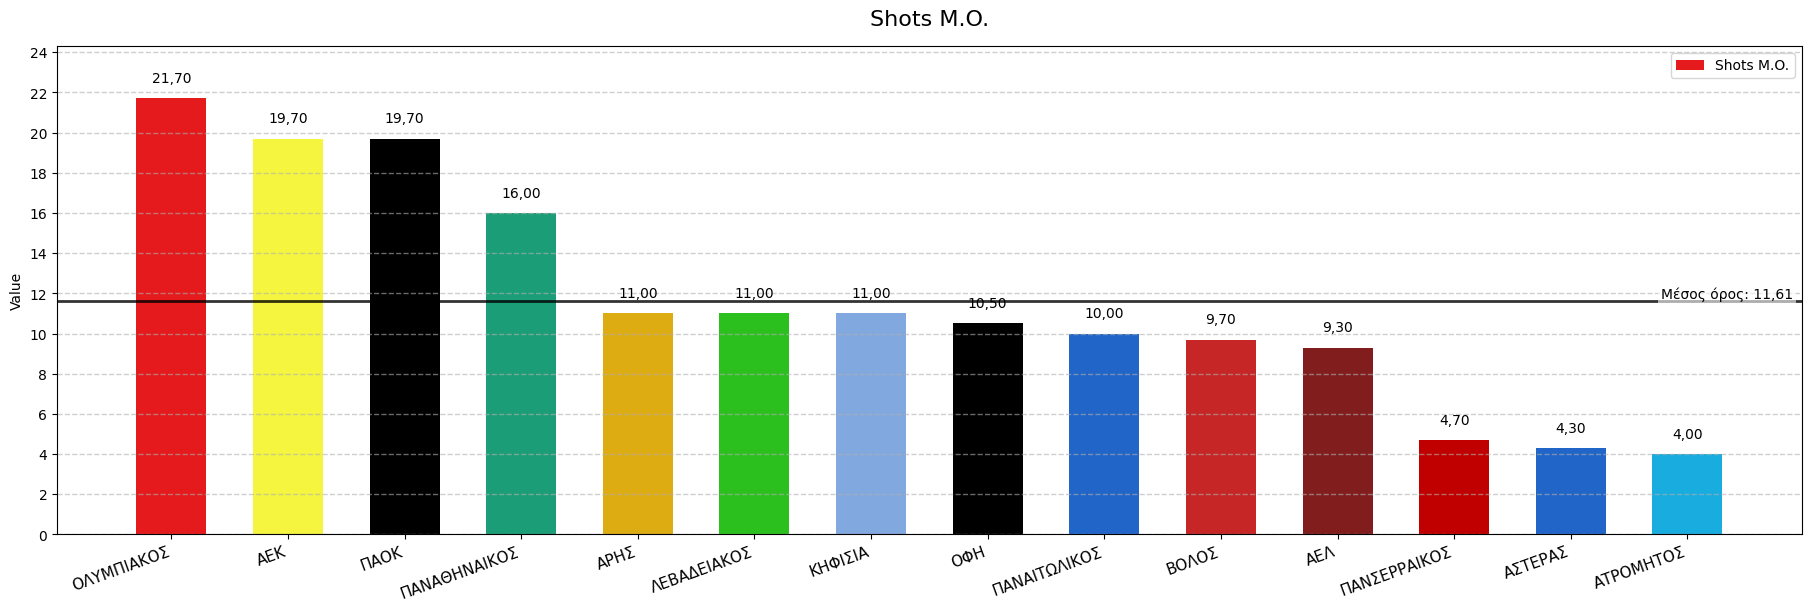

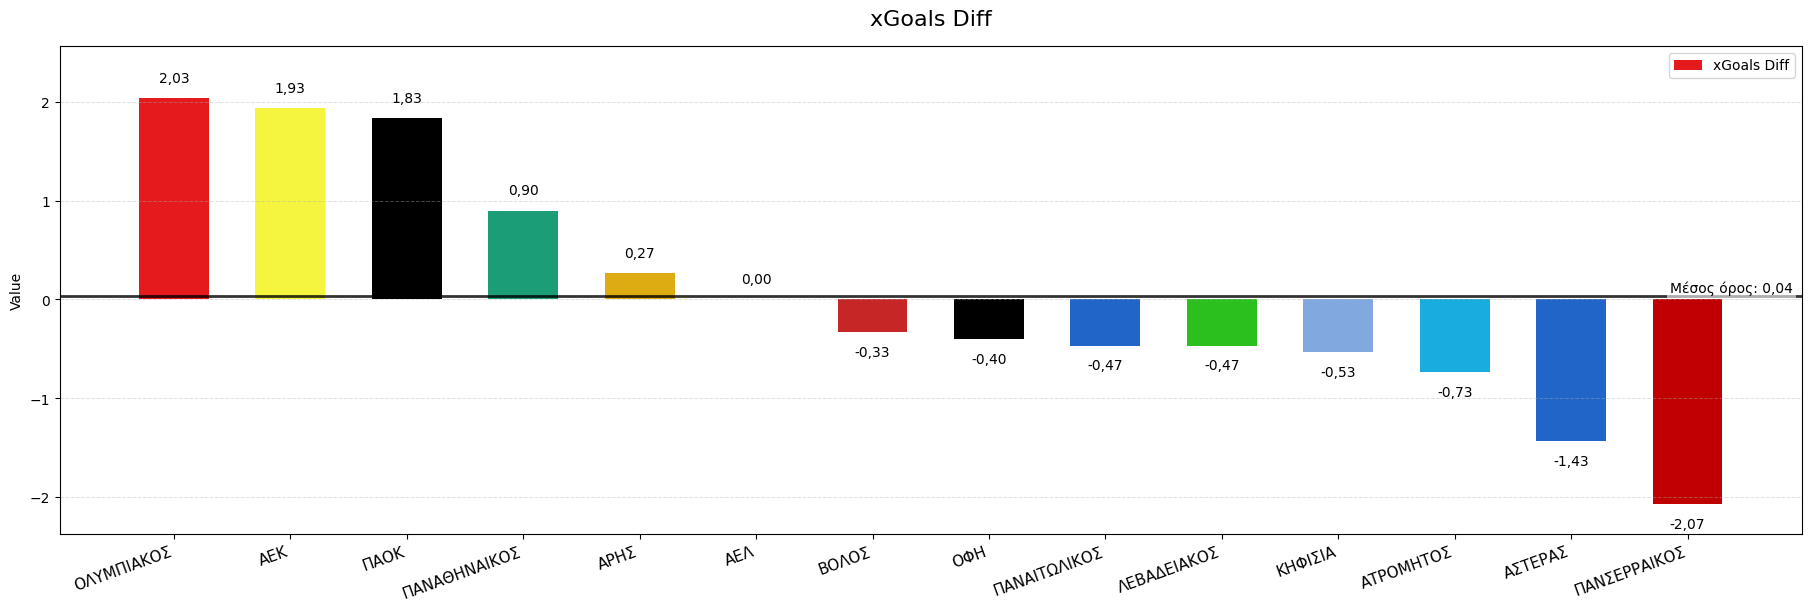

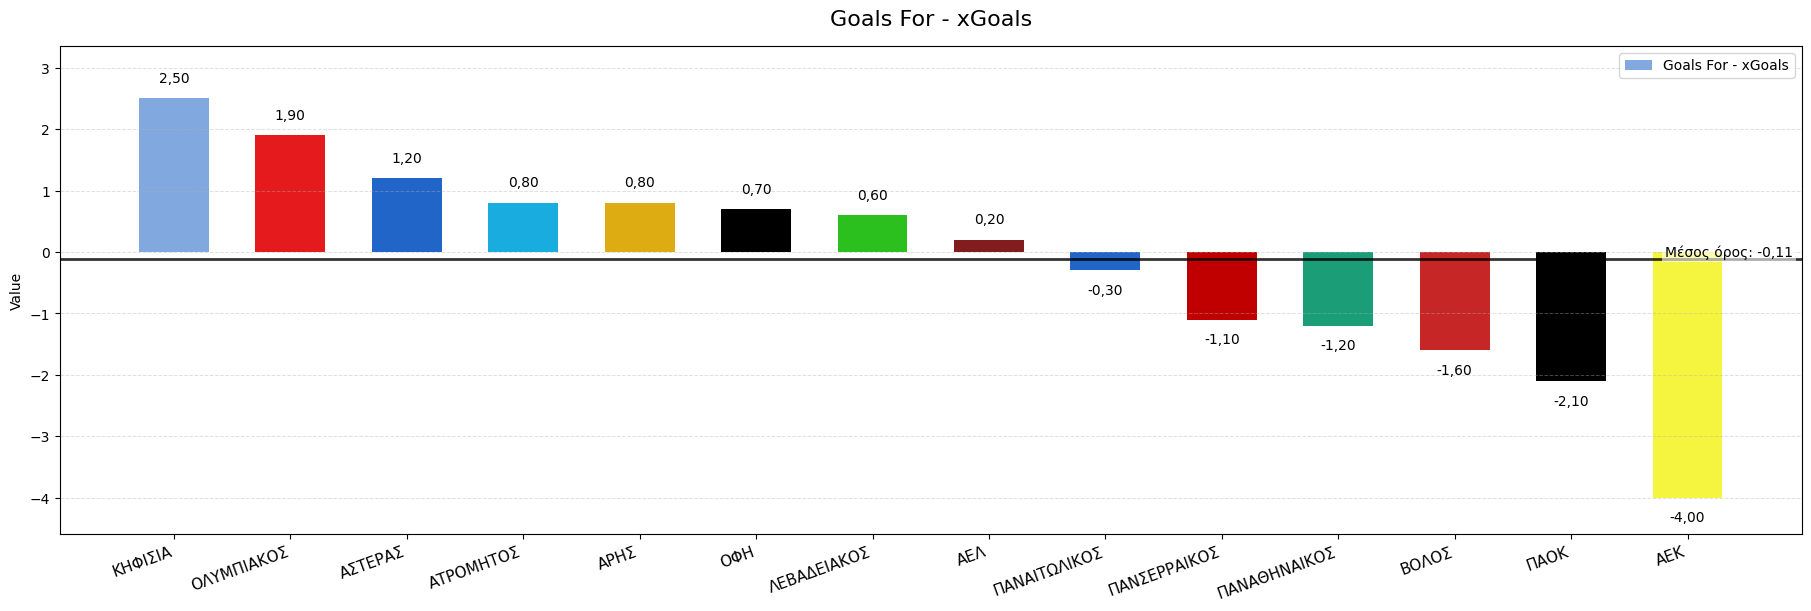

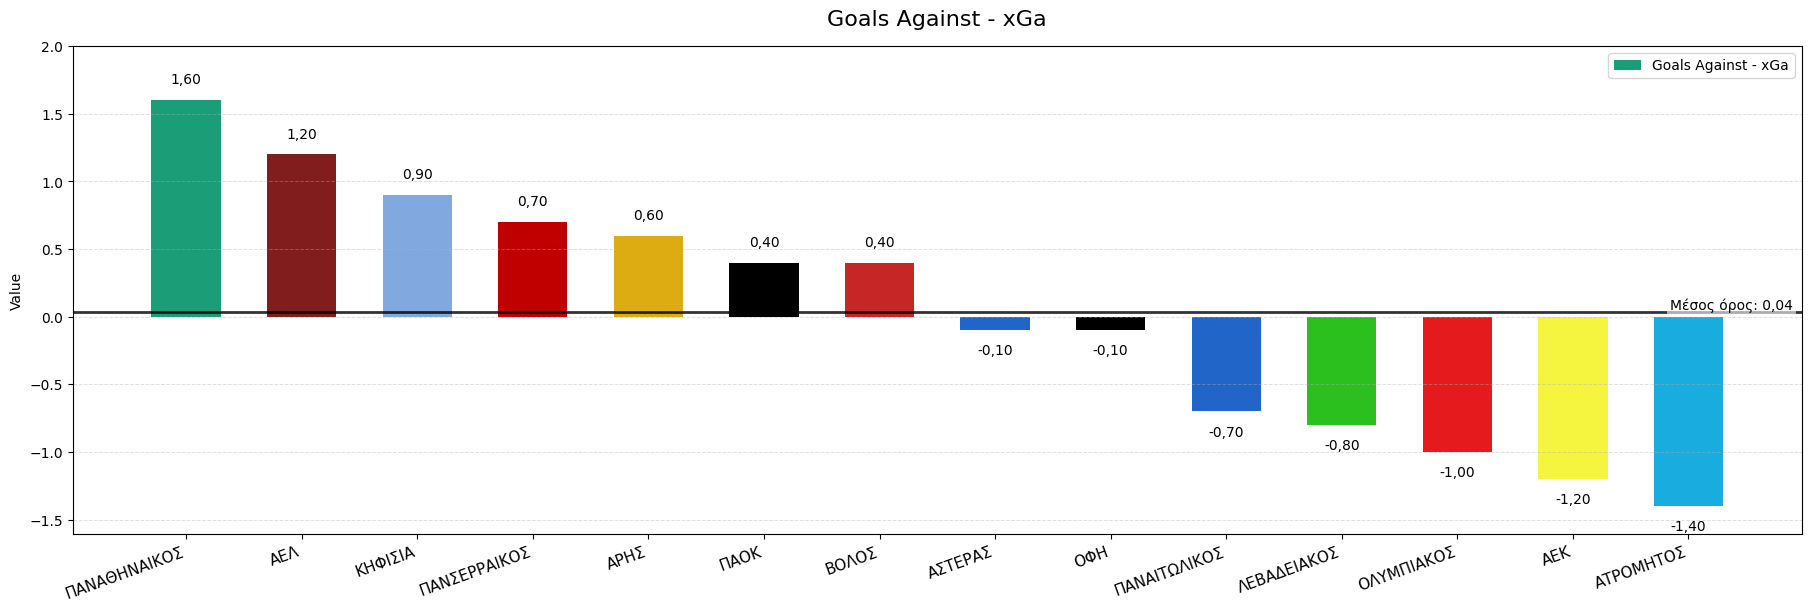

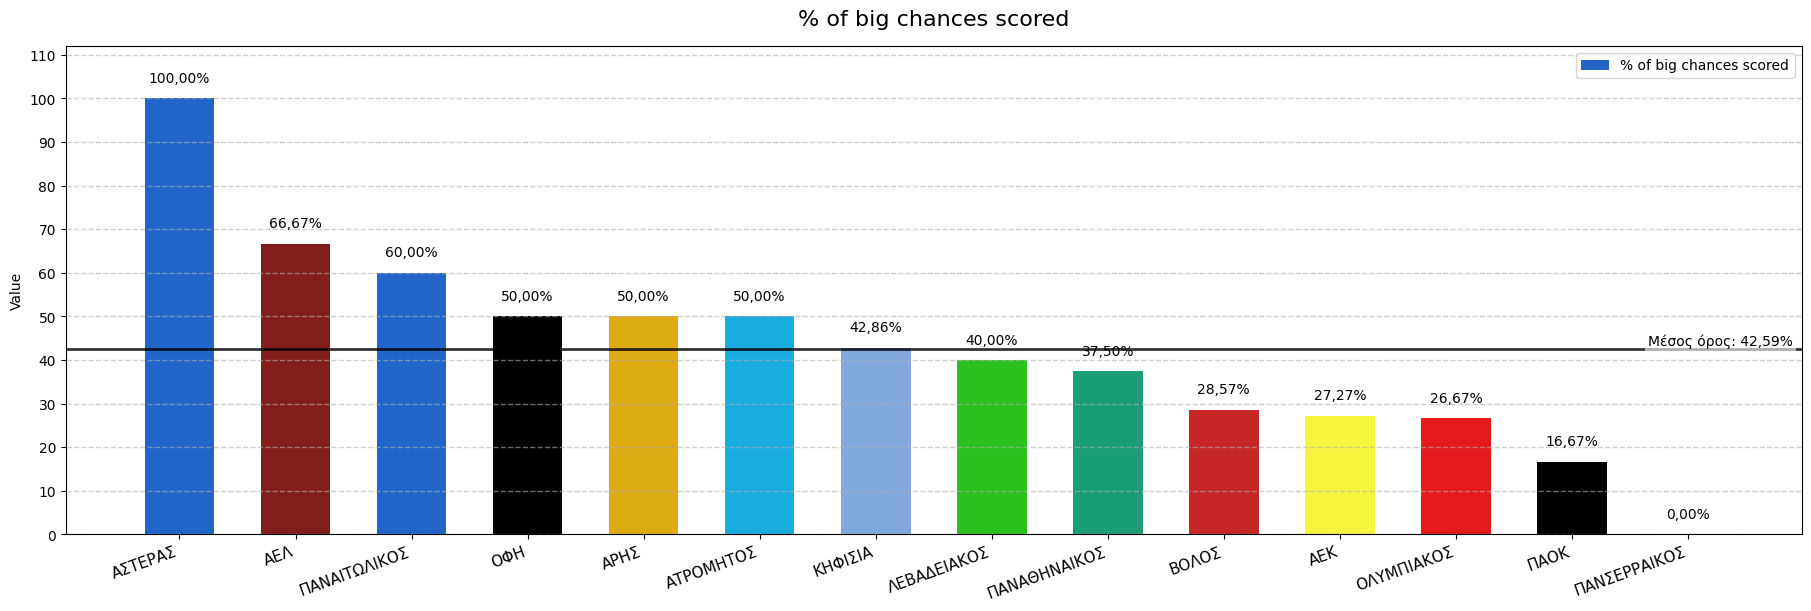

In [1]:
# === Live plotting from your Google Sheet with per-team colors + dashed y-gridlines ===
CSV_URL = "https://docs.google.com/spreadsheets/d/1IAOdPgYr0OHCyBGNfwHgFZSwS8BgEWgi3kDRCBxmAwQ/export?format=csv&gid=0"

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

# ---------- Load ----------
df = pd.read_csv(CSV_URL)

# If headers are "Unnamed", promote first row to header (so Greek team names appear)
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

df = promote_first_row_to_header(df)

metric_col = df.columns[0]
df[metric_col] = df[metric_col].astype(str).str.strip()

# Keep a copy to read colors (as strings)
raw_df = df.copy()

# Convert numeric cells to float (remove %, normalize commas)
num_df = df.copy()
for c in num_df.columns[1:]:
    col = (num_df[c].astype(str)
           .str.replace('%', '', regex=False)
           .str.replace(',', '.', regex=False))
    num_df[c] = pd.to_numeric(col, errors='coerce')

teams = list(num_df.columns[1:])

# ---------- Colors ----------
# Option A: read from a row called "Colors" (first col exactly "Colors"), e.g. cells contain "#1f77b4"
color_row_mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
sheet_colors = None
if color_row_mask.any():
    sheet_colors = raw_df.loc[color_row_mask].iloc[0, 1:]
    # Simple validation: require values to look like hex colors
    if not all(isinstance(x, str) and x.strip().startswith("#") for x in sheet_colors):
        sheet_colors = None

# Option B: define a dict here (edit to match your sheet’s header text EXACTLY)
color_map = {
    # Examples (put your own colors here if you don't want a Colors row in the sheet):
    "ΟΛΥΜΠΙΑΚΟΣ": "#e41a1c",
    "ΠΑΝΑΘΗΝΑΙΚΟΣ": "#1b9e77",
    "ΑΕΚ": "#f5f53f",
    "ΠΑΟΚ": "#000000",
    "ΑΡΗΣ": "#ddab12",
    "ΑΤΡΟΜΗΤΟΣ": "#18acdf",
    "ΛΕΒΑΔΕΙΑΚΟΣ": "#2bc01e",
    "ΟΦΗ": "#000000",
    "ΑΣΤΕΡΑΣ": "#2065c7",
    "ΠΑΝΑΙΤΩΛΙΚΟΣ": "#2065c7",
    "ΚΗΦΙΣΙΑ": "#81a9e0",
    "ΑΕΛ": "#821D1D",
    "ΠΑΝΣΕΡΡΑΙΚΟΣ": "#c00000",
    "ΒΟΛΟΣ": "#c72626",
}

def get_bar_colors():
    if sheet_colors is not None:
        # Use the Colors row from the sheet, fallback to dict if a team missing
        return [str(sheet_colors.get(t, color_map.get(t, "#4e79a7"))) for t in teams]
    else:
        # Use dict only
        return [color_map.get(t, "#4e79a7") for t in teams]

BAR_COLORS = get_bar_colors()

# ---------- Helpers ----------
def get_metric_series(name: str) -> pd.Series:
    target = name.strip().casefold()
    exact = num_df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return num_df.loc[exact].iloc[0, 1:]
    contains = num_df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return num_df.loc[contains].iloc[0, 1:]
    available = "\n - " + "\n - ".join(num_df[metric_col].astype(str))
    raise ValueError(f"Metric '{name}' not found.\nAvailable metrics include:{available}")

def team_color(team_name: str):
    if 'sheet_colors' in globals() and sheet_colors is not None and team_name in sheet_colors:
        val = str(sheet_colors[team_name])
        return val if val.startswith("#") else color_map.get(team_name, "#4e79a7")
    return color_map.get(team_name, "#4e79a7")

def plot_metric_bar(metric_name: str, assume_percent=False):
    # values (DESC sort)
    s = get_metric_series(metric_name).astype(float).sort_values(ascending=False)

    # fig size
    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    # colors follow sorted order
    colors = [team_color(t) for t in s.index]

    # bars
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=metric_name)

    ax.set_title(metric_name, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # y limits + headroom
    ymin = min(0, (np.nanmin(s.values) - abs(np.nanmin(s.values))*0.15 if np.isfinite(np.nanmin(s.values)) else 0))
    y_range = max(1e-6, float(np.nanmax(s.values) - ymin))
    upper_pad = max(0.12 * y_range, 0.4)
    ax.set_ylim(bottom=ymin, top=float(np.nanmax(s.values)) + upper_pad)

    # grid rules
    name_ci = metric_name.strip().casefold()
    if name_ci == "shots m.o.":
        ax.yaxis.set_major_locator(MultipleLocator(2))     # only for Shots M.O.
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))    # 0%,10%,20%...
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # ---- MEAN LINE (horizontal) ----
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    # put the label at the right edge; x in axes-fraction, y in data coords
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),  # x in [0..1], y in data units
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # value labels (2 decimals; negatives below the bar)
    label_offset = max(0.03 * y_range, 0.1)
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val):
            continue
        label = f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        if val >= 0:
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_height() + label_offset,
                    label, ha='center', va='bottom', fontsize=10, clip_on=False)
        else:
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_height() - label_offset,
                    label, ha='center', va='top', fontsize=10, clip_on=False)

    plt.show()

# ---------- Your 7 plots ----------
metrics_to_plot = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),  # percentage plot gets 5% grid spacing
]

for name, is_percent in metrics_to_plot:
    try:
        plot_metric_bar(name, assume_percent=is_percent)
    except ValueError as e:
        print(e)


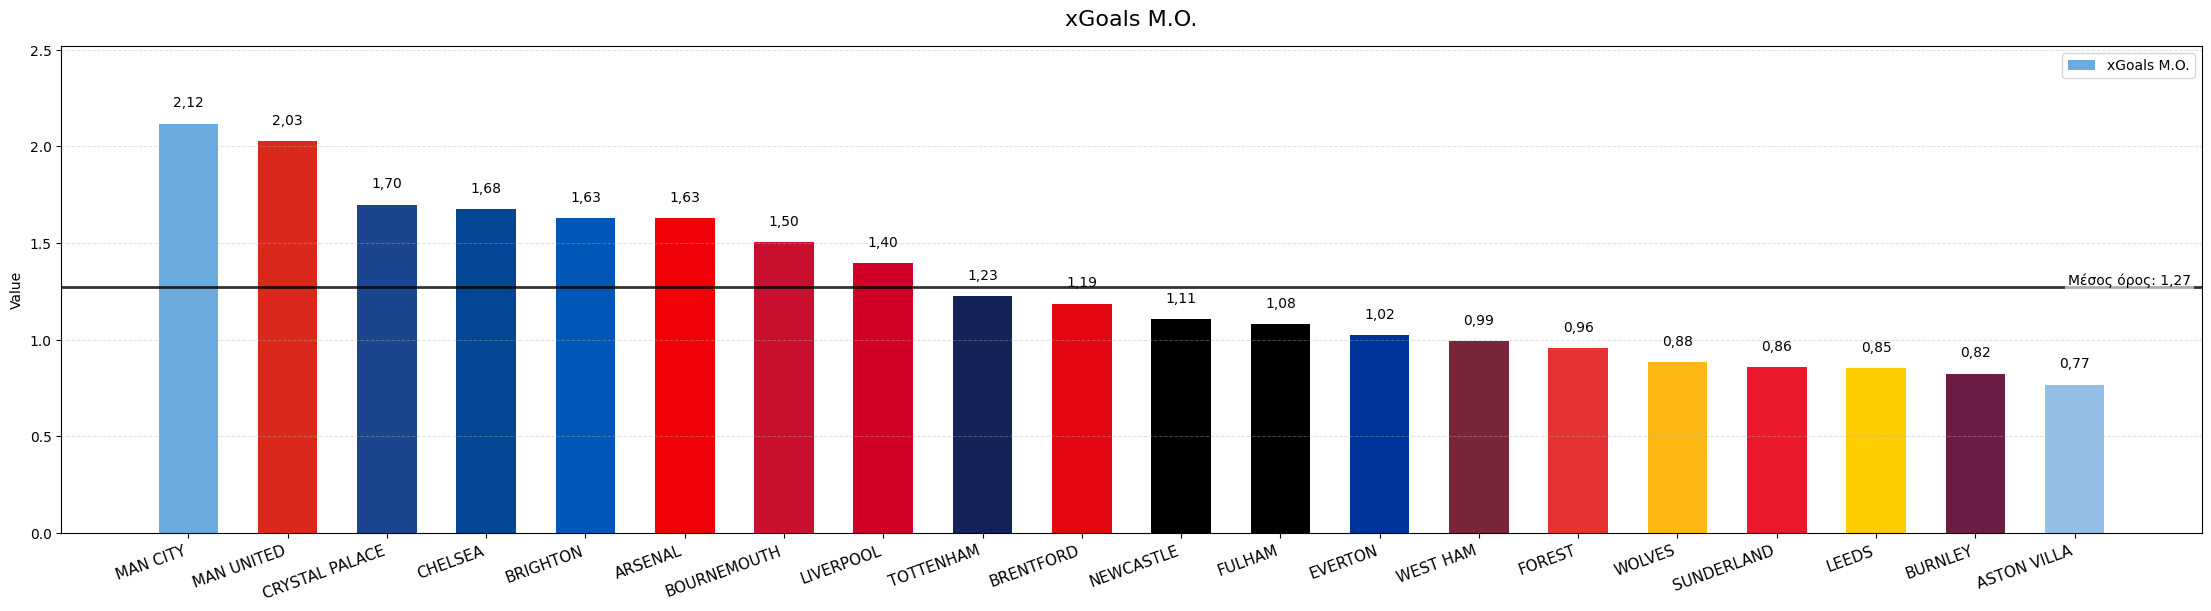

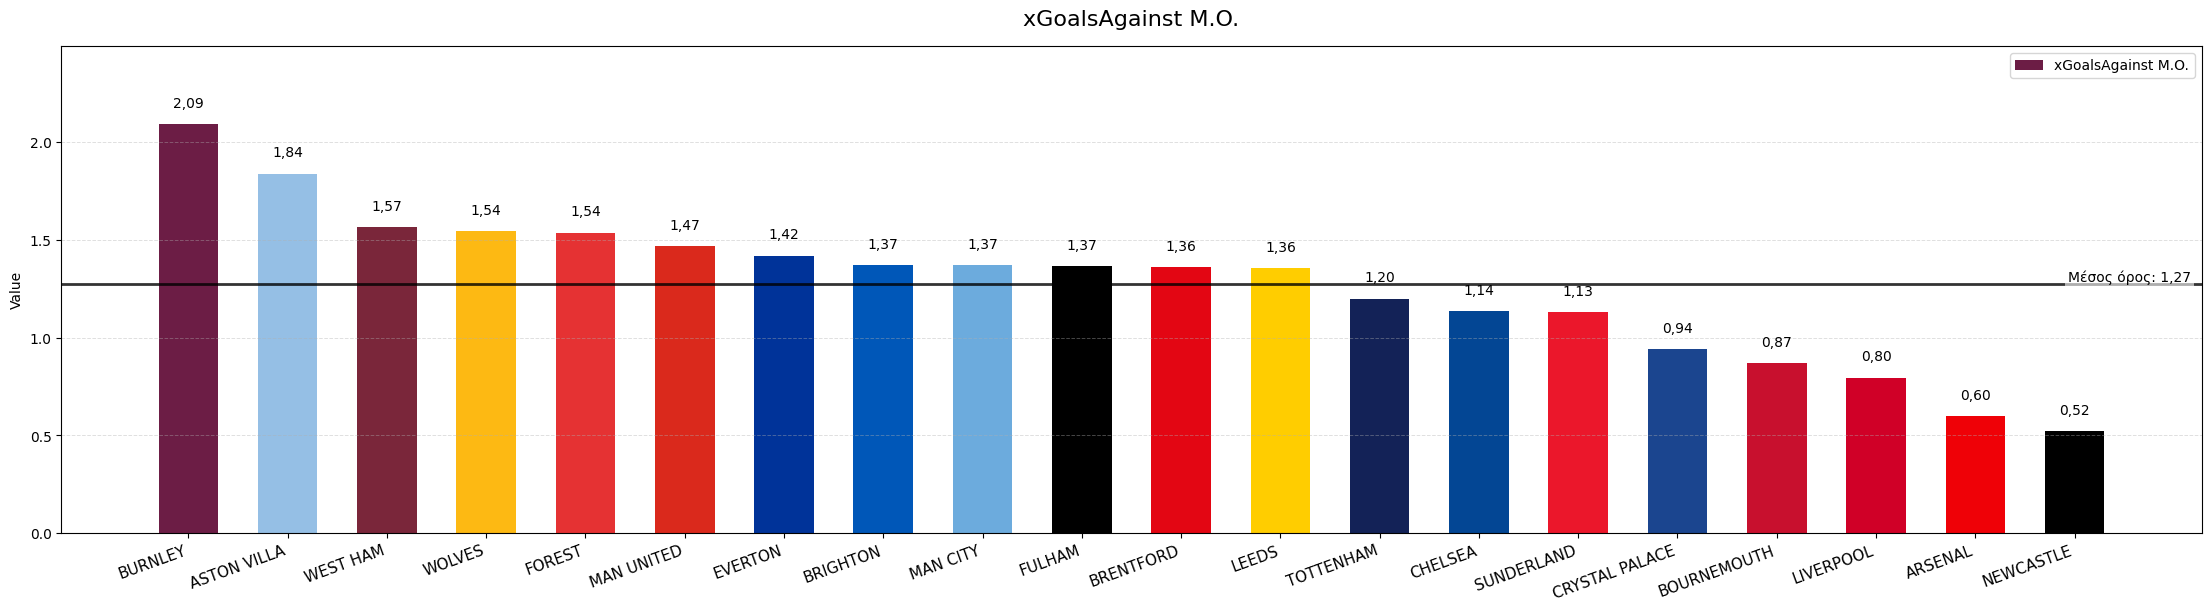

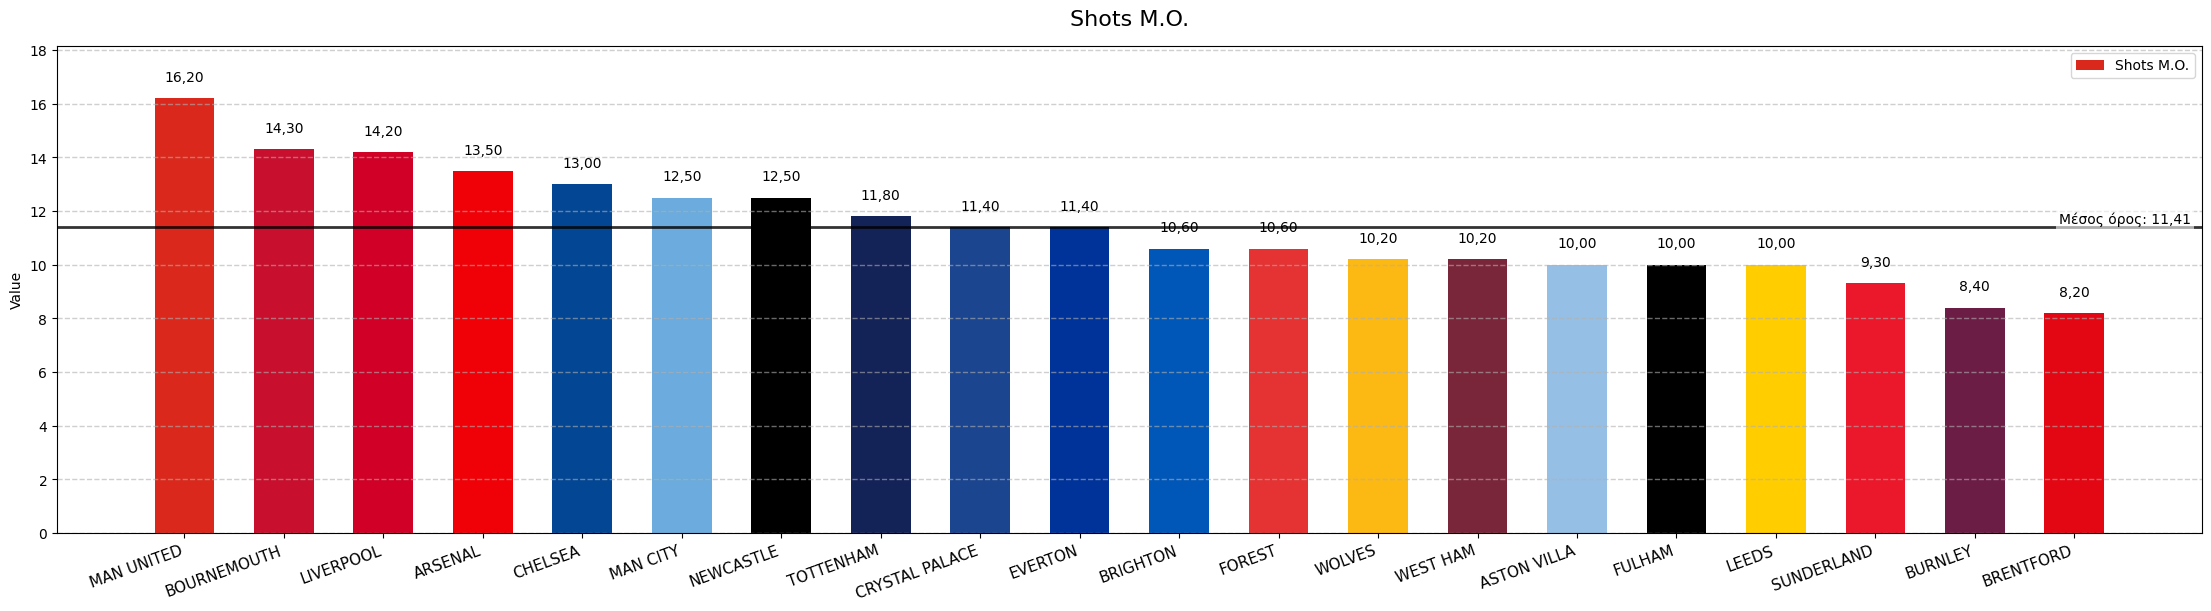

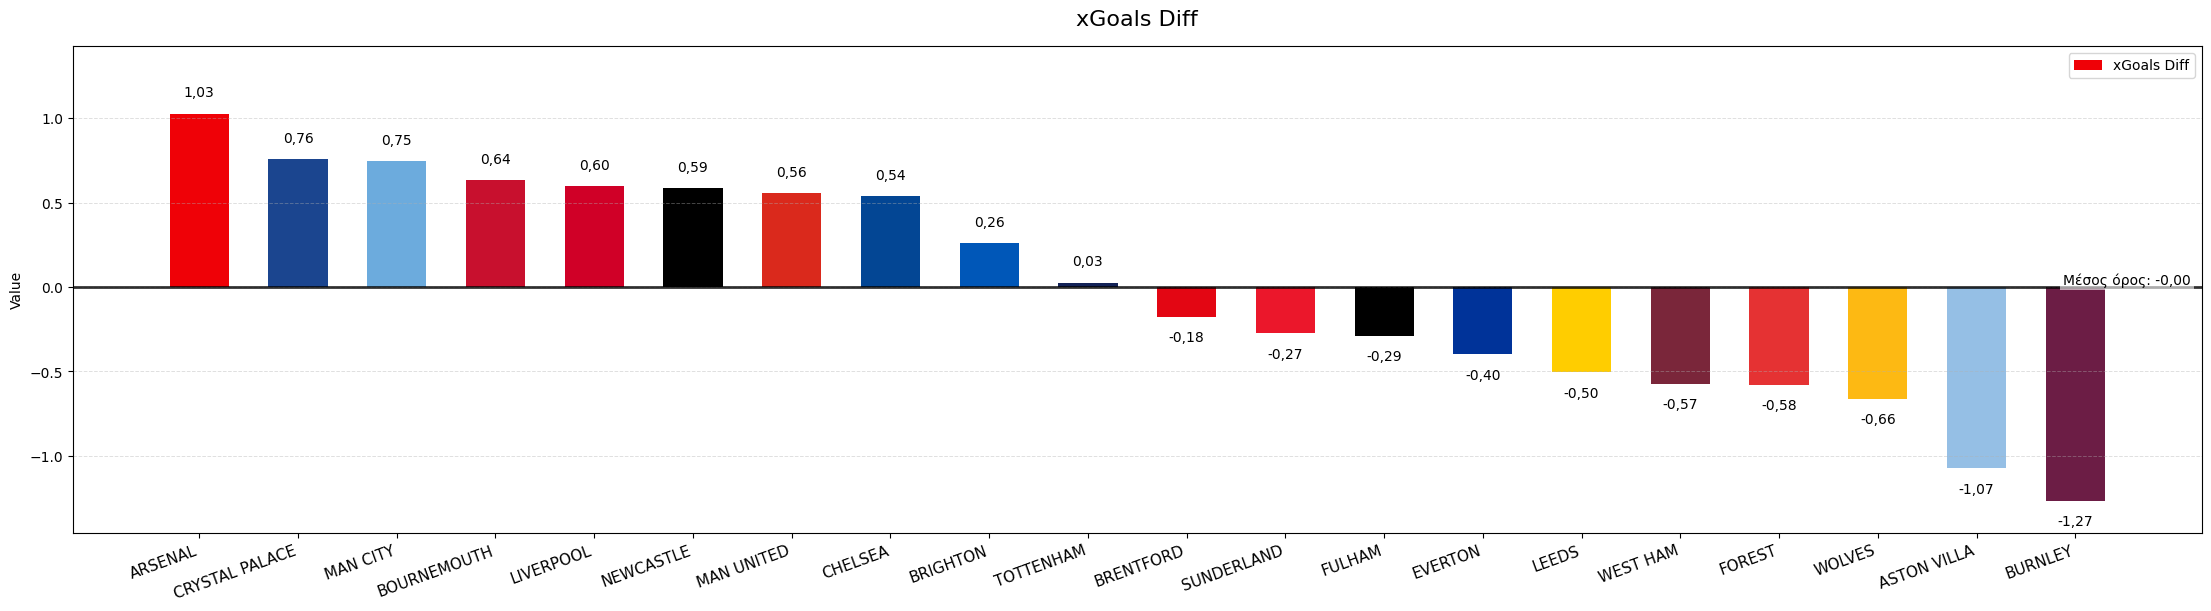

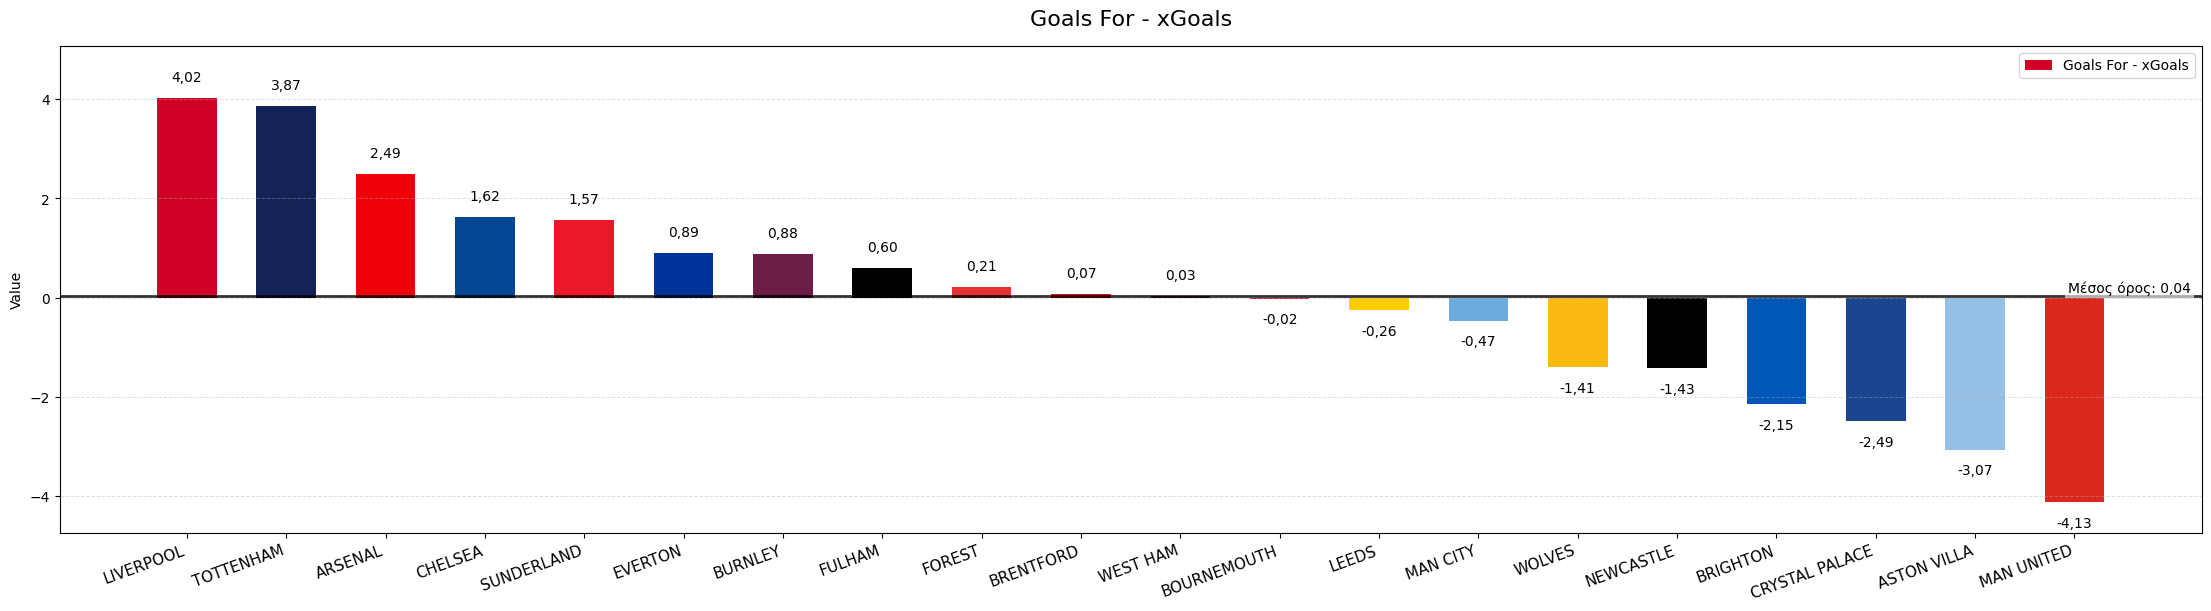

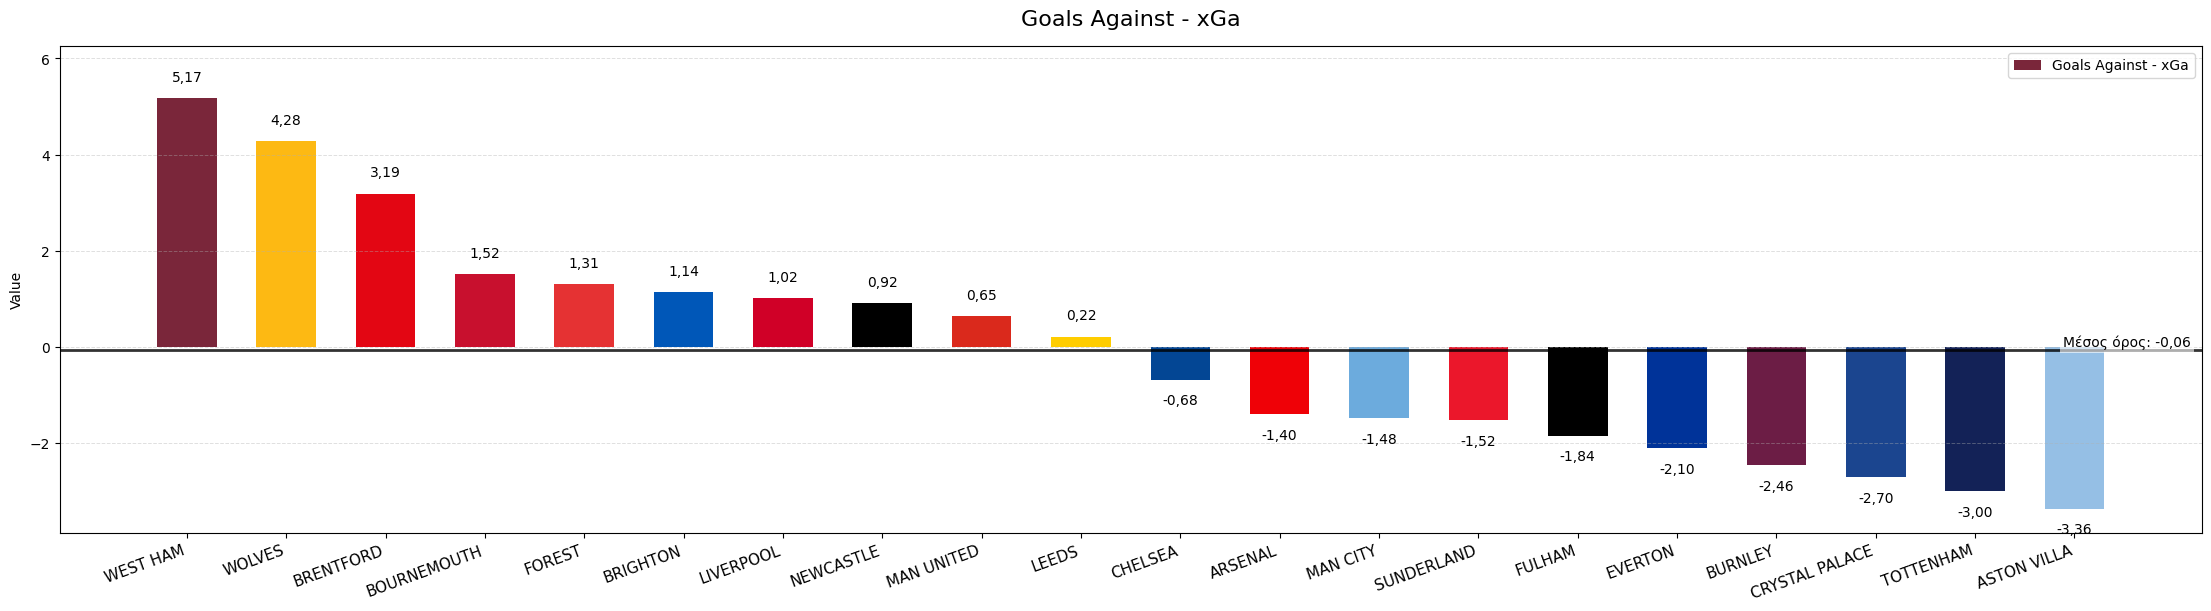

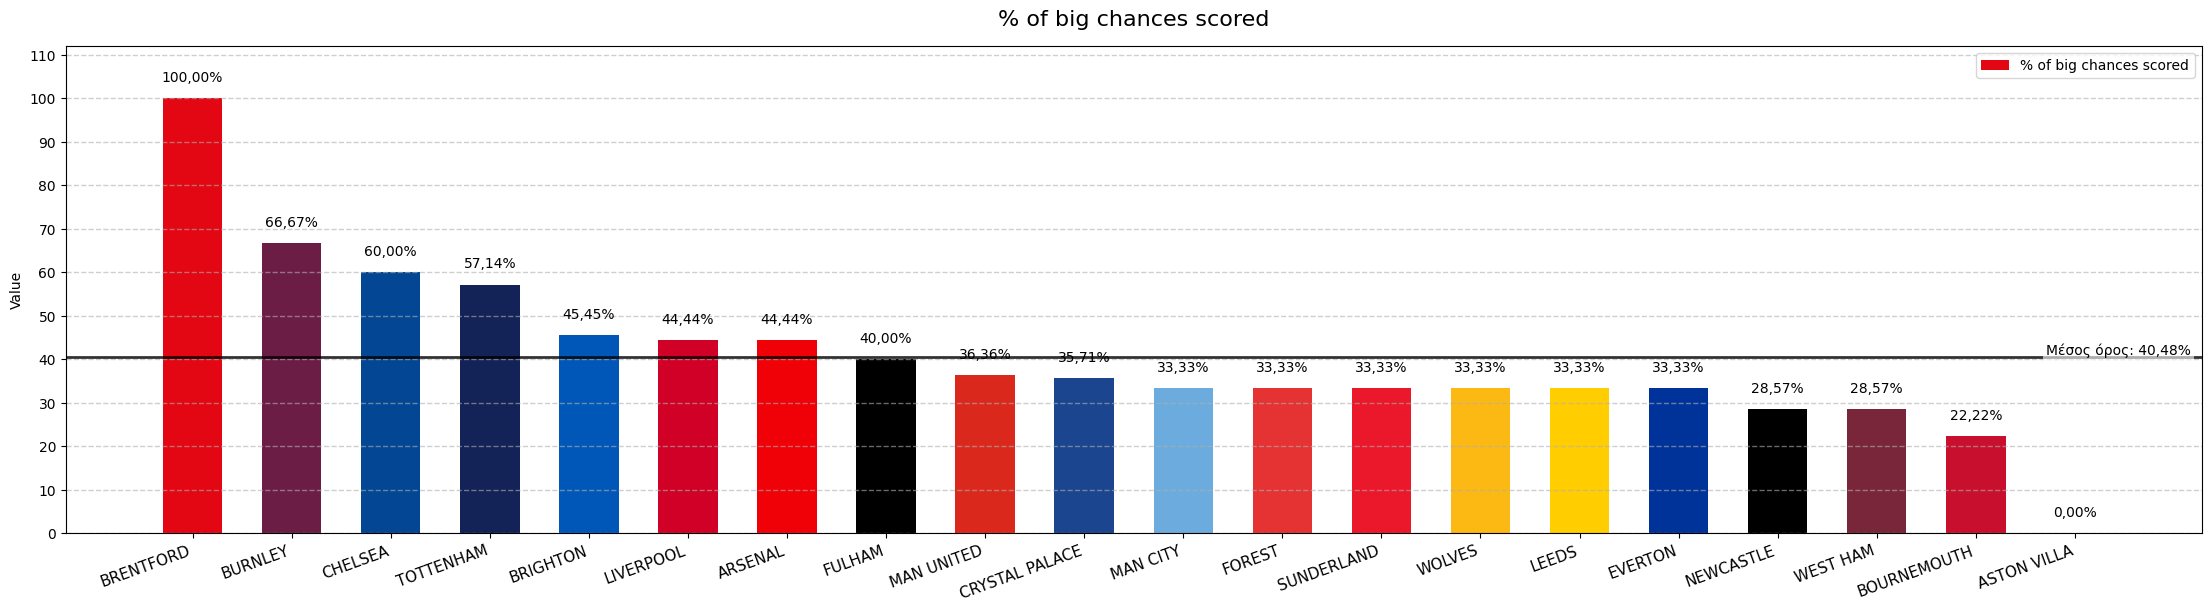

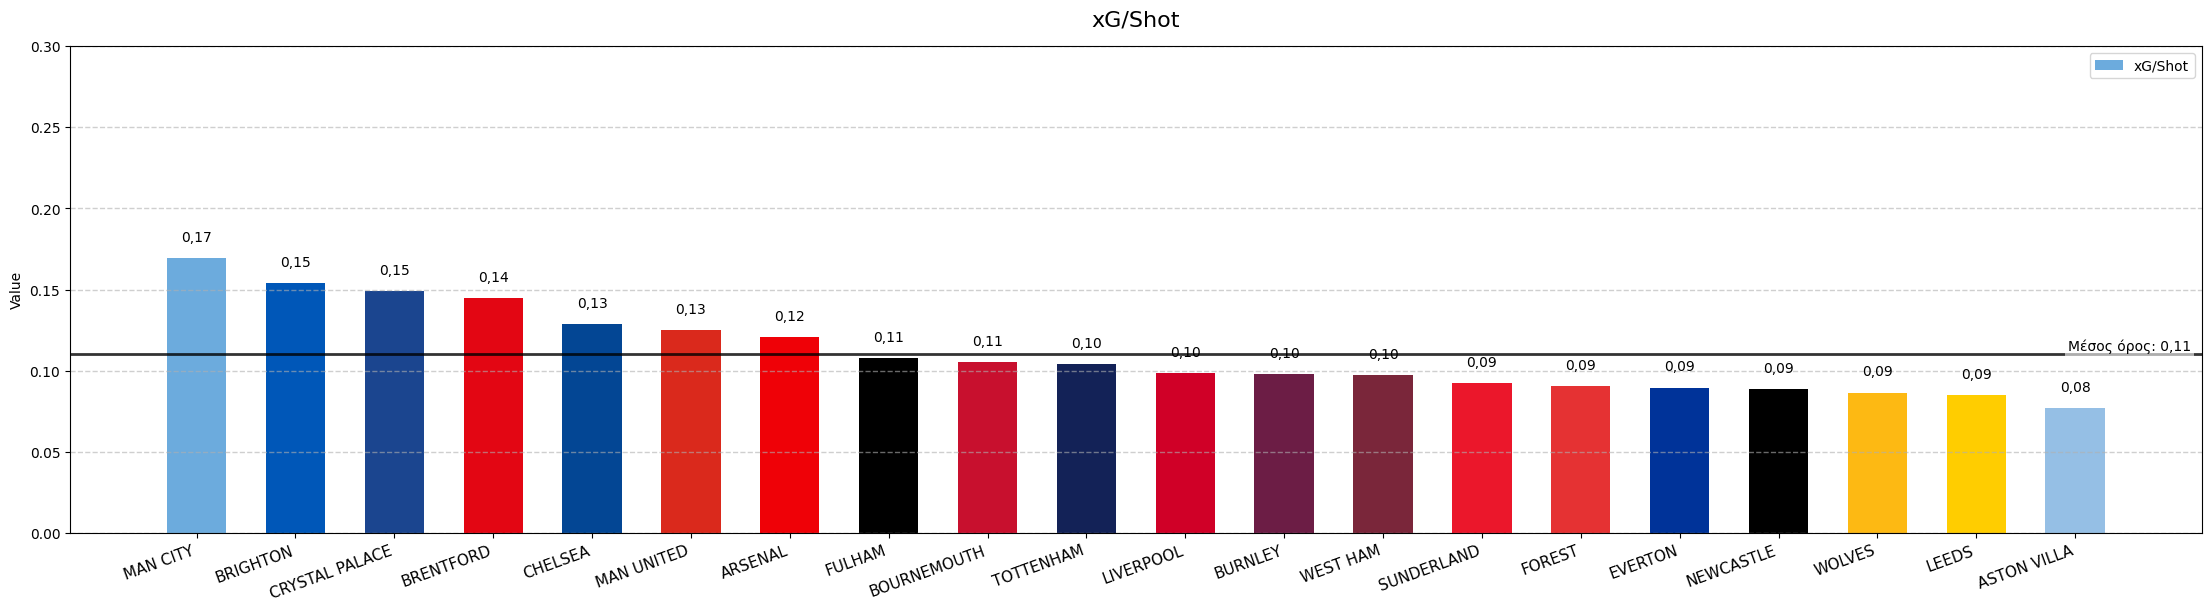

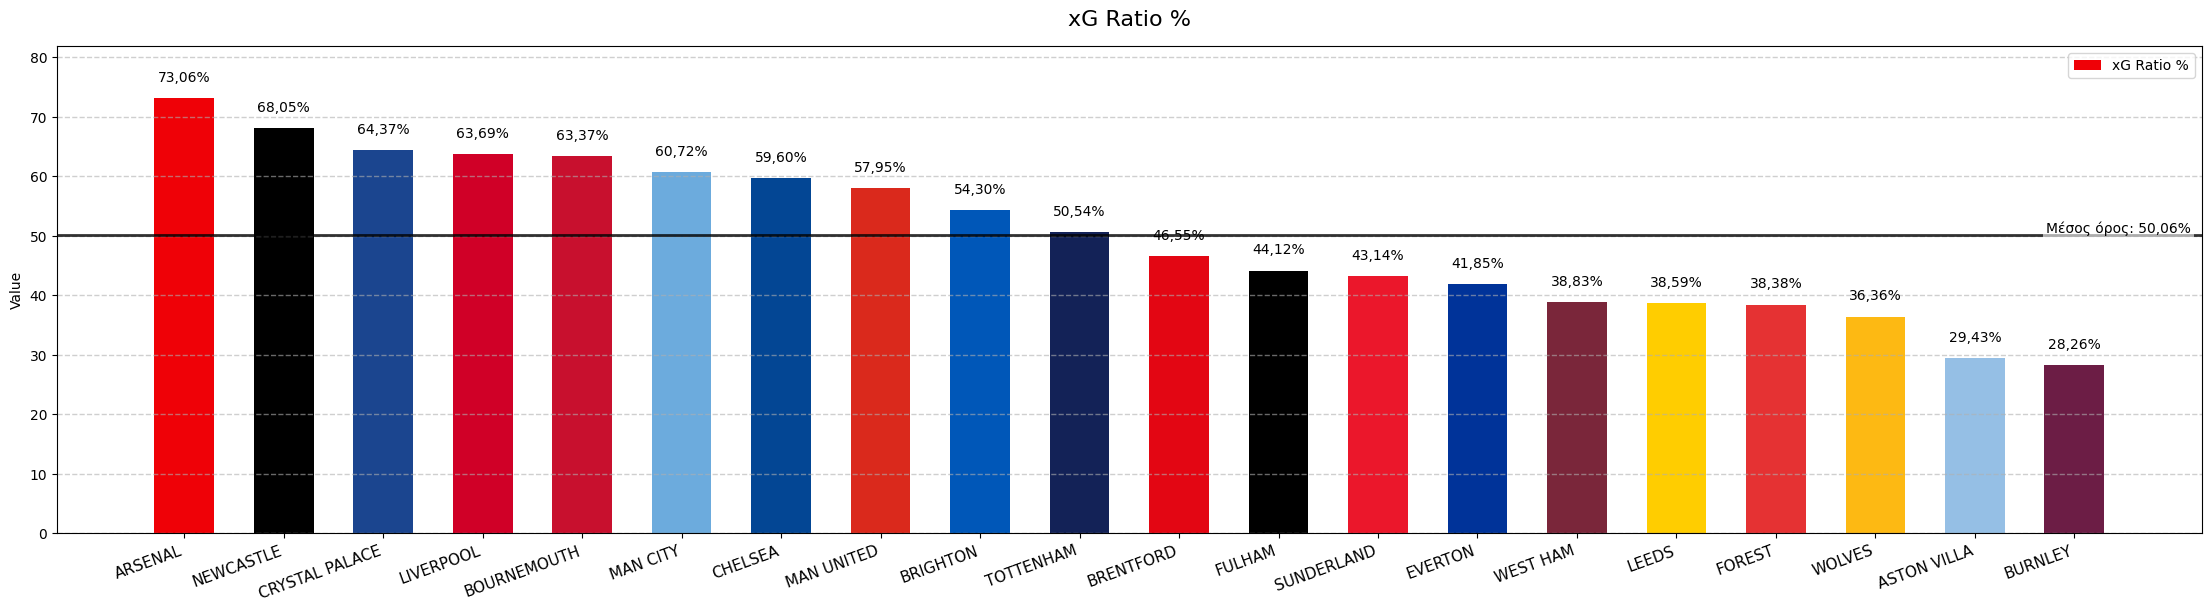

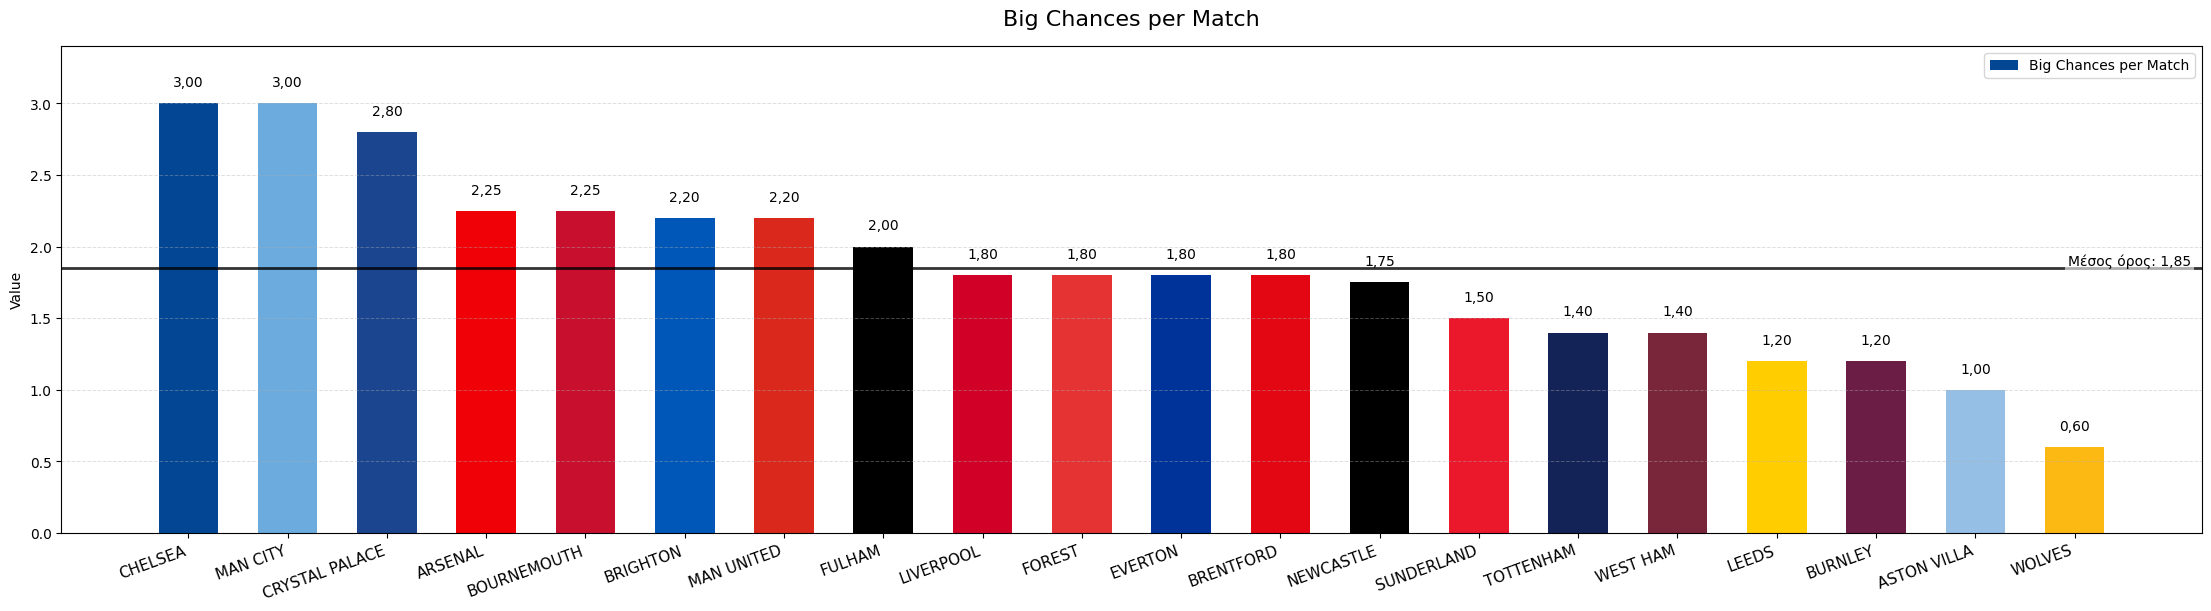

In [2]:
# ==== LIVE Google Sheet → EPL plots (1 chart per figure + xG Ratio % + Big Chances/Match) ====
CSV_URL_EPL = "https://docs.google.com/spreadsheets/d/1fdRzFR9hqhBMDrd9XRFpi_Pl-JaG8Yz6ghPvpQ51rsk/export?format=csv&gid=0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.errors import ParserError

# ---------- Helpers to load & clean ----------
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

def prepare_sheet(csv_url):
    # Robust parse: comma, then semicolon, then sniff
    tried = []
    for kwargs in ({},
                   {"sep": ";"},
                   {"sep": None, "engine": "python"}):
        try:
            df = pd.read_csv(csv_url, **kwargs)
            break
        except ParserError as e:
            tried.append((kwargs, str(e)))
            df = None
    if df is None:
        raise RuntimeError(f"Could not parse the sheet. Tried: {tried}")

    df = promote_first_row_to_header(df)
    raw_df = df.copy()

    metric_col = df.columns[0]
    df[metric_col] = df[metric_col].astype(str).str.strip()

    # Convert numerics (strip %, normalize comma→dot)
    num_df = df.copy()
    for c in num_df.columns[1:]:
        col = (num_df[c].astype('string')
               .str.replace('%', '', regex=False)
               .str.replace('\u00a0', ' ', regex=False)
               .str.replace(',', '.', regex=False))
        num_df[c] = pd.to_numeric(col, errors='coerce')

    # Optional 'Colors' row
    sheet_colors = None
    mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
    if mask.any():
        row = raw_df.loc[mask].iloc[0, 1:]
        if all(isinstance(x, str) and x.strip().startswith("#") for x in row):
            sheet_colors = row

    return {
        "num_df": num_df,
        "raw_df": raw_df,
        "metric_col": metric_col,
        "teams": list(num_df.columns[1:]),
        "sheet_colors": sheet_colors,
    }

def get_metric_series(ctx, name: str) -> pd.Series:
    df = ctx["num_df"]; metric_col = ctx["metric_col"]
    target = name.strip().casefold()
    exact = df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return df.loc[exact].iloc[0, 1:]
    contains = df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return df.loc[contains].iloc[0, 1:]
    raise ValueError("Metric not found. Available:\n - " + "\n - ".join(df[metric_col].astype(str)))

# ---------- EPL team colors (fallback if no 'Colors' row) ----------
EPL_COLORS = {
    "LIVERPOOL": "#d00027",
    "ARSENAL": "#ef0107",
    "MAN CITY": "#6cabdd",
    "CHELSEA": "#034694",
    "NEWCASTLE": "#000000",
    "ASTON VILLA": "#95bfe5",
    "FOREST": "#e53233",
    "BRIGHTON": "#0057b8",
    "BOURNEMOUTH": "#c8102e",
    "BRENTFORD": "#e30613",
    "FULHAM": "#000000",
    "CRYSTAL PALACE": "#1b458f",
    "EVERTON": "#003399",
    "WEST HAM": "#7a263a",
    "MAN UNITED": "#da291c",
    "WOLVES": "#fdb913",
    "TOTTENHAM": "#132257",
    "SUNDERLAND": "#eb172b",
    "BURNLEY": "#6c1d45",
    "LEEDS": "#ffcd00",
}

def team_color(team, ctx, fallback_map):
    sc = ctx["sheet_colors"]
    if sc is not None and team in sc and str(sc[team]).startswith("#"):
        return str(sc[team])
    return fallback_map.get(team, "#4e79a7")

# ---------- Plotter (descending, colors, mean line; Shots grid=2; % grid=10; xG/Shot fixed 0..0.30) ----------
def plot_metric_bar(ctx, metric_name: str, assume_percent=False, fallback_colors=EPL_COLORS):
    s = get_metric_series(ctx, metric_name).astype(float).sort_values(ascending=False)

    name_ci   = metric_name.strip().casefold()
    is_shots  = (name_ci == "shots m.o.")
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=metric_name)

    ax.set_title(metric_name, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits (xG/Shot fixed 0..0.30)
    if is_xgshot:
        ax.set_ylim(0.0, 0.30)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if is_shots:
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif is_xgshot:
        ax.yaxis.set_major_locator(MultipleLocator(0.05))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line (no % for xG/Shot)
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = (
        f"{mean_val:.2f}".replace('.', ',') if is_xgshot
        else f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    )
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Value labels with a FIXED pixel offset (same visual height)
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val):
            continue
        label = (
            f"{val:.2f}".replace(".", ",") if is_xgshot
            else f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        )
        ax.annotate(
            label,
            xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
            xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
            textcoords='offset points',
            ha='center',
            va='bottom' if val >= 0 else 'top',
            fontsize=10,
            clip_on=False
        )

    plt.show()

# ---------- Extra plotter for derived series ----------
def plot_custom_series(ctx, series: pd.Series, title: str, assume_percent=False,
                       fallback_colors=EPL_COLORS, special_ticks=None, fixed_ylim=None):
    s = pd.Series(series.values, index=series.index, dtype=float).sort_values(ascending=False)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=title)

    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits
    if fixed_ylim is not None:
        ax.set_ylim(*fixed_ylim)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if special_ticks is not None:
        ax.yaxis.set_major_locator(MultipleLocator(special_ticks))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    ax.text(0.995, mean_val,
            f"Μέσος όρος: {mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else ""),
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Labels
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        ax.annotate(f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else ""),
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

# ---------- Run for the EPL sheet ----------
ctx_epl = prepare_sheet(CSV_URL_EPL)

METRICS_TO_PLOT = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),            # grid every 2
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),# % grid every 10
    ("xG/Shot", False),               # fixed 0..0.30, ticks 0.05, no %
]

for name, is_percent in METRICS_TO_PLOT:
    plot_metric_bar(ctx_epl, name, assume_percent=is_percent, fallback_colors=EPL_COLORS)

# ---------- Extras to keep: xG Ratio % + Big Chances per Match ----------
xg  = get_metric_series(ctx_epl, "xGoals M.O.")
xga = get_metric_series(ctx_epl, "xGoalsAgainst M.O.")
xg_ratio_pct = (xg / (xg + xga).replace(0, np.nan)) * 100
plot_custom_series(ctx_epl, xg_ratio_pct, "xG Ratio %", assume_percent=True, fallback_colors=EPL_COLORS)

matches = get_metric_series(ctx_epl, "Match Played")
big_chances = get_metric_series(ctx_epl, "Big Chances")
bc_per_match = big_chances / matches.replace(0, np.nan)
plot_custom_series(ctx_epl, bc_per_match, "Big Chances per Match", assume_percent=False, fallback_colors=EPL_COLORS)


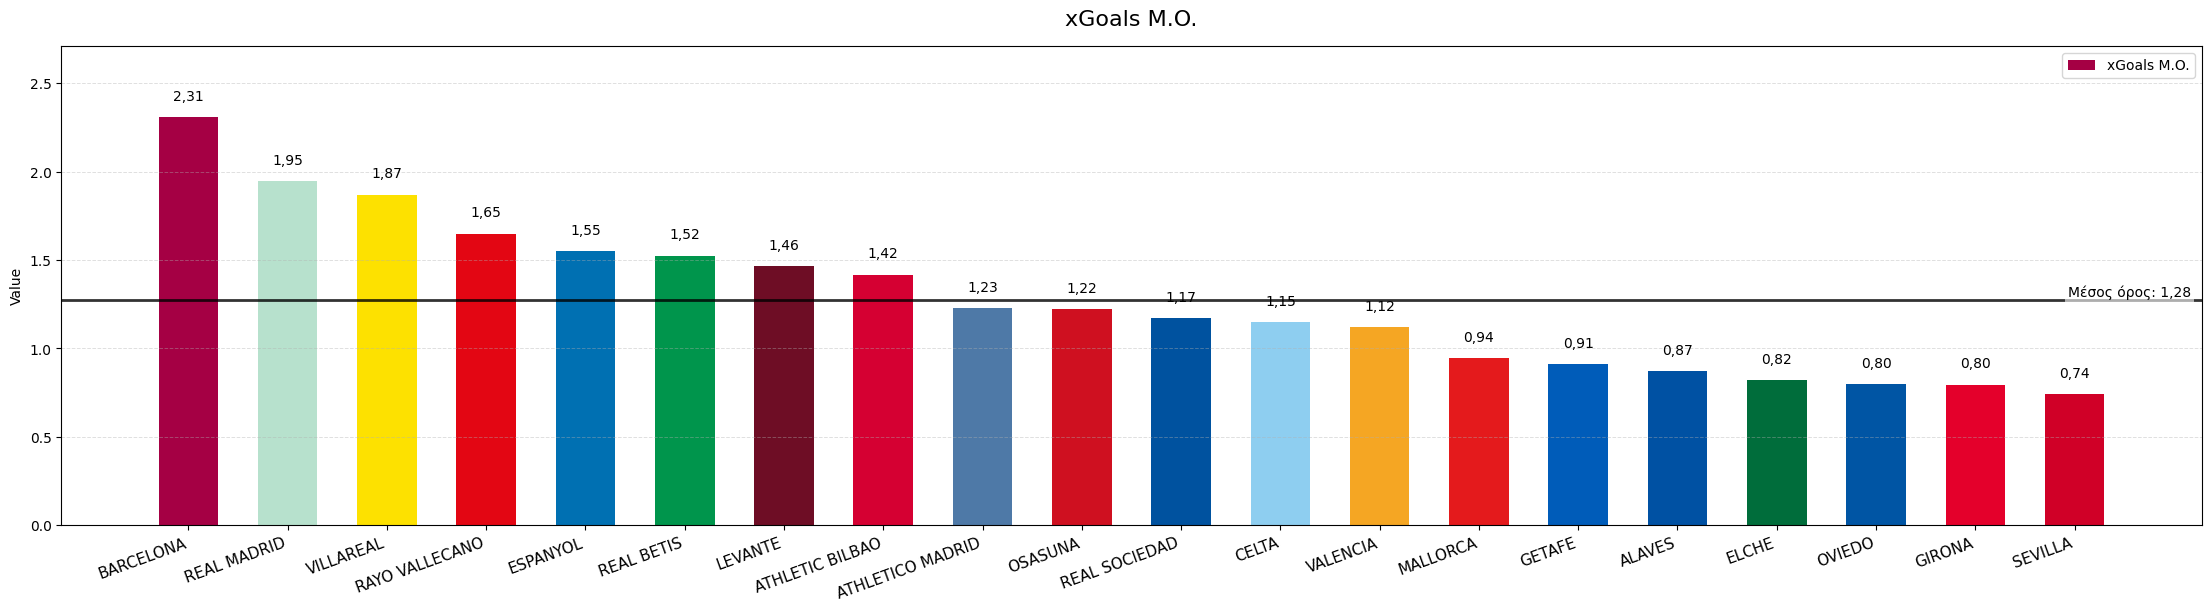

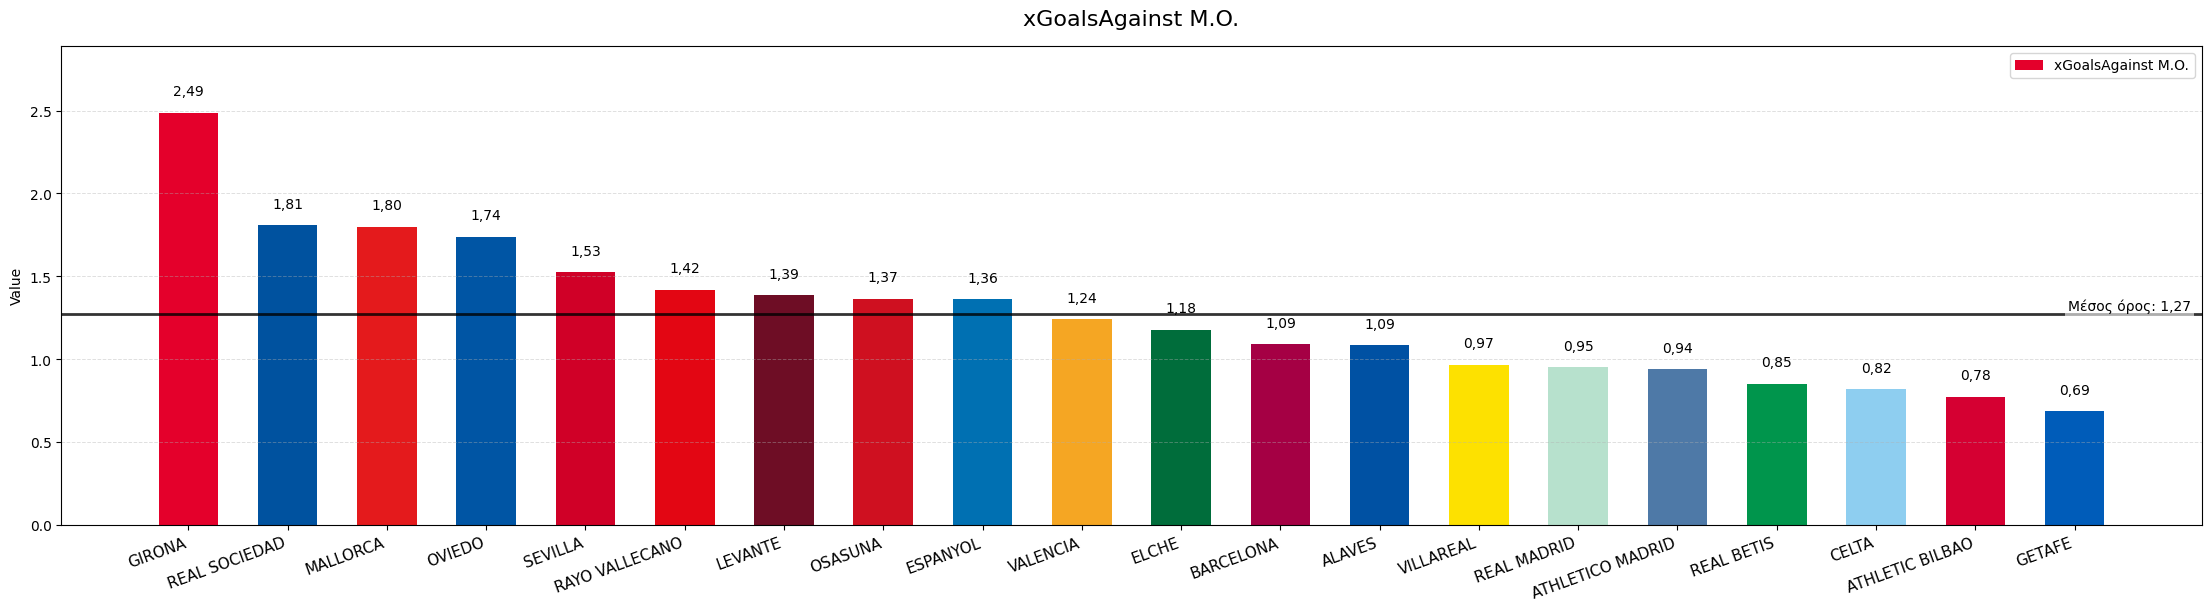

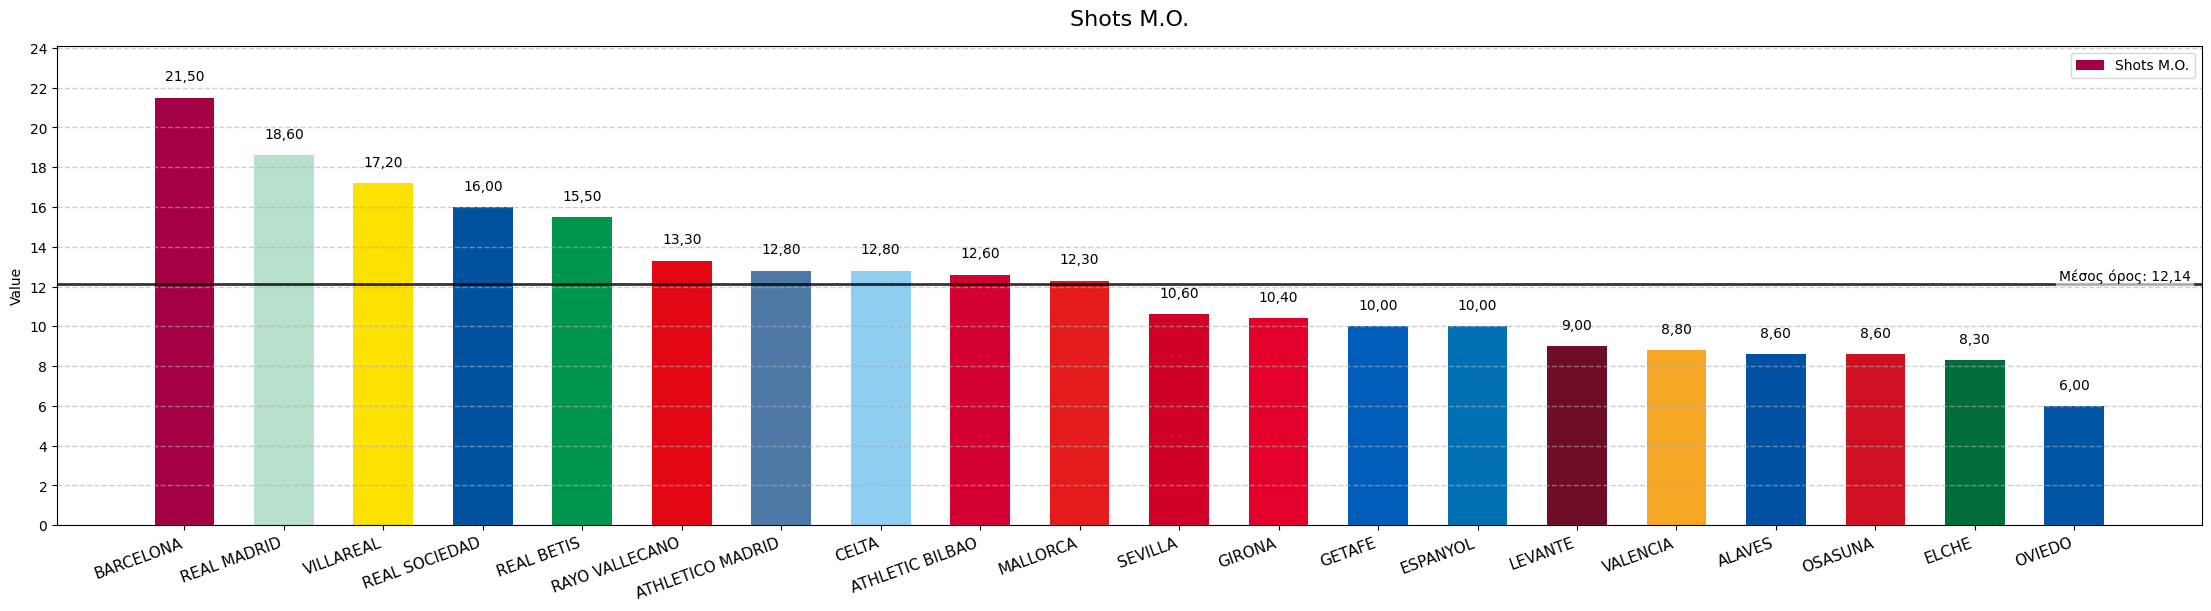

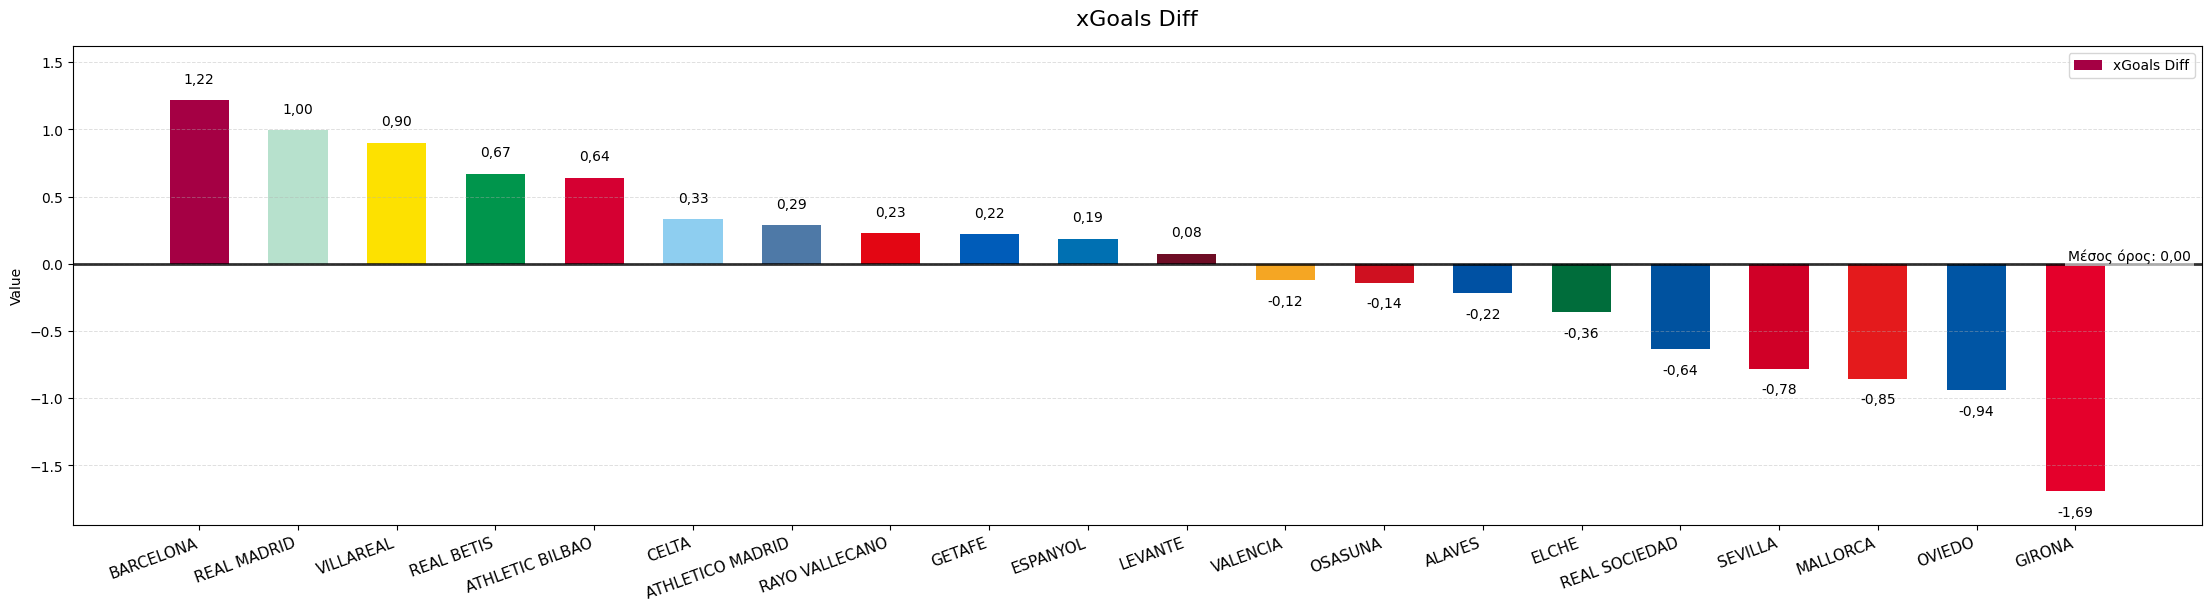

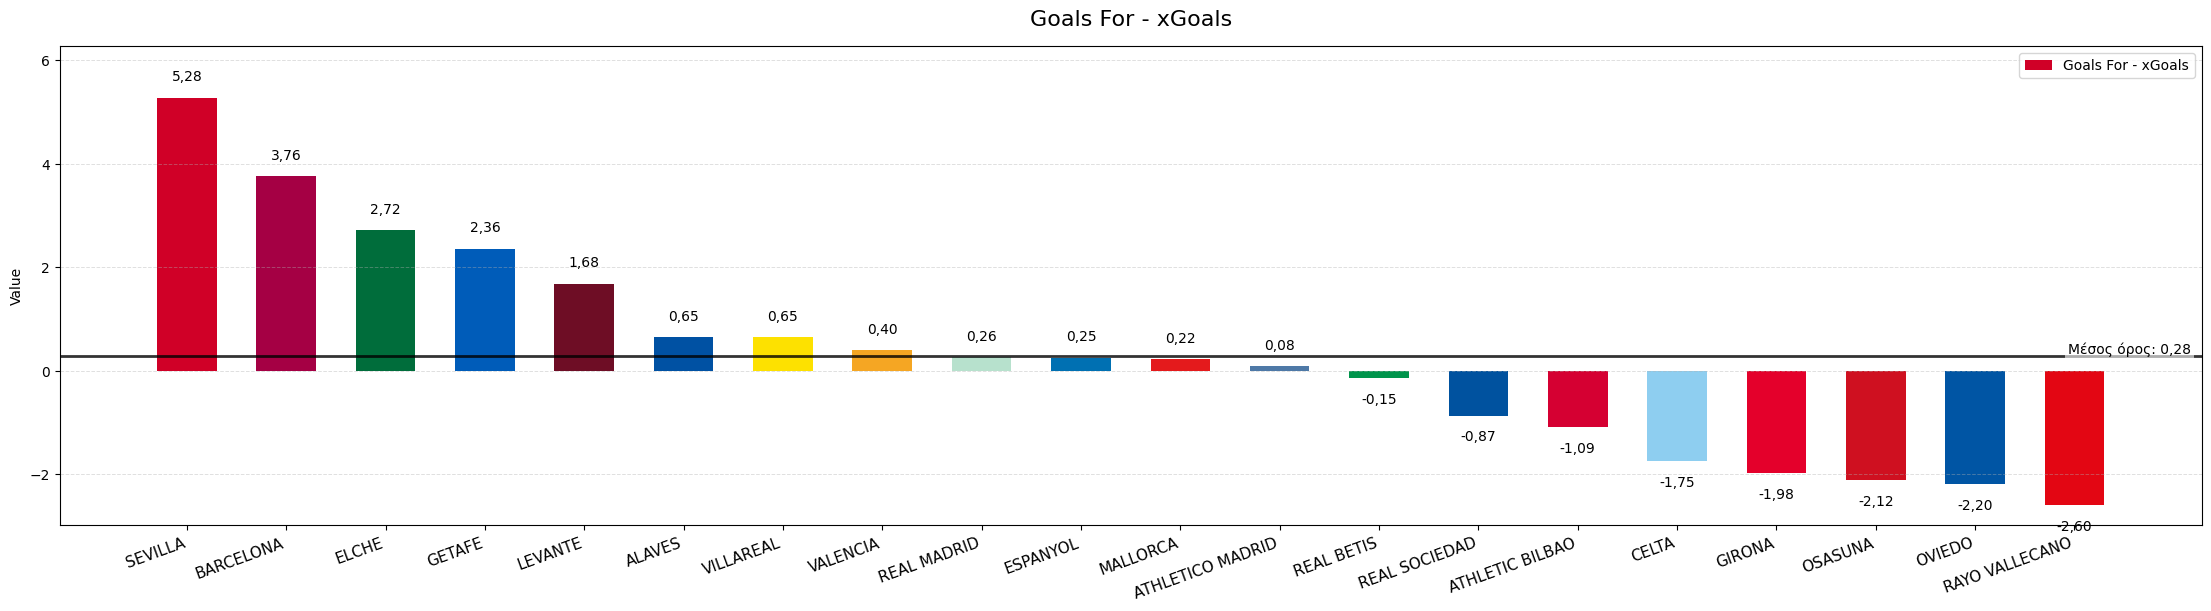

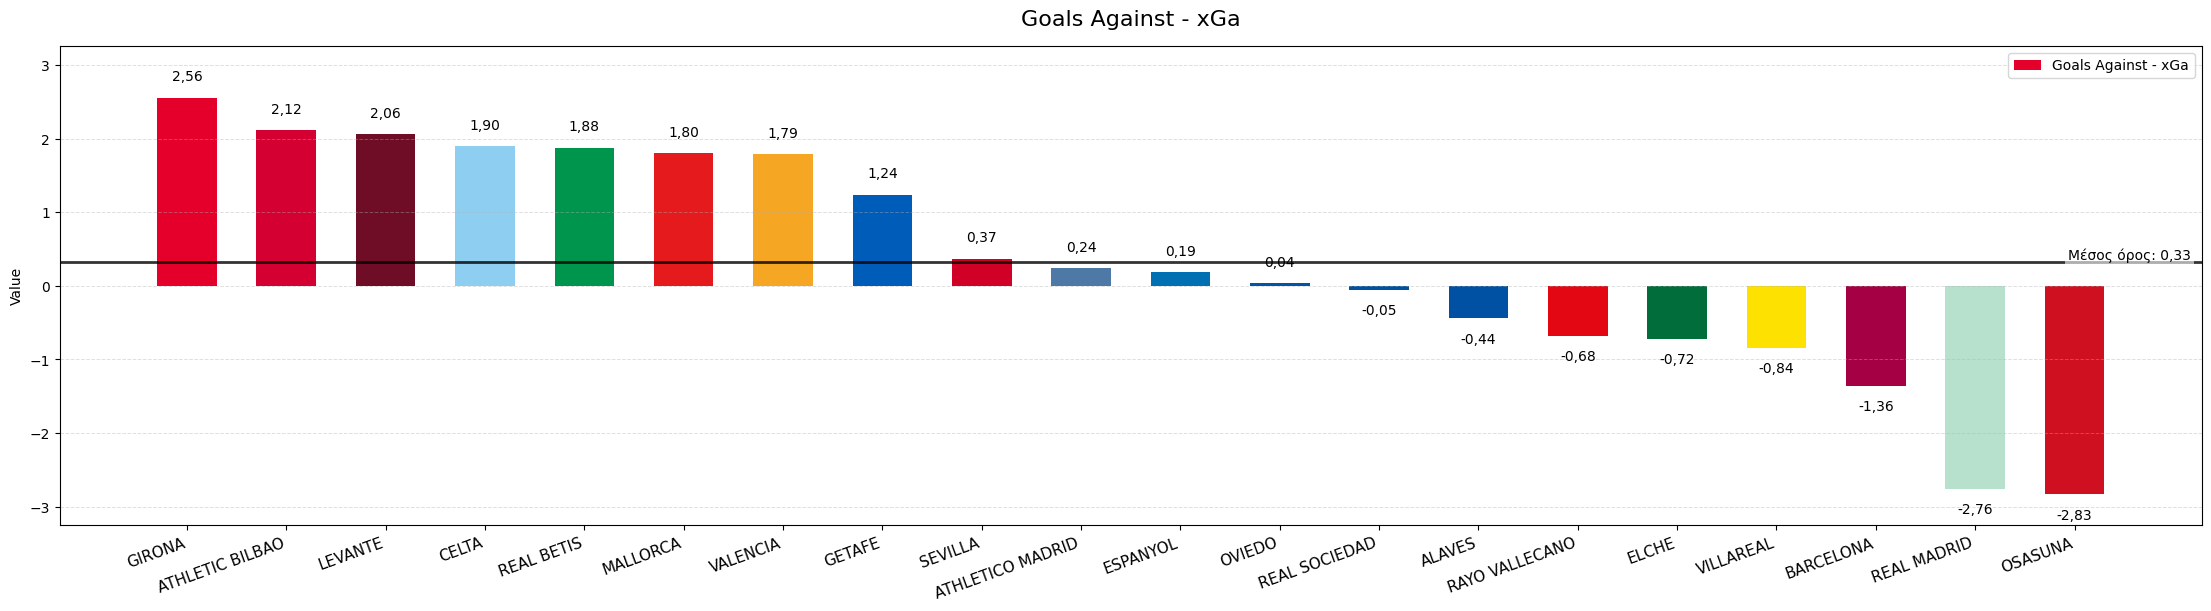

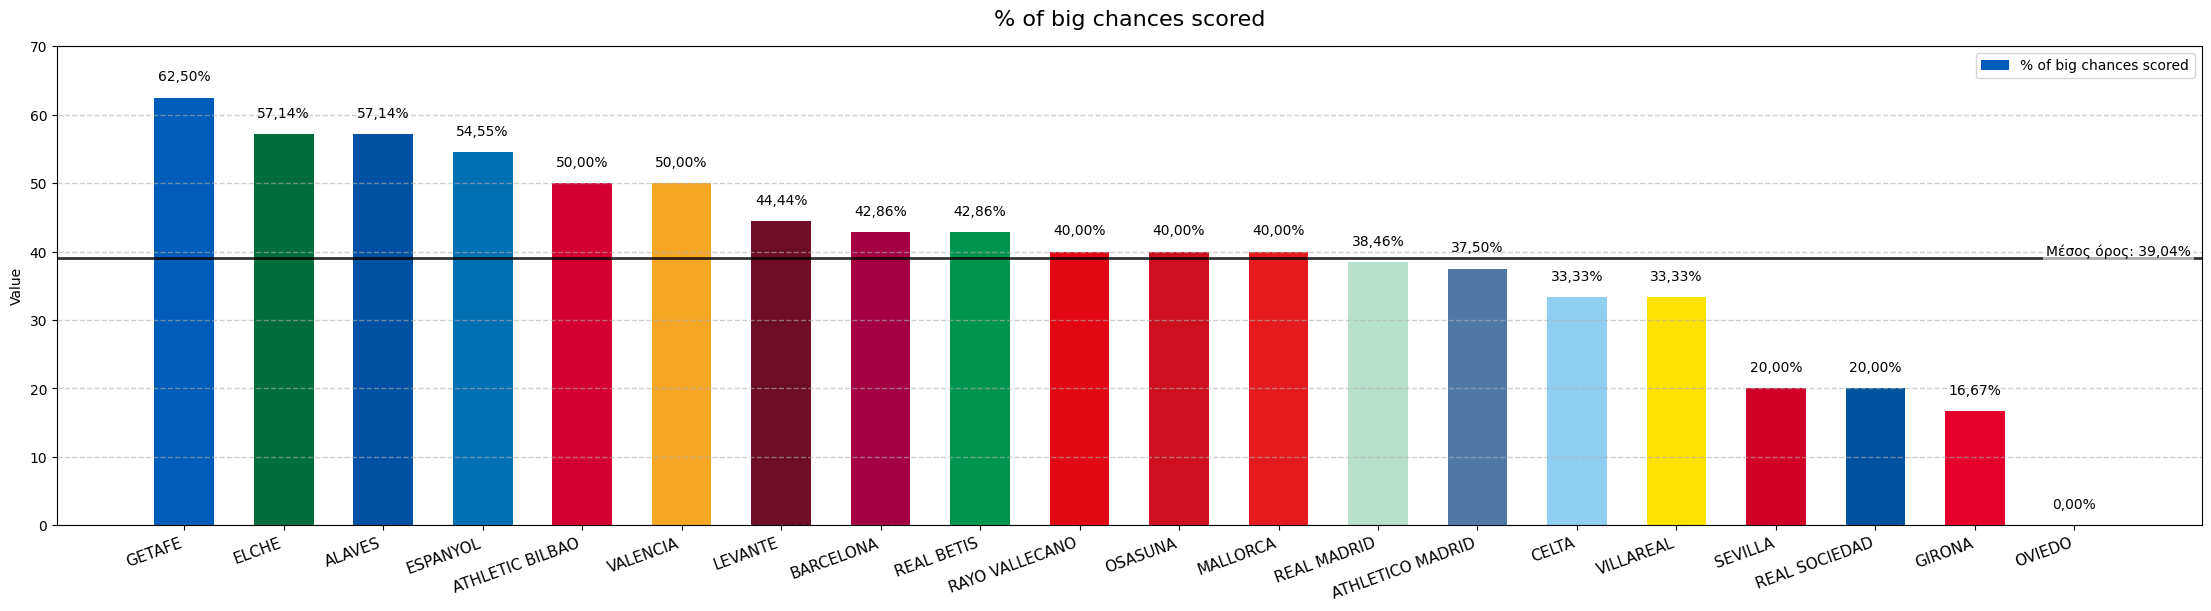

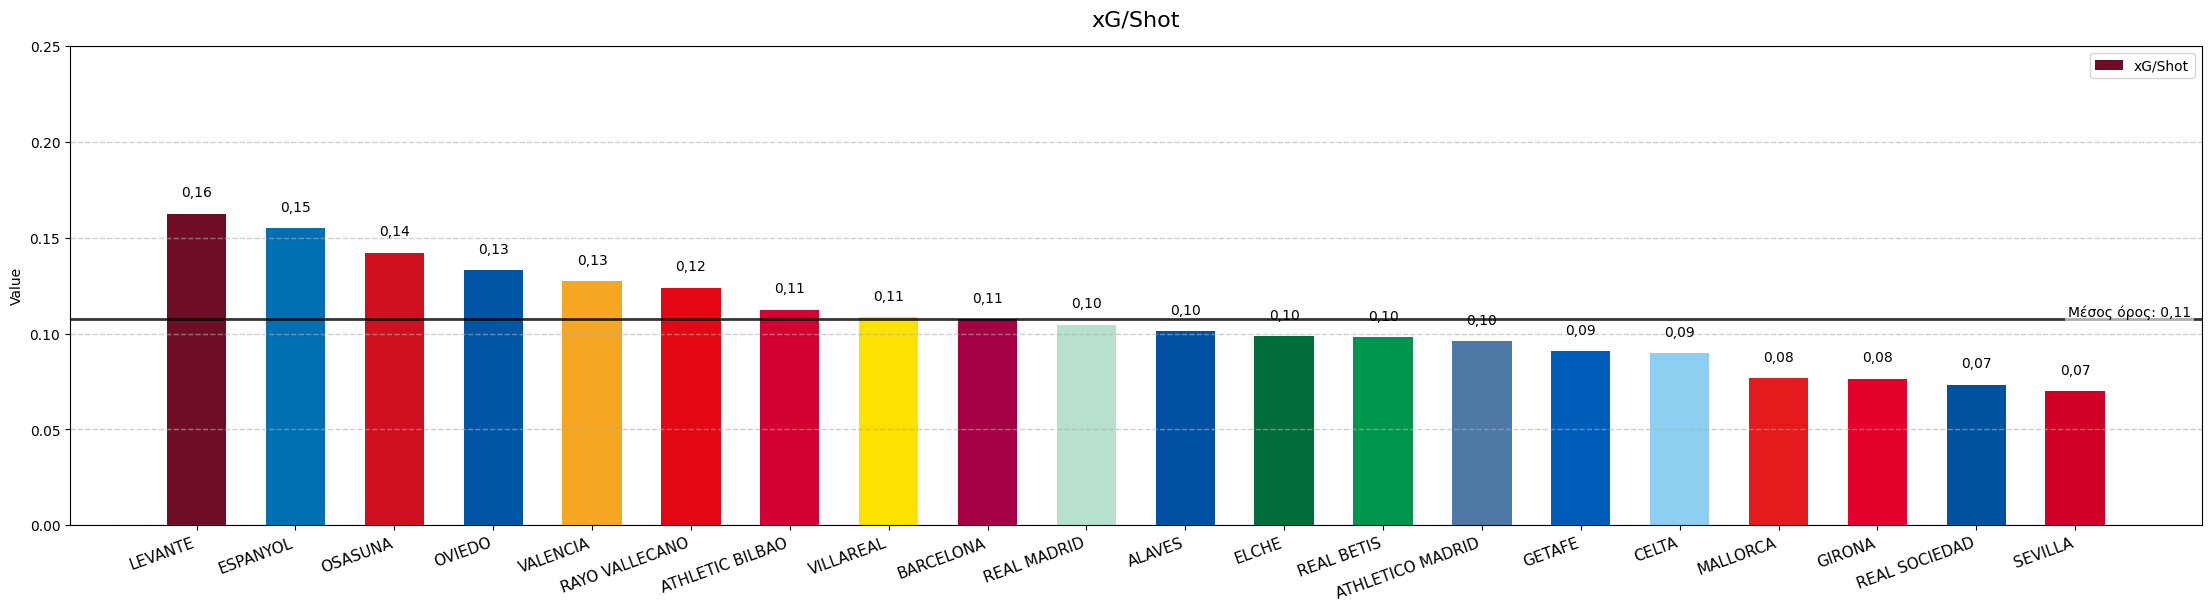

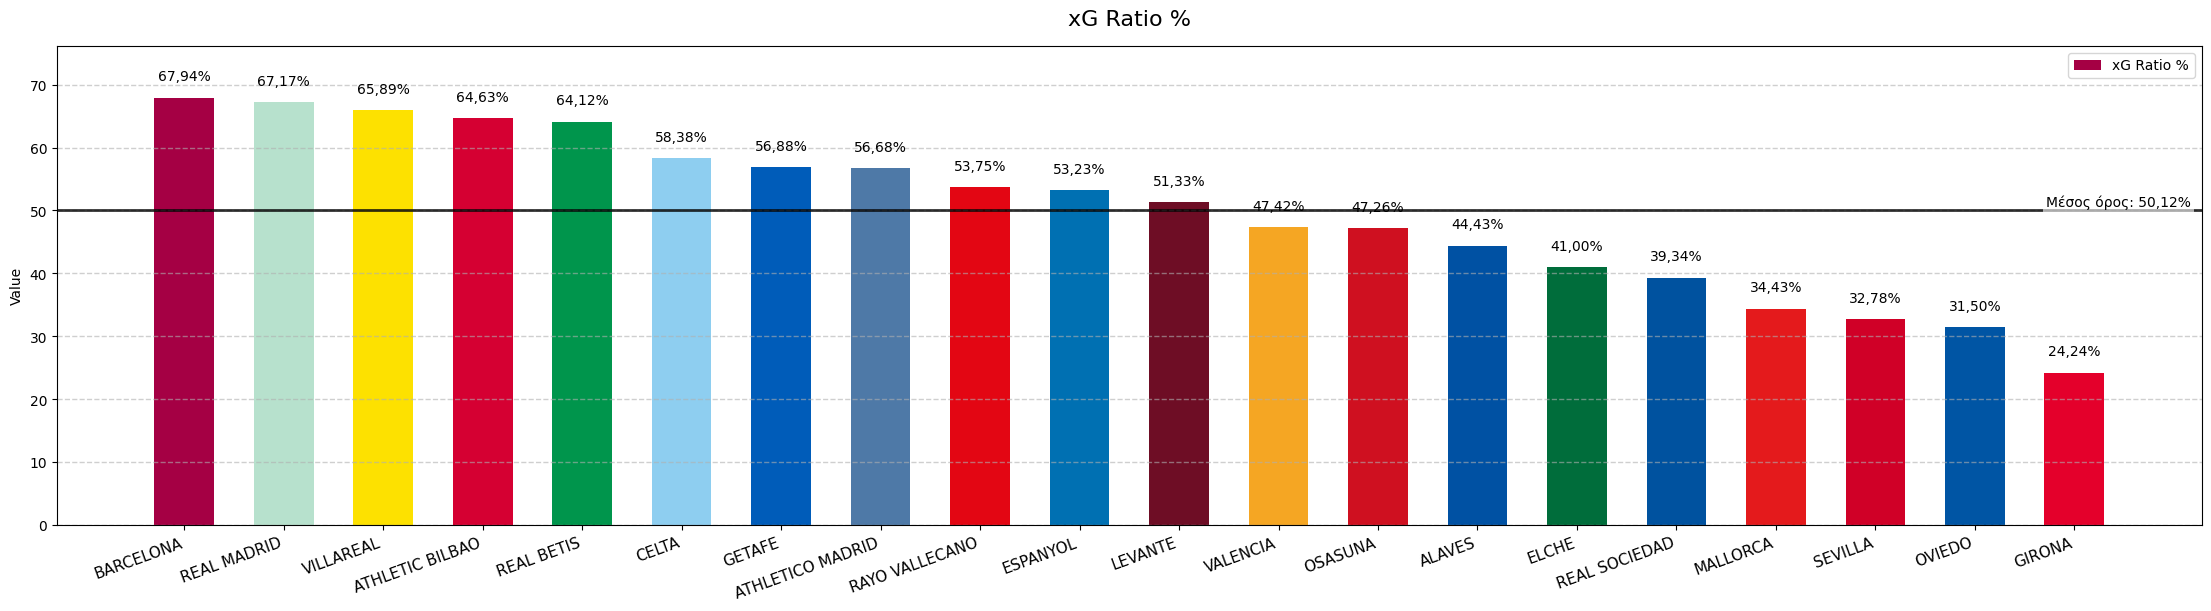

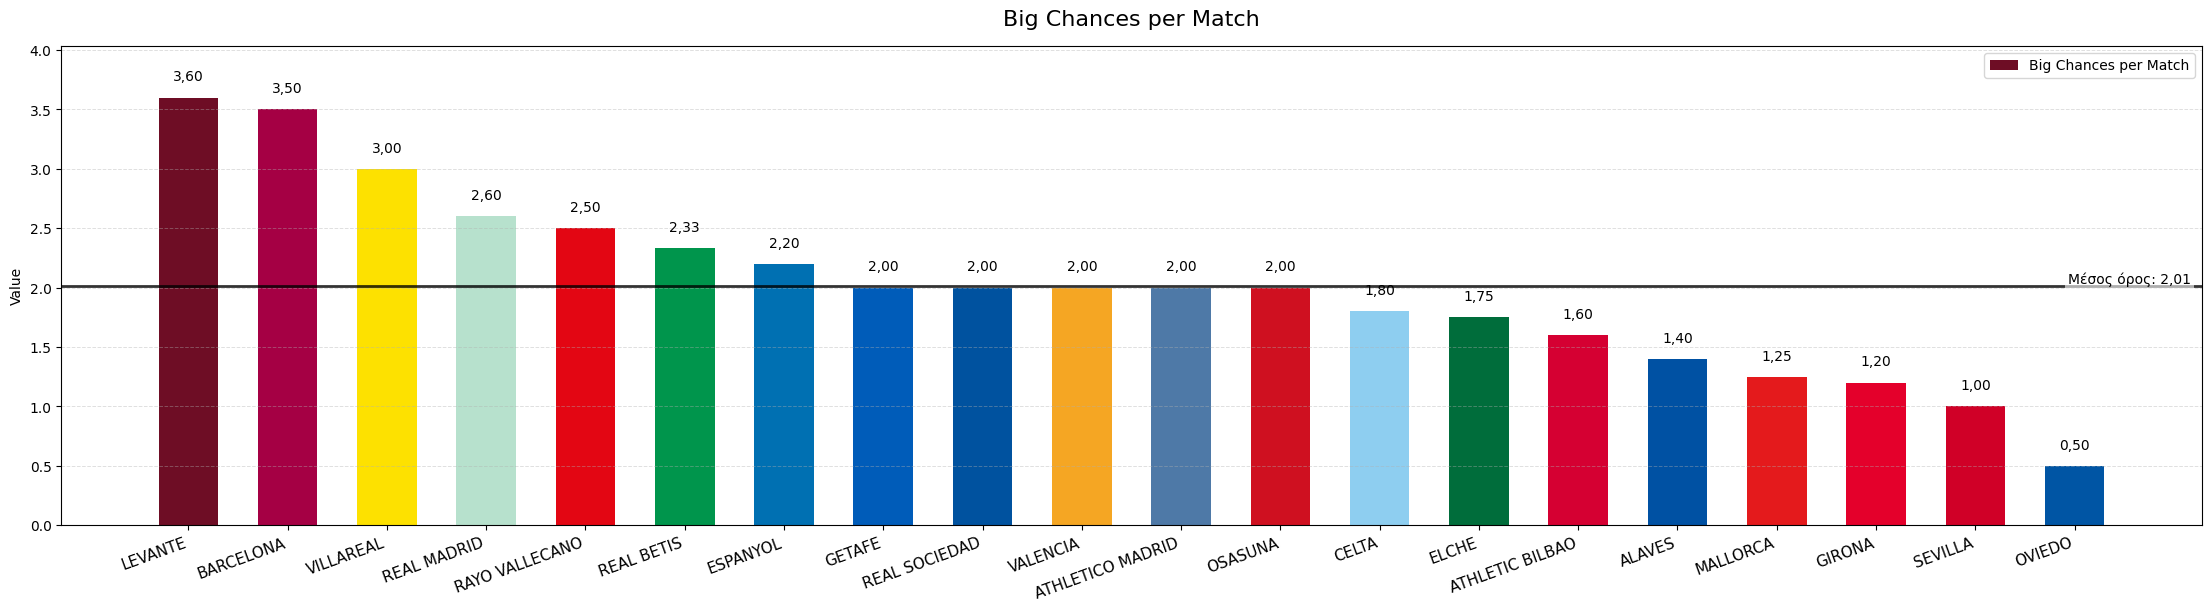

In [3]:
# ==== LIVE Google Sheet → La Liga plots (1 chart per figure + xG Ratio % + Big Chances/Match) ====
CSV_URL_LALIGA = "https://docs.google.com/spreadsheets/d/1mqqU8nYPpFimhvrsaJnMYRaE4dcckllW8TUXtZk09WE/export?format=csv&gid=0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.errors import ParserError

# ---------- Load & clean ----------
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

def prepare_sheet(csv_url):
    tried = []
    for kwargs in ({},
                   {"sep": ";"},
                   {"sep": None, "engine": "python"}):
        try:
            df = pd.read_csv(csv_url, **kwargs)
            break
        except ParserError as e:
            tried.append((kwargs, str(e)))
            df = None
    if df is None:
        raise RuntimeError(f"Could not parse the sheet. Tried: {tried}")

    df = promote_first_row_to_header(df)
    raw_df = df.copy()

    metric_col = df.columns[0]
    df[metric_col] = df[metric_col].astype(str).str.strip()

    # numerics: drop %, normalize comma decimal
    num_df = df.copy()
    for c in num_df.columns[1:]:
        col = (num_df[c].astype('string')
               .str.replace('%', '', regex=False)
               .str.replace('\u00a0', ' ', regex=False)
               .str.replace(',', '.', regex=False))
        num_df[c] = pd.to_numeric(col, errors='coerce')

    # optional 'Colors' row
    sheet_colors = None
    mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
    if mask.any():
        row = raw_df.loc[mask].iloc[0, 1:]
        if all(isinstance(x, str) and x.strip().startswith("#") for x in row):
            sheet_colors = row

    return {"num_df": num_df, "raw_df": raw_df, "metric_col": metric_col,
            "teams": list(num_df.columns[1:]), "sheet_colors": sheet_colors}

def get_metric_series(ctx, name: str) -> pd.Series:
    df = ctx["num_df"]; metric_col = ctx["metric_col"]
    target = name.strip().casefold()
    exact = df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return df.loc[exact].iloc[0, 1:]
    contains = df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return df.loc[contains].iloc[0, 1:]
    raise ValueError("Metric not found. Available:\n - " + "\n - ".join(df[metric_col].astype(str)))

# ---------- Colors (fallback if no 'Colors' row) ----------
LALIGA_COLORS = {
    "REAL MADRID":    "#B7E1CD",
    "BARCELONA":      "#a50044",
    "GETAFE":         "#005cb9",
    "ATHLETIC BILBAO":"#d50032",
    "ESPANYOL":       "#0070b2",
    "VILLAREAL":      "#fde100",  # match your sheet spelling
    "ALAVES":         "#0051a3",
    "ELCHE":          "#006d3b",
    "OSASUNA":        "#cf1020",
    "REAL BETIS":     "#00954c",
    "ATLÉTICO MADRID":"#c72c41",
    "ATLETICO MADRID":"#c72c41",
    "ATHLETIC MADRID":"#c72c41",
    "SEVILLA":        "#d00027",
    "CELTA":          "#8ecef0",
    "VALENCIA":       "#f5a623",
    "OVIEDO":         "#0055a4",
    "REAL SOCIEDAD":  "#00529f",
    "MALLORCA":       "#e41a1c",
    "LEVANTE":        "#6e0d25",
    "GIRONA":         "#e4002b",
    "RAYO VALLECANO": "#e30613",
}

def team_color(team, ctx, fallback_map):
    sc = ctx["sheet_colors"]
    if sc is not None and team in sc and str(sc[team]).startswith("#"):
        return str(sc[team])
    return fallback_map.get(team, "#4e79a7")

# ---------- Plotters ----------
def plot_metric_bar(ctx, metric_name: str, assume_percent=False, fallback_colors=LALIGA_COLORS):
    s = get_metric_series(ctx, metric_name).astype(float).sort_values(ascending=False)

    name_ci   = metric_name.strip().casefold()
    is_shots  = (name_ci == "shots m.o.")
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=metric_name)

    ax.set_title(metric_name, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits (xG/Shot fixed 0..0.30)
    if is_xgshot:
        ax.set_ylim(0.0, 0.25)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if is_shots:
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif is_xgshot:
        ax.yaxis.set_major_locator(MultipleLocator(0.05))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line (no % for xG/Shot)
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = (f"{mean_val:.2f}".replace('.', ',')
                  if is_xgshot else f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else ""))
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Fixed pixel offset labels
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        label = (f"{val:.2f}".replace(".", ",")
                 if is_xgshot else f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else ""))
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

def plot_custom_series(ctx, series: pd.Series, title: str, assume_percent=False,
                       fallback_colors=LALIGA_COLORS, special_ticks=None, fixed_ylim=None):
    s = pd.Series(series.values, index=series.index, dtype=float).sort_values(ascending=False)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=title)

    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits
    if fixed_ylim is not None:
        ax.set_ylim(*fixed_ylim)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if special_ticks is not None:
        ax.yaxis.set_major_locator(MultipleLocator(special_ticks))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    ax.text(0.995, mean_val,
            f"Μέσος όρος: {mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else ""),
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Labels
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        ax.annotate(f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else ""),
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

# ---------- Build context ----------
ctx_laliga = prepare_sheet(CSV_URL_LALIGA)

# ---------- Base plots ----------
METRICS_TO_PLOT = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),          # grid every 2
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),
    ("xG/Shot", False),             # fixed 0..0.30, ticks 0.05
]

for name, is_percent in METRICS_TO_PLOT:
    plot_metric_bar(ctx_laliga, name, assume_percent=is_percent, fallback_colors=LALIGA_COLORS)

# ---------- Extras to keep: xG Ratio % + Big Chances per Match ----------
xg  = get_metric_series(ctx_laliga, "xGoals M.O.")
xga = get_metric_series(ctx_laliga, "xGoalsAgainst M.O.")
xg_ratio_pct = (xg / (xg + xga).replace(0, np.nan)) * 100
plot_custom_series(ctx_laliga, xg_ratio_pct, "xG Ratio %", assume_percent=True, fallback_colors=LALIGA_COLORS)

matches = get_metric_series(ctx_laliga, "Match Played")
big_chances = get_metric_series(ctx_laliga, "Big Chances")
bc_per_match = big_chances / matches.replace(0, np.nan)
plot_custom_series(ctx_laliga, bc_per_match, "Big Chances per Match", assume_percent=False, fallback_colors=LALIGA_COLORS)


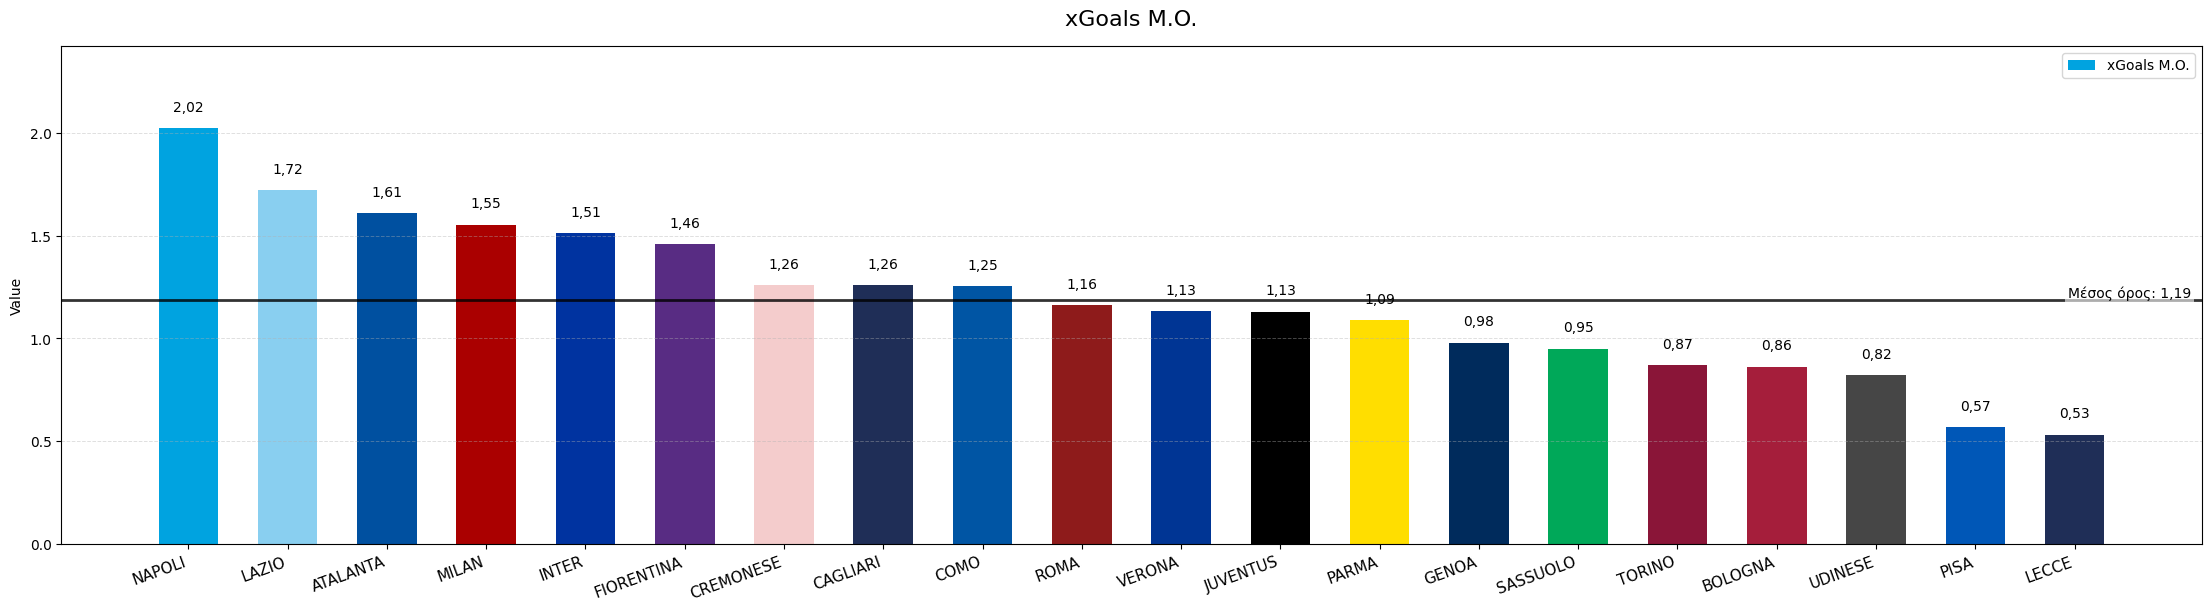

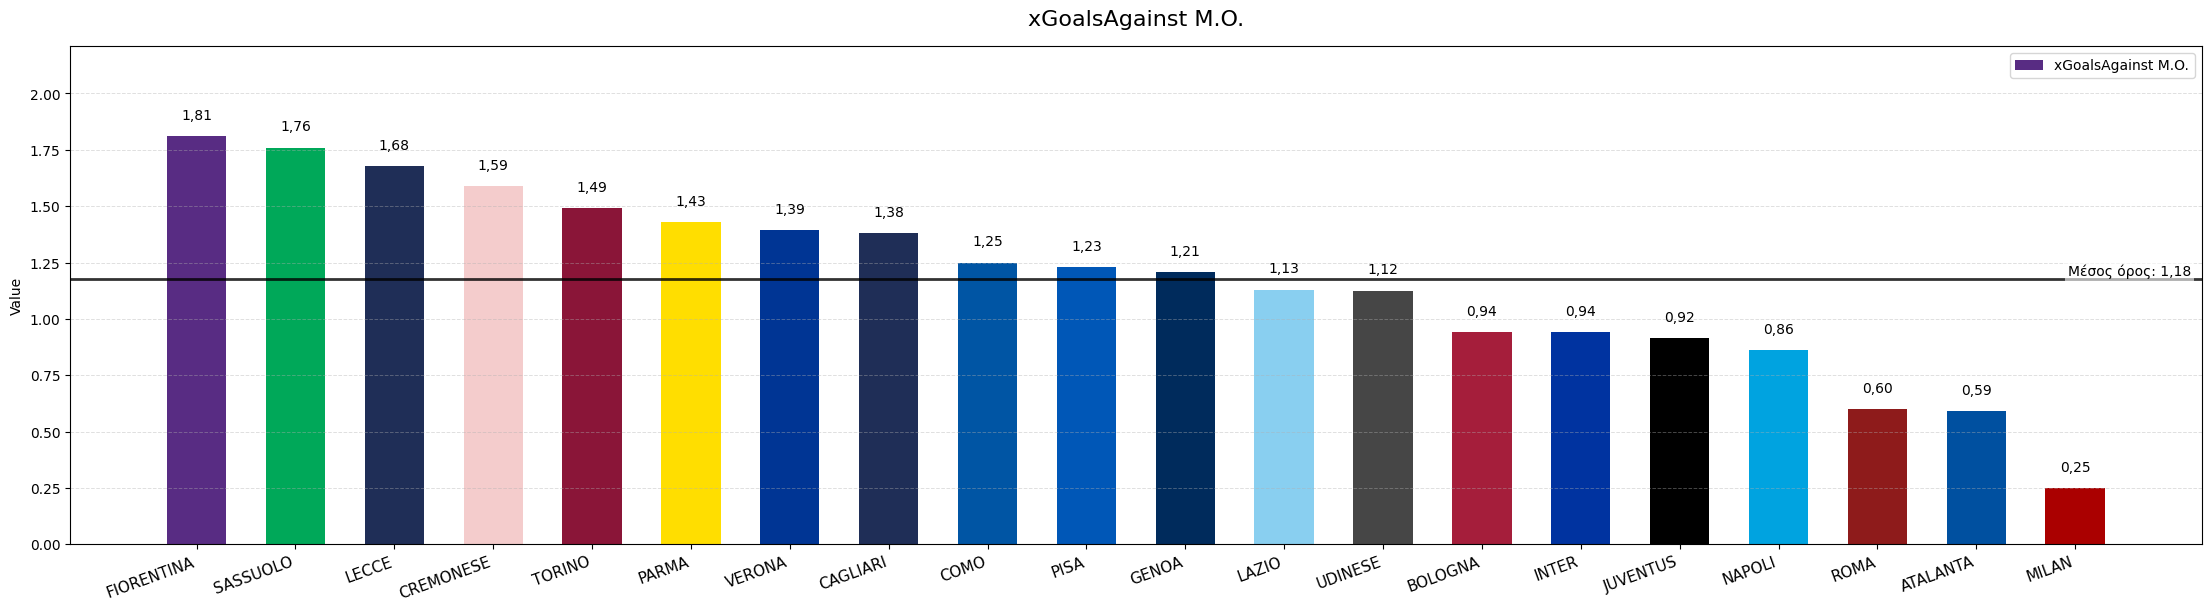

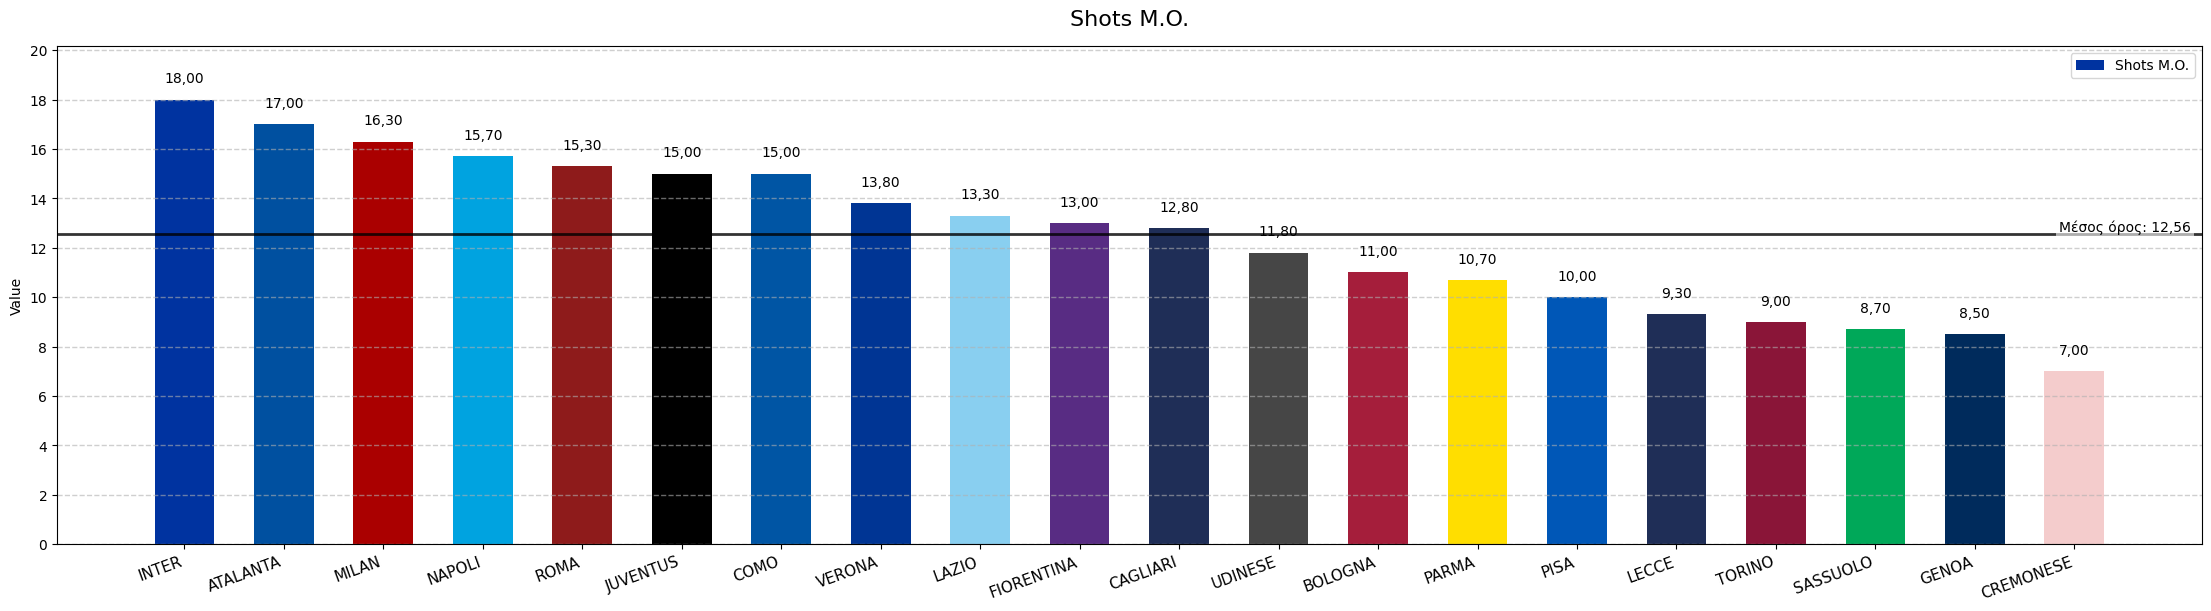

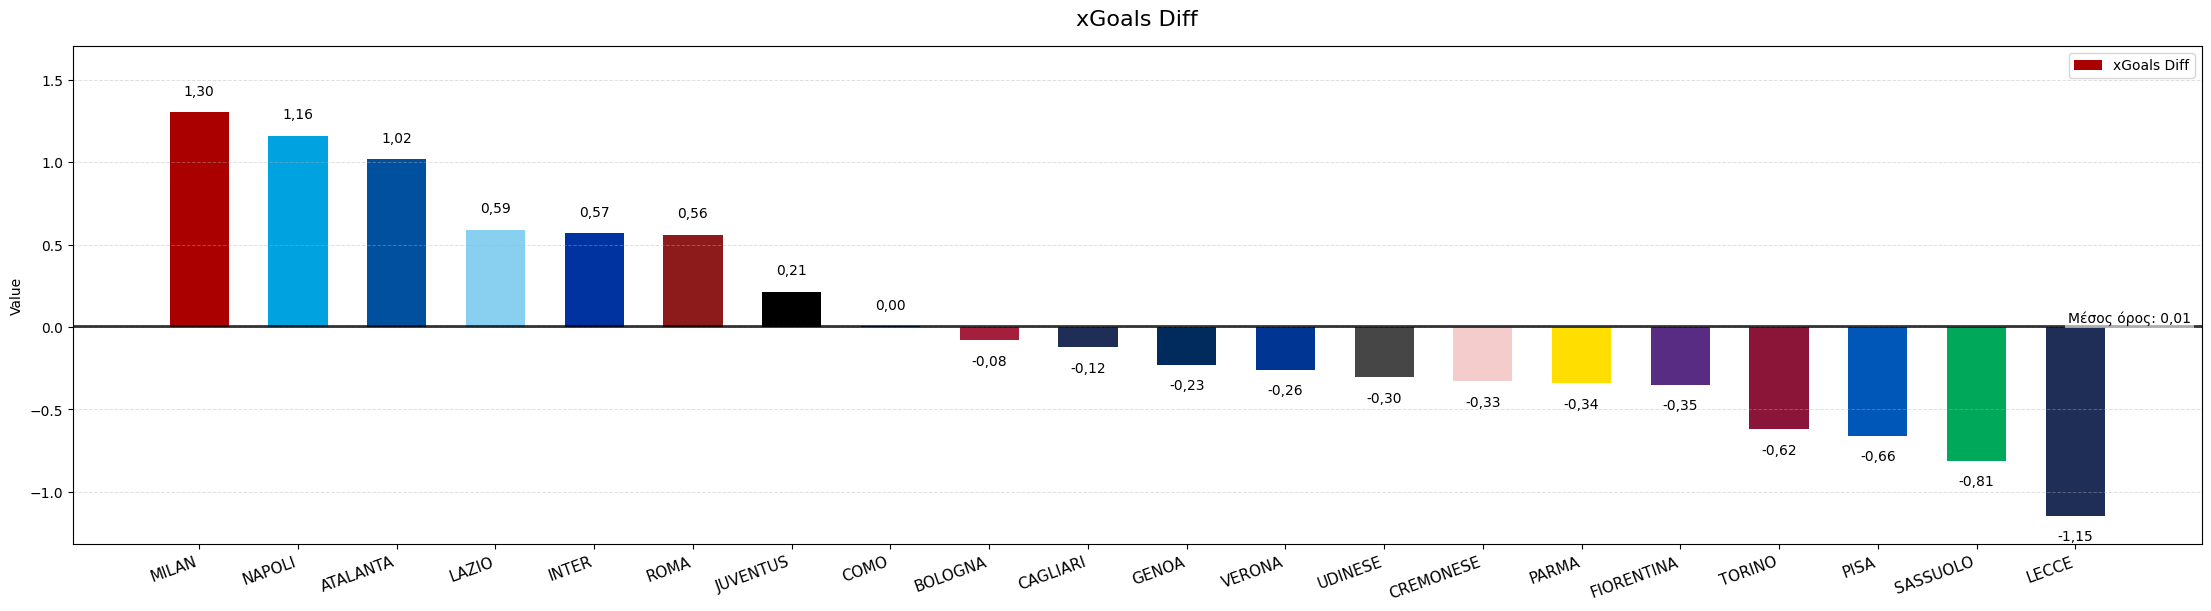

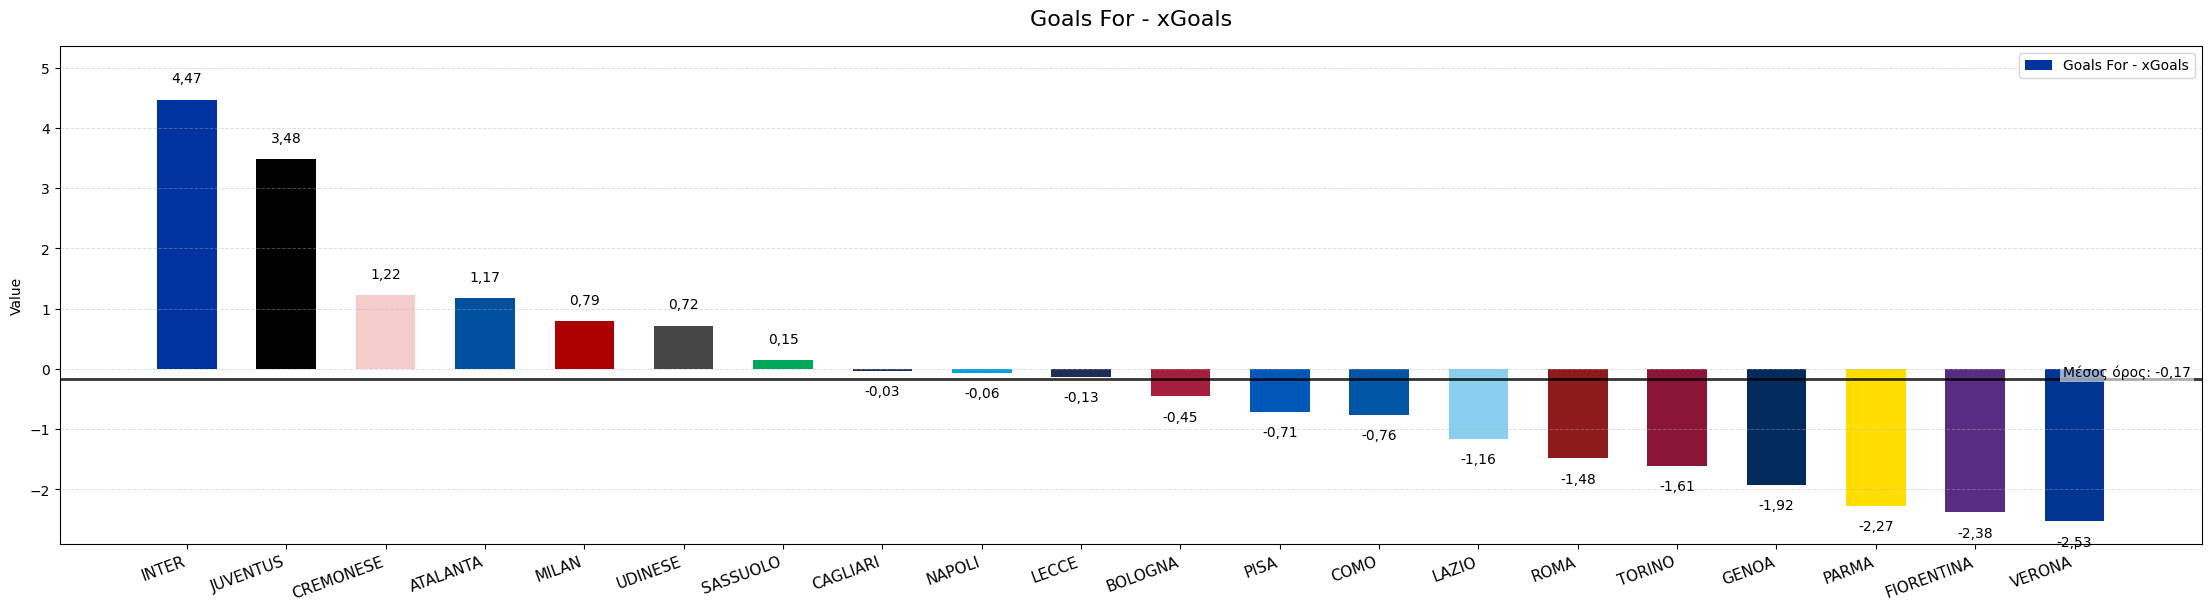

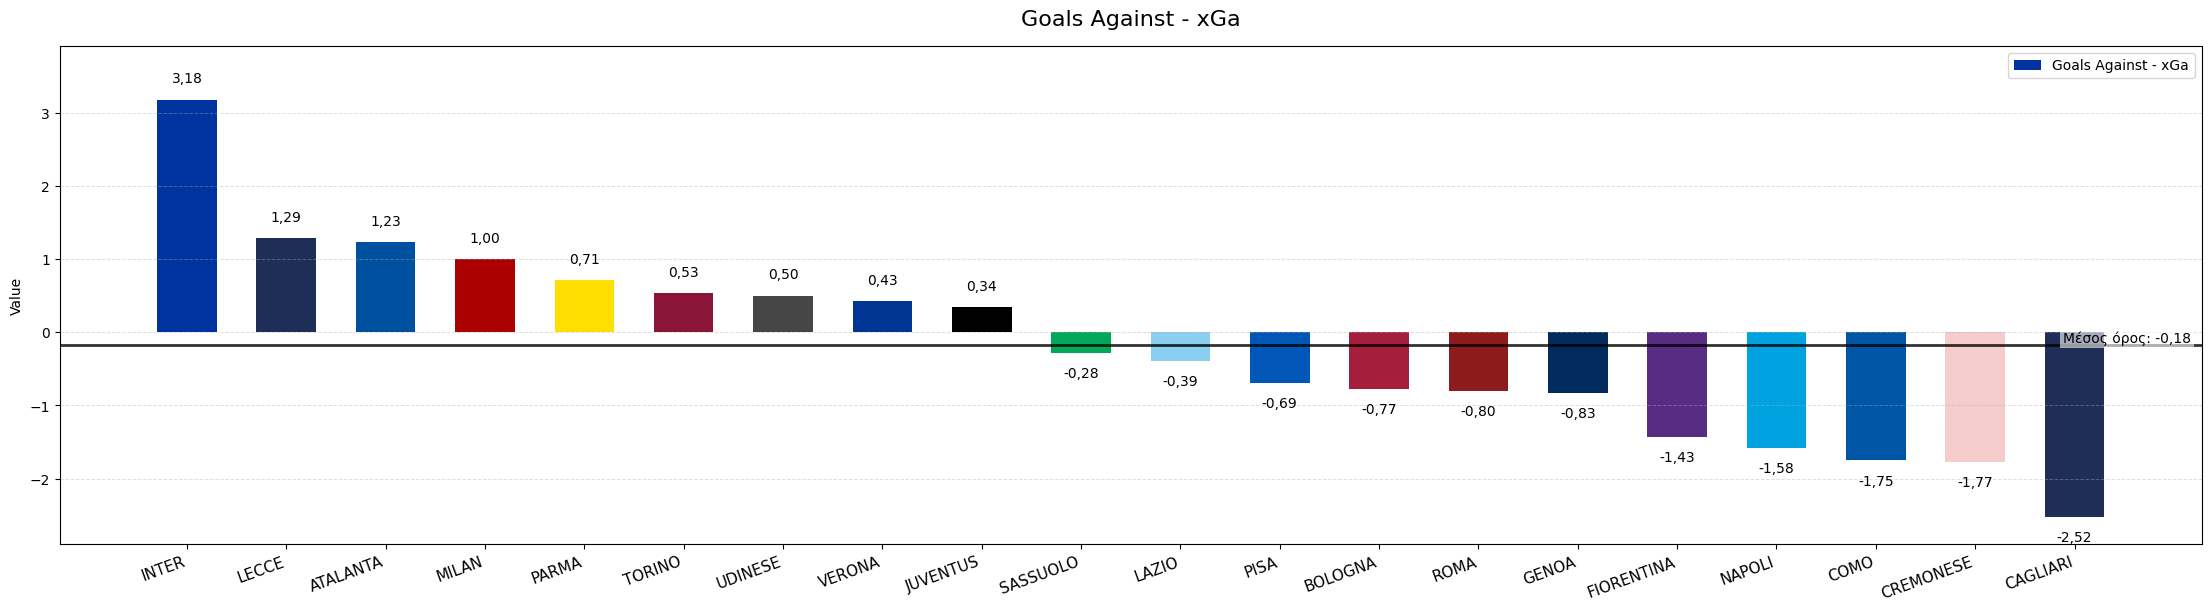

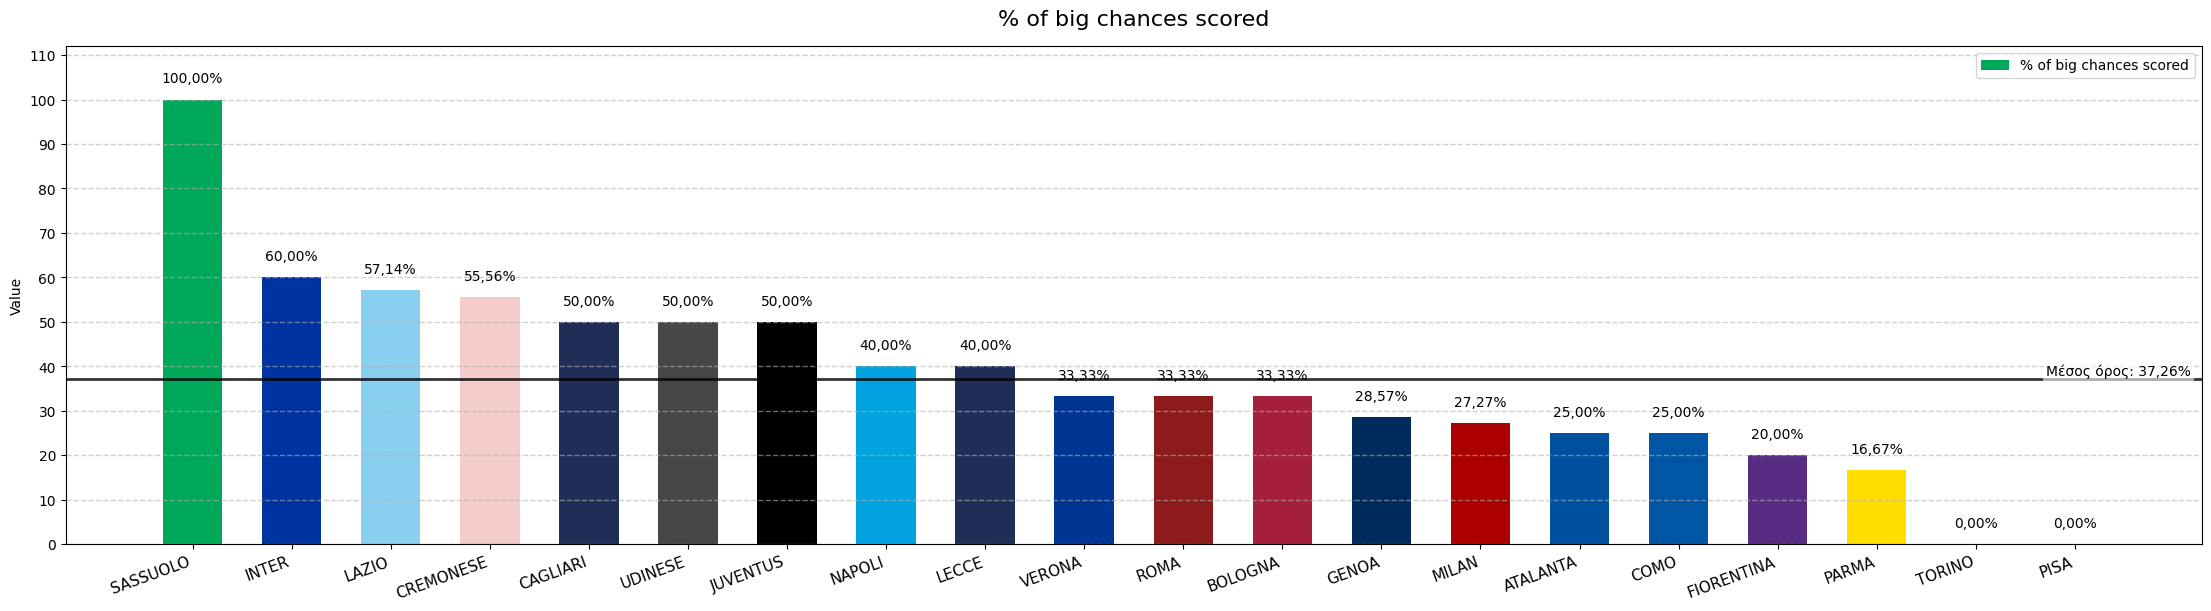

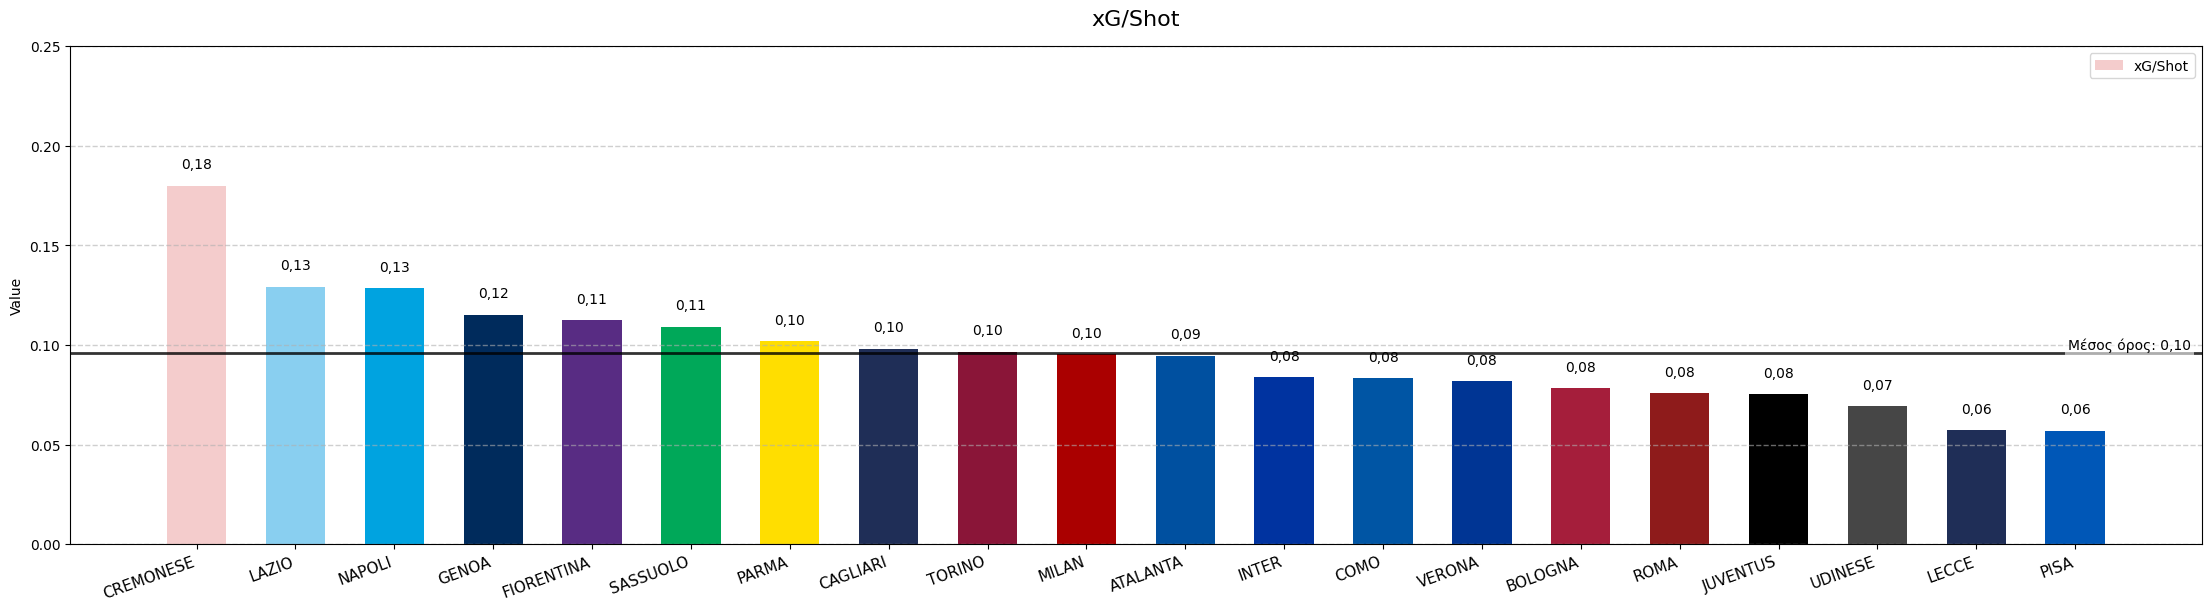

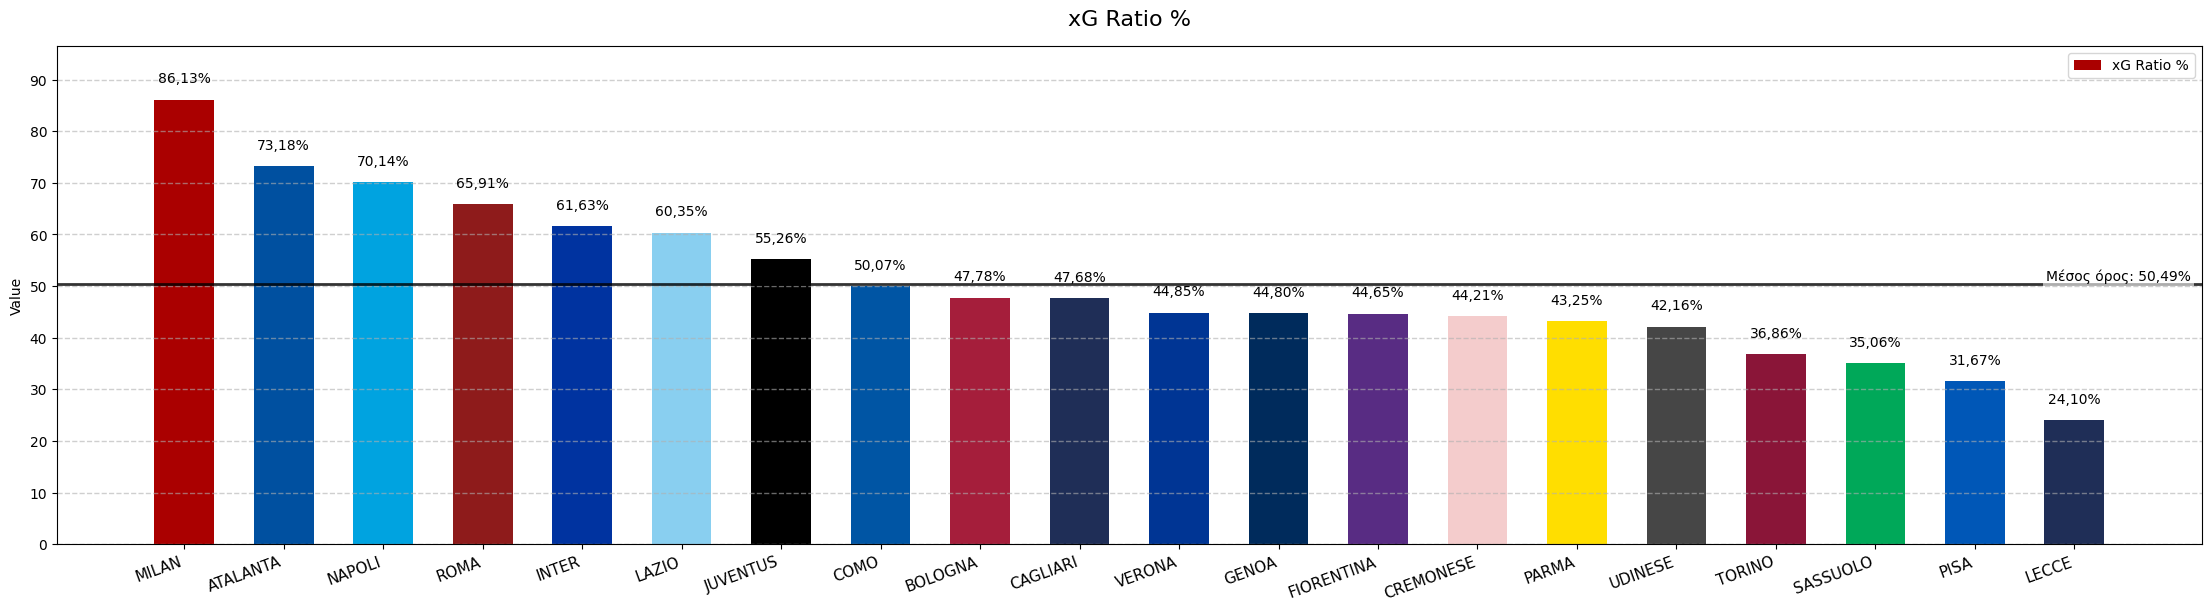

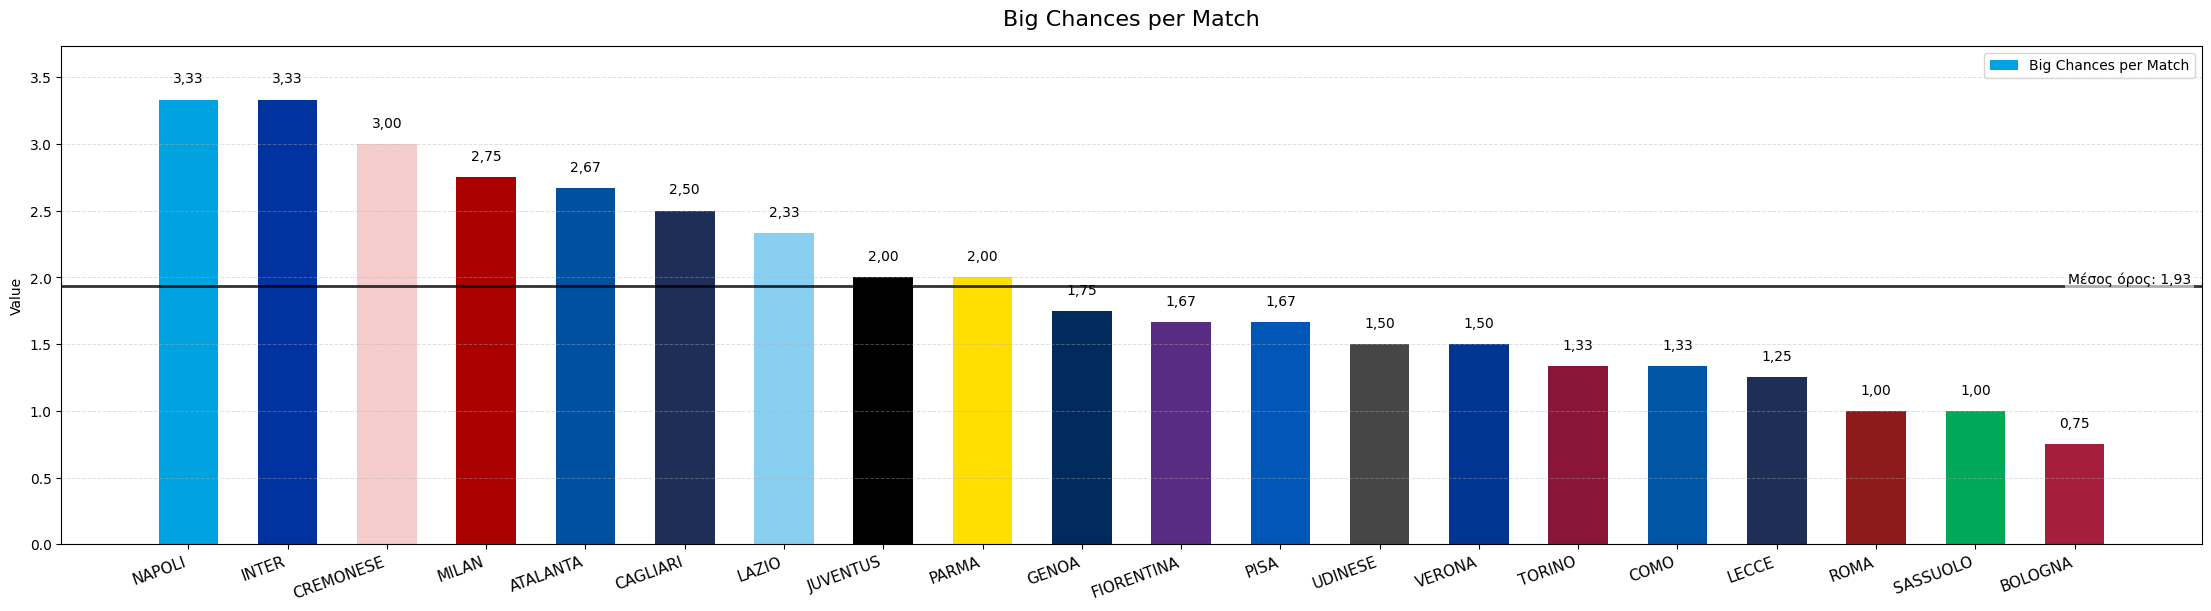

In [4]:
# ==== LIVE Google Sheet → Serie A plots (1 chart per figure + xG Ratio % + Big Chances/Match) ====
CSV_URL_SERIEA = "https://docs.google.com/spreadsheets/d/1MKZQzHF9PAhNzGMP4U-uISQ5wV-DgUvUWtNGtUtduXI/export?format=csv&gid=0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.errors import ParserError

# ---------- Helpers to load & clean ----------
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

def prepare_sheet(csv_url):
    tried = []
    for kwargs in ({},
                   {"sep": ";"},
                   {"sep": None, "engine": "python"}):
        try:
            df = pd.read_csv(csv_url, **kwargs)
            break
        except ParserError as e:
            tried.append((kwargs, str(e)))
            df = None
    if df is None:
        raise RuntimeError(f"Could not parse the sheet. Tried: {tried}")

    df = promote_first_row_to_header(df)
    raw_df = df.copy()

    metric_col = df.columns[0]
    df[metric_col] = df[metric_col].astype(str).str.strip()

    # numbers: drop %, replace comma decimal, coerce to float
    num_df = df.copy()
    for c in num_df.columns[1:]:
        col = (num_df[c].astype('string')
               .str.replace('%', '', regex=False)
               .str.replace('\u00a0', ' ', regex=False)
               .str.replace(',', '.', regex=False))
        num_df[c] = pd.to_numeric(col, errors='coerce')

    # optional 'Colors' row
    sheet_colors = None
    mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
    if mask.any():
        row = raw_df.loc[mask].iloc[0, 1:]
        if all(isinstance(x, str) and x.strip().startswith("#") for x in row):
            sheet_colors = row

    return {"num_df": num_df, "raw_df": raw_df, "metric_col": metric_col,
            "teams": list(num_df.columns[1:]), "sheet_colors": sheet_colors}

def get_metric_series(ctx, name: str) -> pd.Series:
    df = ctx["num_df"]; metric_col = ctx["metric_col"]
    target = name.strip().casefold()
    exact = df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return df.loc[exact].iloc[0, 1:]
    contains = df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return df.loc[contains].iloc[0, 1:]
    raise ValueError("Metric not found. Available:\n - " + "\n - ".join(df[metric_col].astype(str)))

# ---------- Colors (fallback if no 'Colors' row) ----------
SERIEA_COLORS = {
    "NAPOLI":      "#00A3E0",
    "JUVENTUS":    "#000000",
    "INTER":       "#0033A0",
    "MILAN":       "#AA0000",
    "ROMA":        "#8E1B1B",
    "ATALANTA":    "#0050A0",
    "BOLOGNA":     "#A51E3B",
    "COMO":        "#0055A4",
    "LAZIO":       "#89CFF0",
    "FIORENTINA":  "#582C83",
    "UDINESE":     "#464646",
    "TORINO":      "#8A1538",
    "CAGLIARI":    "#1F2E57",
    "CREMONESE":   "#F4CCCC",
    "SASSUOLO":    "#00A859",
    "GENOA":       "#002B5C",
    "VERONA":      "#003594",
    "PISA":        "#0057B7",
    "PARMA":       "#FFDE00",
    "LECCE":       "#1F2E57",
}

def team_color(team, ctx, fallback_colors):
    sc = ctx.get("sheet_colors")
    if sc is not None and team in sc:
        col = str(sc[team]).strip()
        if col.startswith("#"):
            return col
    return (fallback_colors or {}).get(team, "#4e79a7")

# ---------- Plotters ----------
def plot_metric_bar(ctx, metric_name: str, assume_percent=False, fallback_colors=SERIEA_COLORS):
    s = get_metric_series(ctx, metric_name).astype(float).sort_values(ascending=False)

    name_ci   = metric_name.strip().casefold()
    is_shots  = (name_ci == "shots m.o.")
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=metric_name)

    ax.set_title(metric_name, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits (xG/Shot fixed 0..0.30)
    if is_xgshot:
        ax.set_ylim(0.0, 0.25)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if is_shots:
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif is_xgshot:
        ax.yaxis.set_major_locator(MultipleLocator(0.05))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line (no % for xG/Shot)
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = (f"{mean_val:.2f}".replace('.', ',')
                  if is_xgshot else f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else ""))
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Labels with a fixed pixel offset (same visual height)
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        label = (f"{val:.2f}".replace(".", ",")
                 if is_xgshot else f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else ""))
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

def plot_custom_series(ctx, series: pd.Series, title: str, assume_percent=False,
                       fallback_colors=SERIEA_COLORS, special_ticks=None, fixed_ylim=None):
    s = pd.Series(series.values, index=series.index, dtype=float).sort_values(ascending=False)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=title)

    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits for custom series
    if fixed_ylim is not None:
        ax.set_ylim(*fixed_ylim)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if special_ticks is not None:
        ax.yaxis.set_major_locator(MultipleLocator(special_ticks))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Labels (fixed pixel offset)
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        label = f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

# ---------- Build context ----------
ctx_seriea = prepare_sheet(CSV_URL_SERIEA)

# ---------- Base plots ----------
METRICS_TO_PLOT_SERIEA = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),          # grid every 2
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),
    ("xG/Shot", False),             # fixed 0..0.30, ticks 0.05, no %
]

for name, is_percent in METRICS_TO_PLOT_SERIEA:
    plot_metric_bar(ctx_seriea, name, assume_percent=is_percent, fallback_colors=SERIEA_COLORS)

# ---------- Extras to keep: xG Ratio % + Big Chances per Match ----------
xg  = get_metric_series(ctx_seriea, "xGoals M.O.")
xga = get_metric_series(ctx_seriea, "xGoalsAgainst M.O.")
xg_ratio_pct = (xg / (xg + xga).replace(0, np.nan)) * 100
plot_custom_series(ctx_seriea, xg_ratio_pct, "xG Ratio %", assume_percent=True, fallback_colors=SERIEA_COLORS)

matches = get_metric_series(ctx_seriea, "Match Played")
big_chances = get_metric_series(ctx_seriea, "Big Chances")
bc_per_match = big_chances / matches.replace(0, np.nan)
plot_custom_series(ctx_seriea, bc_per_match, "Big Chances per Match", assume_percent=False, fallback_colors=SERIEA_COLORS)


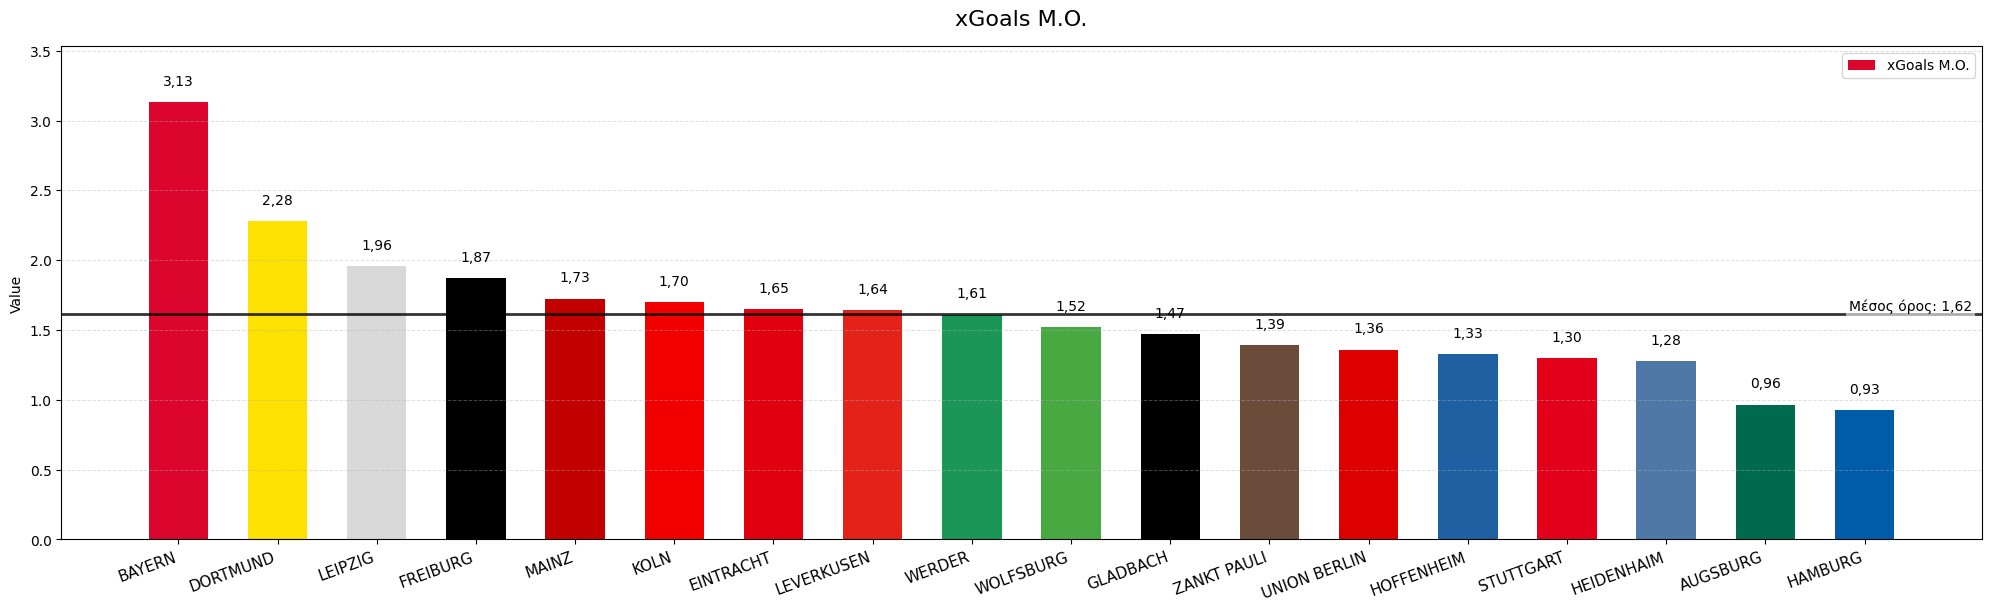

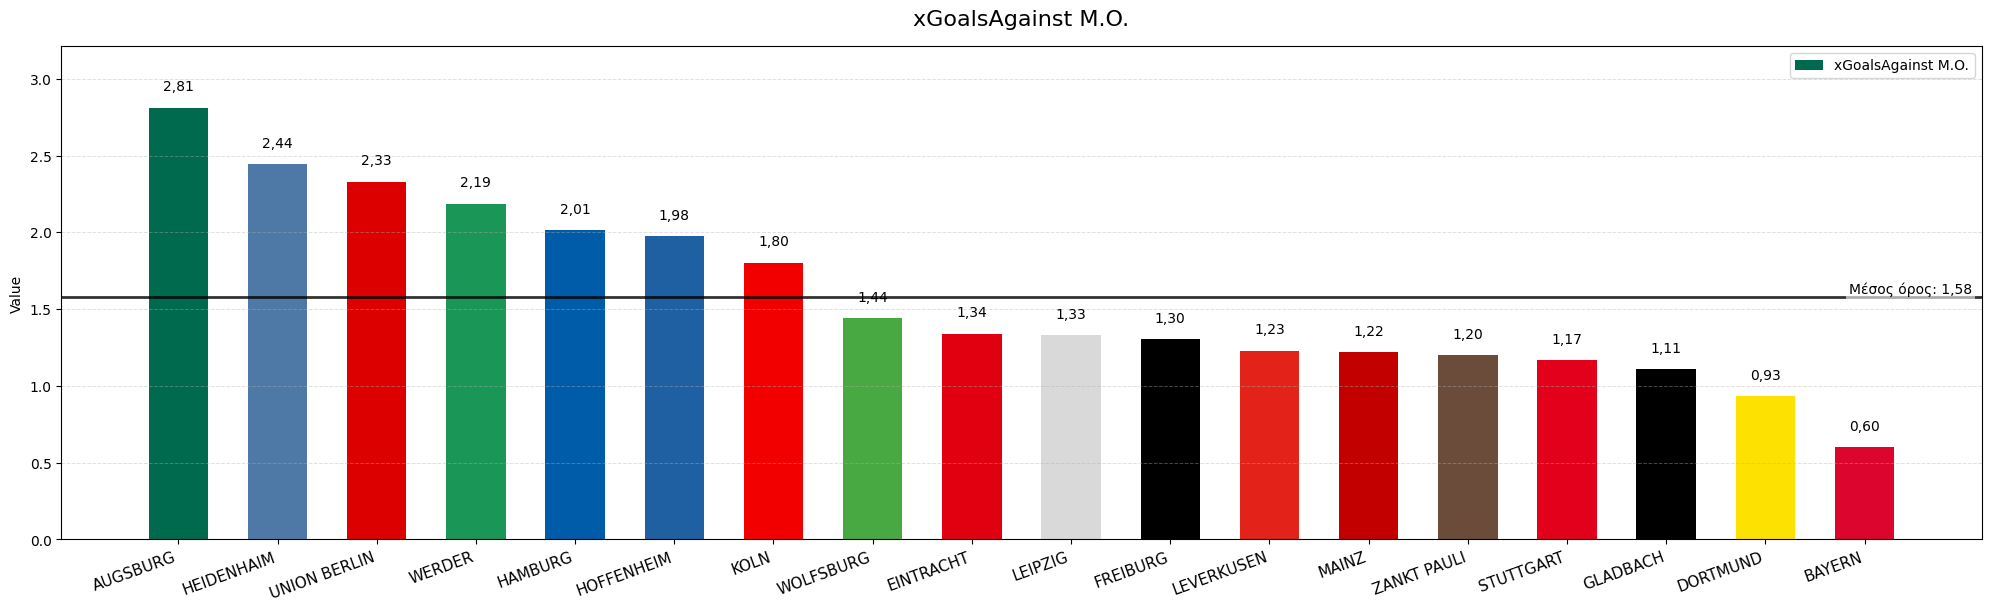

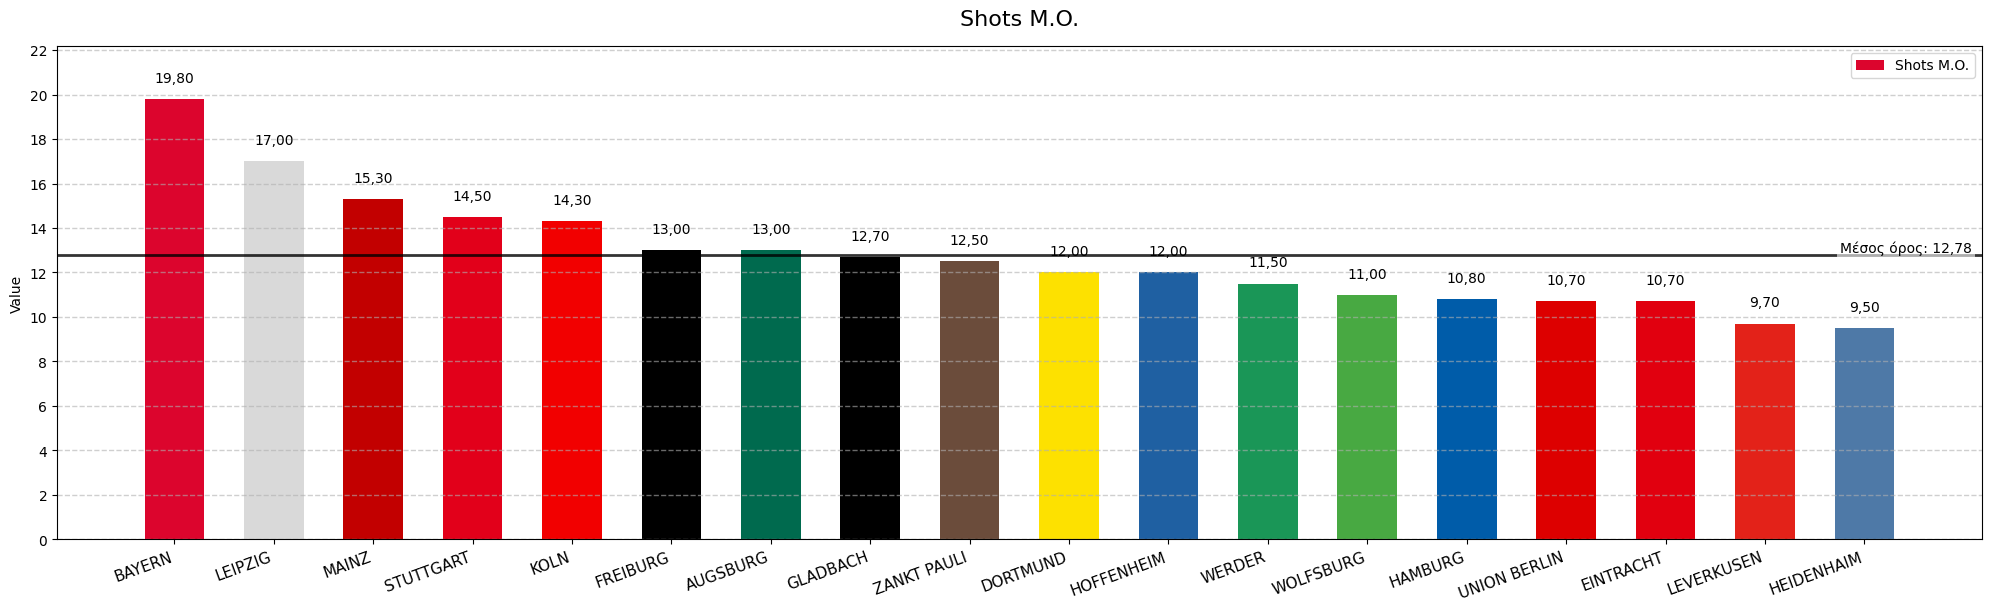

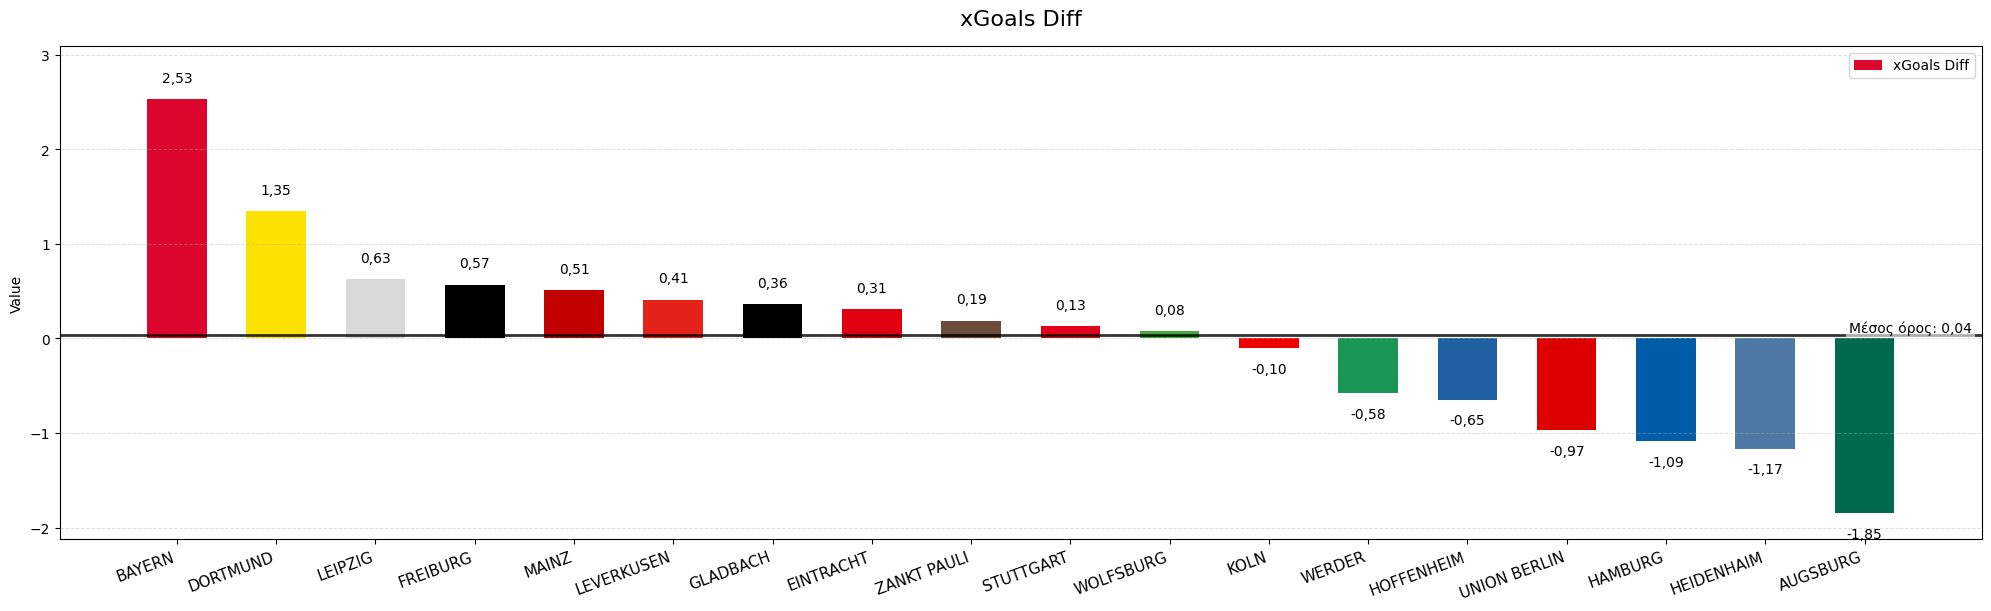

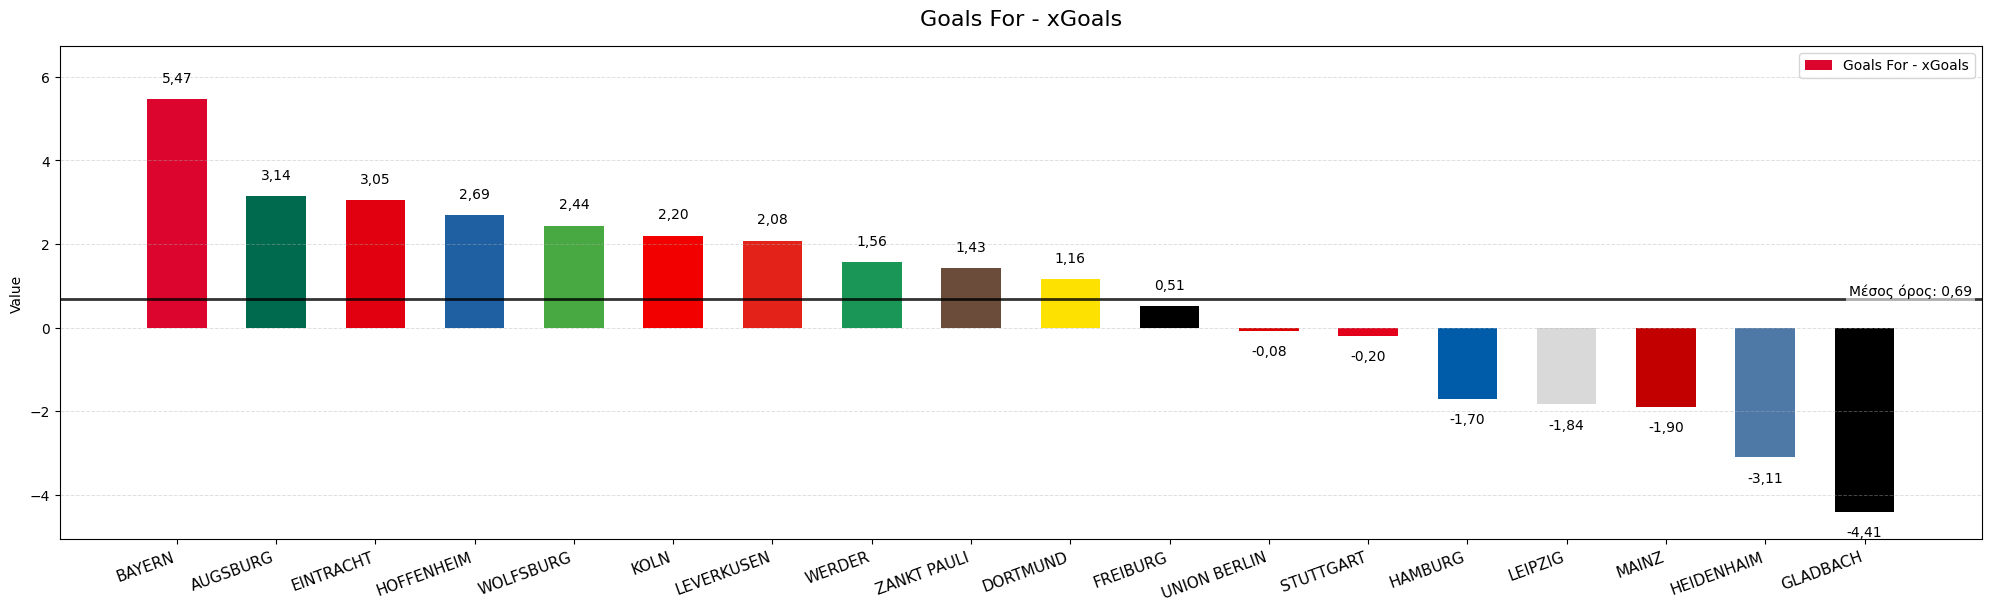

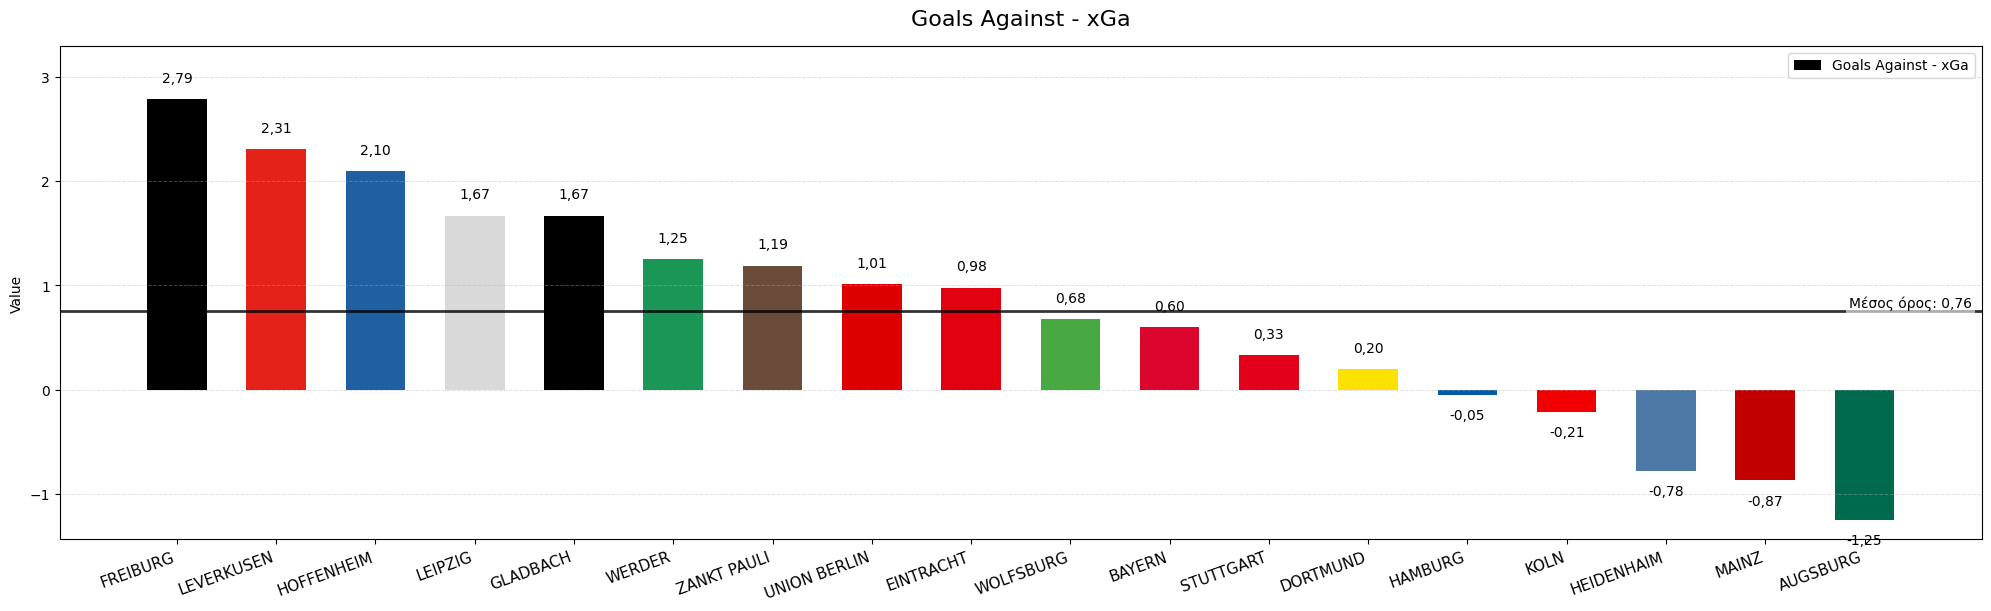

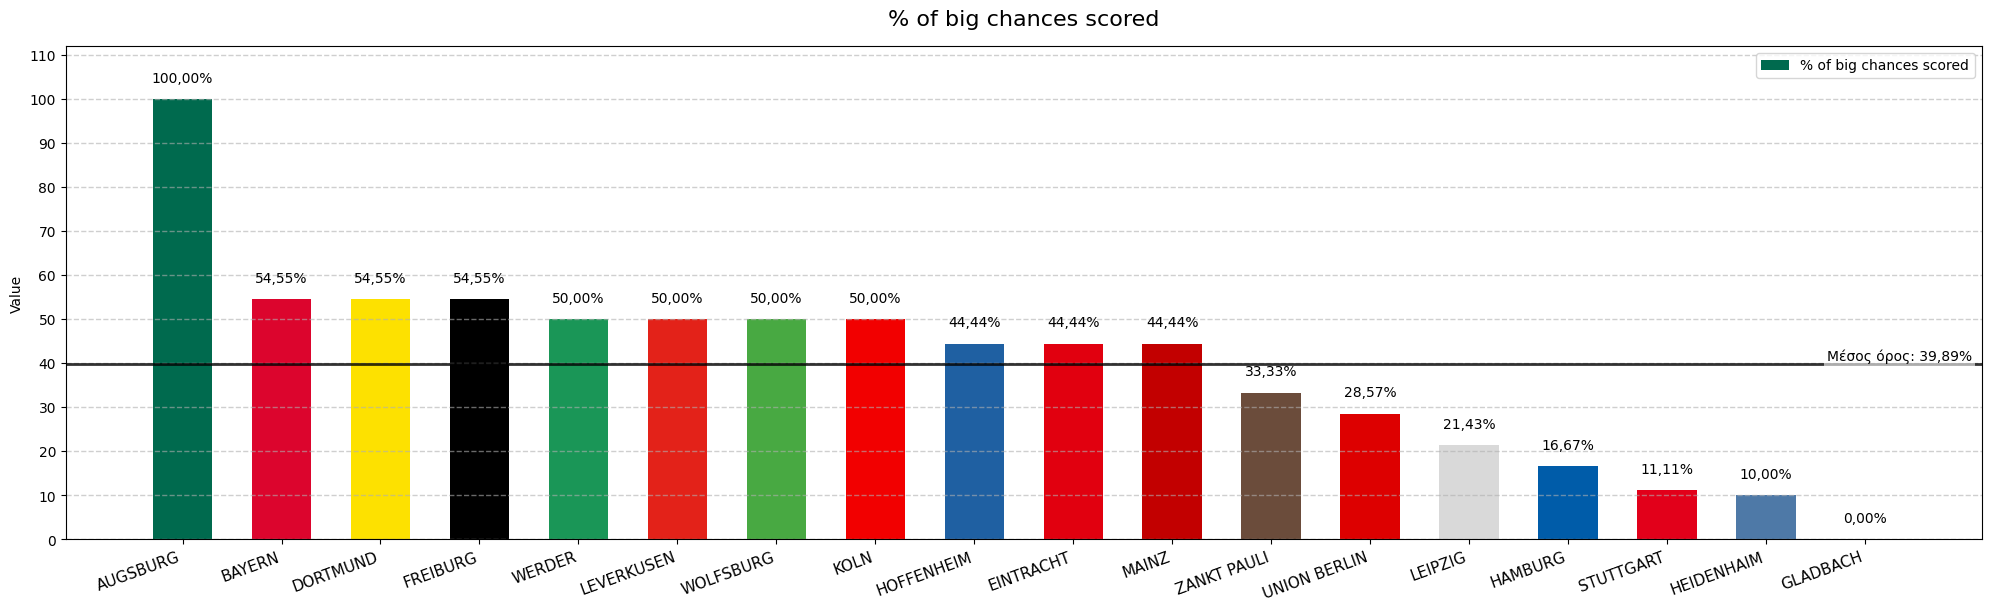

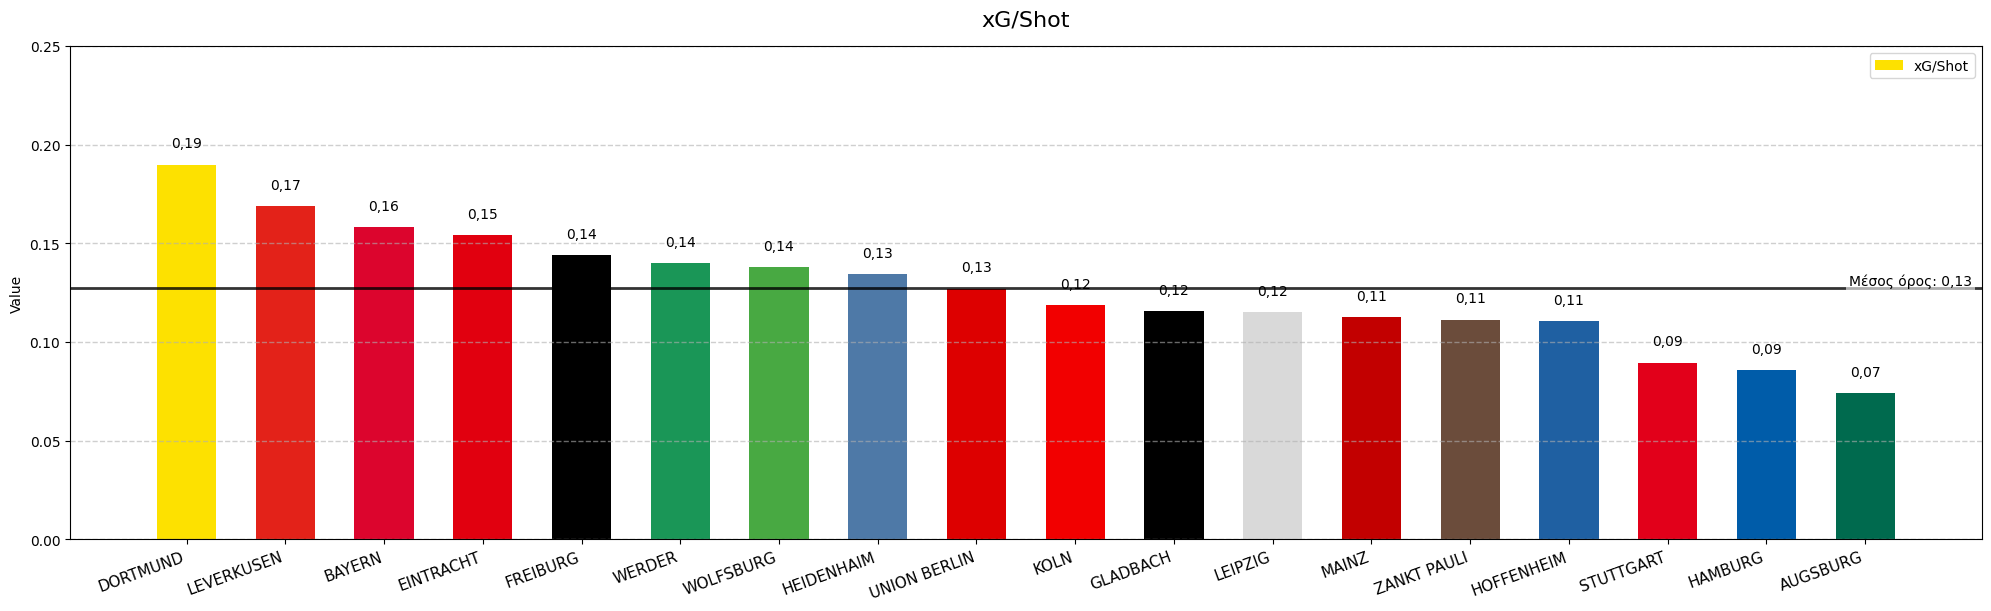

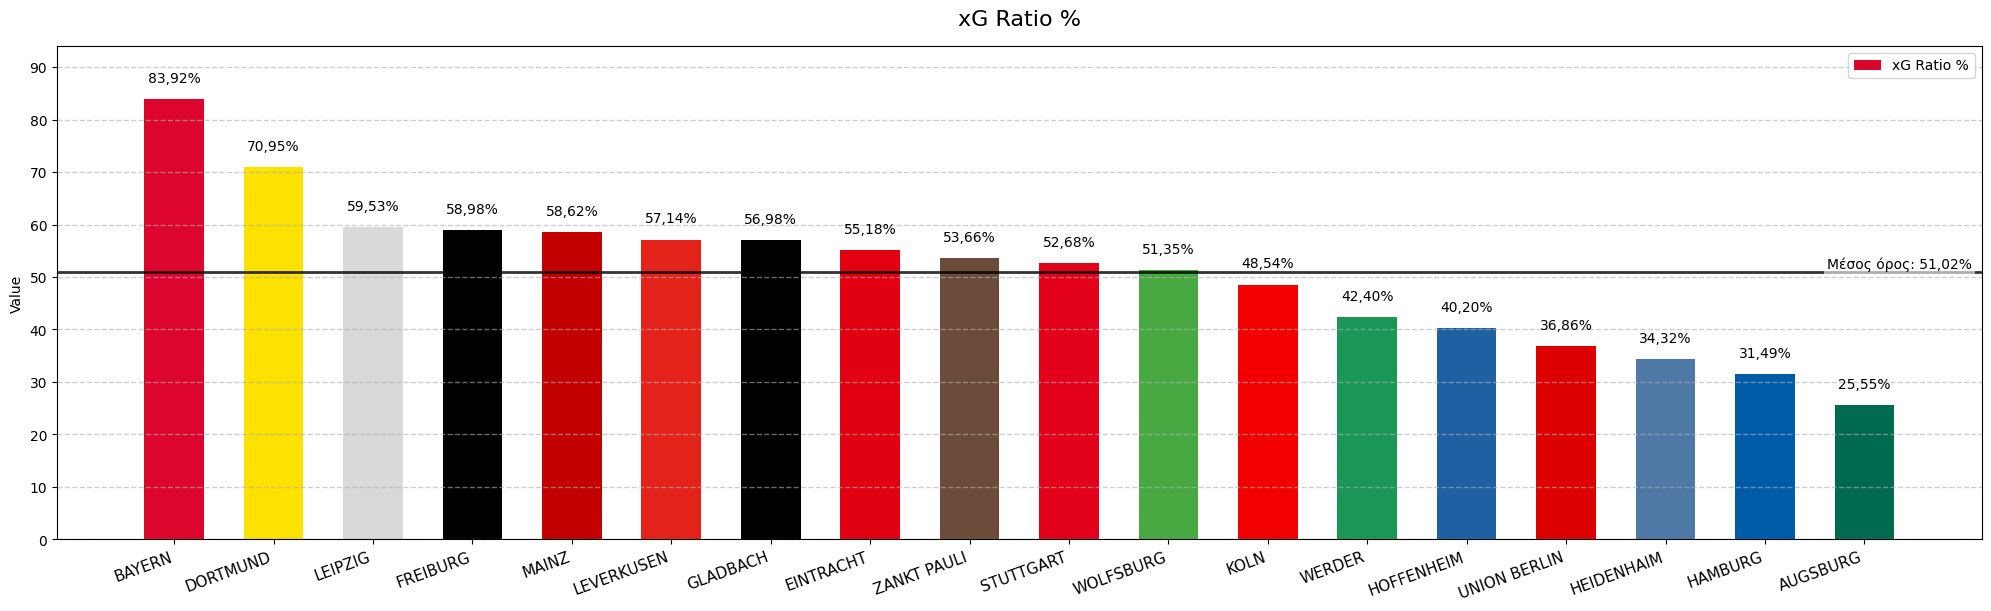

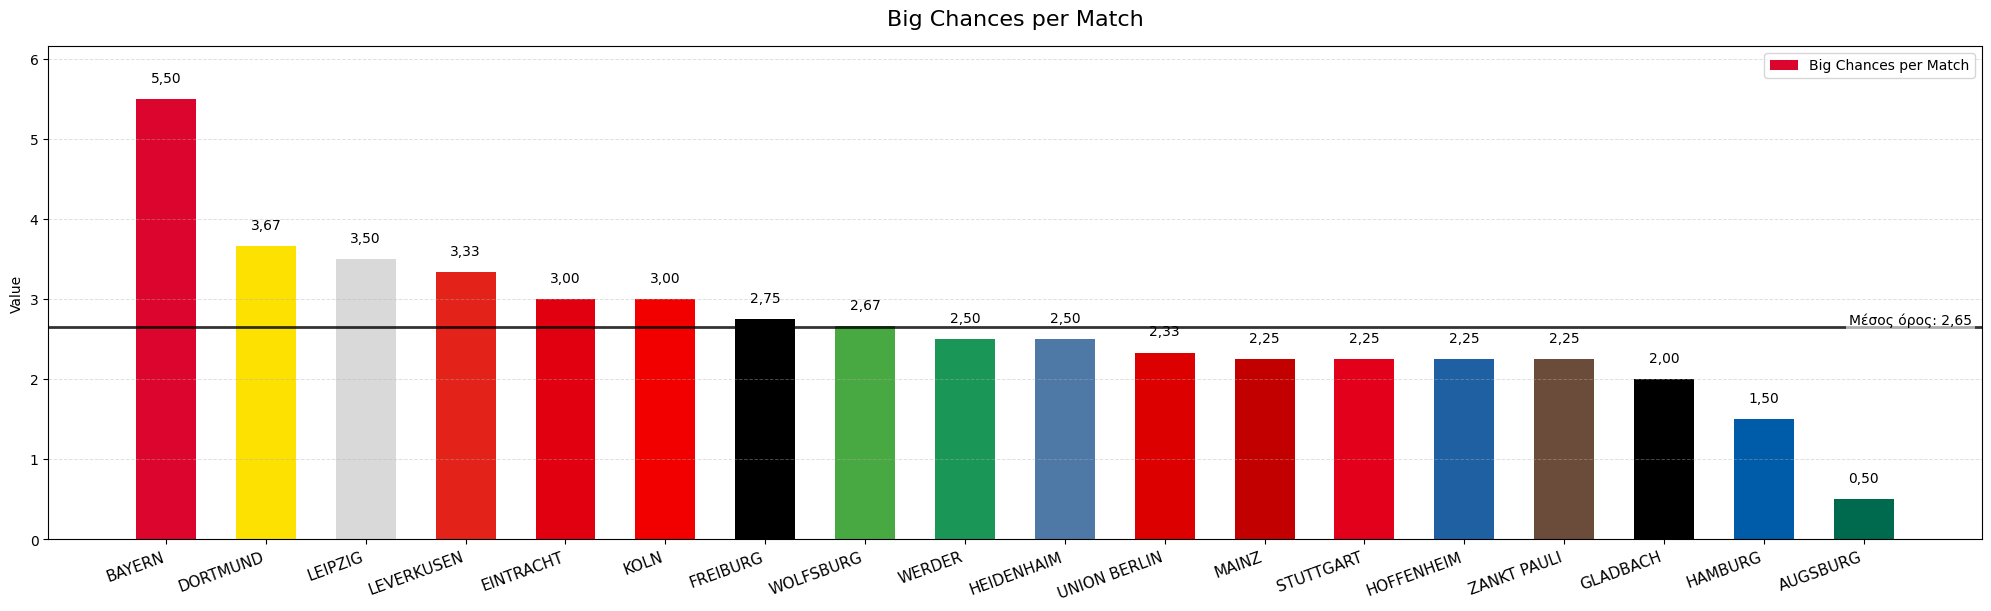

In [5]:
# ==== LIVE Google Sheet → Bundesliga plots (1 chart per figure + xG Ratio % + Big Chances/Match) ====
CSV_URL_BUNDESLIGA = "https://docs.google.com/spreadsheets/d/1ON5nh4xr1IH0oT5xvBmoPOOSqF7ig1m4owlYapeGafw/export?format=csv&gid=0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.errors import ParserError

# ---------- Helpers to load & clean ----------
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

def prepare_sheet(csv_url):
    tried = []
    for kwargs in ({},
                   {"sep": ";"},
                   {"sep": None, "engine": "python"}):
        try:
            df = pd.read_csv(csv_url, **kwargs)
            break
        except ParserError as e:
            tried.append((kwargs, str(e)))
            df = None
    if df is None:
        raise RuntimeError(f"Could not parse the sheet. Tried: {tried}")

    df = promote_first_row_to_header(df)
    raw_df = df.copy()

    metric_col = df.columns[0]
    df[metric_col] = df[metric_col].astype(str).str.strip()

    # numbers: drop %, replace comma decimal, coerce to float
    num_df = df.copy()
    for c in num_df.columns[1:]:
        col = (num_df[c].astype('string')
               .str.replace('%', '', regex=False)
               .str.replace('\u00a0', ' ', regex=False)
               .str.replace(',', '.', regex=False))
        num_df[c] = pd.to_numeric(col, errors='coerce')

    # optional 'Colors' row
    sheet_colors = None
    mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
    if mask.any():
        row = raw_df.loc[mask].iloc[0, 1:]
        if all(isinstance(x, str) and x.strip().startswith("#") for x in row):
            sheet_colors = row

    return {"num_df": num_df, "raw_df": raw_df, "metric_col": metric_col,
            "teams": list(num_df.columns[1:]), "sheet_colors": sheet_colors}

def get_metric_series(ctx, name: str) -> pd.Series:
    df = ctx["num_df"]; metric_col = ctx["metric_col"]
    target = name.strip().casefold()
    exact = df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return df.loc[exact].iloc[0, 1:]
    contains = df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return df.loc[contains].iloc[0, 1:]
    raise ValueError("Metric not found. Available:\n - " + "\n - ".join(df[metric_col].astype(str)))

# ---------- Bundesliga colors (fallback if no 'Colors' row) ----------
BUNDES_COLORS = {
    "BAYERN":        "#DC052D",
    "DORTMUND":      "#FDE100",
    "LEVERKUSEN":    "#E32219",
    "LEIPZIG":       "#D9D9D9",
    "EINTRACHT":     "#E1000F",     # Eintracht Frankfurt
    "WERDER":        "#1A9657",
    "FREIBURG":      "#000000",
    "STUTTGART":     "#E2001A",
    "HOFFENHEIM":    "#1F60A2",
    "GLADBACH":      "#000000",
    "WOLFSBURG":     "#48A942",
    "KOLN":          "#F20000",     # match your sheet spelling (no umlaut)
    "SANKT PAULI":   "#6B4C3B", "ZANKT PAULI": "#6B4C3B",  # both spellings
    "AUGSBURG":      "#006A4E",
    "UNION BERLIN":  "#DD0000",
    "MAINZ":         "#C20000",
    "HAMBURG":       "#005CA9",
    "HEIDENHEIM":    "#1F4E79", "HEIDENHAIN": "#1F4E79",
}

def team_color(team, ctx, fallback_map):
    sc = ctx["sheet_colors"]
    if sc is not None and team in sc and str(sc[team]).startswith("#"):
        return str(sc[team])
    return fallback_map.get(team, "#4e79a7")

# ---------- Plotters ----------
def plot_metric_bar(ctx, metric_name: str, assume_percent=False, fallback_colors=BUNDES_COLORS):
    s = get_metric_series(ctx, metric_name).astype(float).sort_values(ascending=False)

    name_ci   = metric_name.strip().casefold()
    is_shots  = (name_ci == "shots m.o.")
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=metric_name)

    ax.set_title(metric_name, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits (xG/Shot fixed 0..0.30)
    if is_xgshot:
        ax.set_ylim(0.0, 0.25)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if is_shots:
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif is_xgshot:
        ax.yaxis.set_major_locator(MultipleLocator(0.05))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line (no % for xG/Shot)
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = (
        f"{mean_val:.2f}".replace('.', ',') if is_xgshot
        else f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    )
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Value labels with a FIXED pixel offset (same visual height)
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val):
            continue
        label = (
            f"{val:.2f}".replace(".", ",") if is_xgshot
            else f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        )
        ax.annotate(
            label,
            xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
            xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
            textcoords='offset points',
            ha='center',
            va='bottom' if val >= 0 else 'top',
            fontsize=10,
            clip_on=False
        )

    plt.show()

def plot_custom_series(ctx, series: pd.Series, title: str, assume_percent=False,
                       fallback_colors=BUNDES_COLORS, special_ticks=None, fixed_ylim=None):
    s = pd.Series(series.values, index=series.index, dtype=float).sort_values(ascending=False)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)

    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    bars = ax.bar(s.index, s.values, width=0.6, color=colors, edgecolor="none", label=title)

    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits
    if fixed_ylim is not None:
        ax.set_ylim(*fixed_ylim)
    else:
        vmin = np.nanmin(s.values) if np.isfinite(np.nanmin(s.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s.values) - y_min))
        y_max = float(np.nanmax(s.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if special_ticks is not None:
        ax.yaxis.set_major_locator(MultipleLocator(special_ticks))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line
    mean_val = float(np.nanmean(s.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Labels (fixed pixel offset)
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s.values):
        if not np.isfinite(val): continue
        label = f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

    plt.show()

# ---------- Build context ----------
ctx_bundes = prepare_sheet(CSV_URL_BUNDESLIGA)

# ---------- Base plots ----------
METRICS_TO_PLOT_BUNDES = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),            # grid every 2
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),# % grid every 10
    ("xG/Shot", False),               # fixed 0..0.30, ticks 0.05, no %
]

for name, is_percent in METRICS_TO_PLOT_BUNDES:
    plot_metric_bar(ctx_bundes, name, assume_percent=is_percent, fallback_colors=BUNDES_COLORS)

# ---------- Extras to keep: xG Ratio % + Big Chances per Match ----------
xg  = get_metric_series(ctx_bundes, "xGoals M.O.")
xga = get_metric_series(ctx_bundes, "xGoalsAgainst M.O.")
xg_ratio_pct = (xg / (xg + xga).replace(0, np.nan)) * 100
plot_custom_series(ctx_bundes, xg_ratio_pct, "xG Ratio %", assume_percent=True, fallback_colors=BUNDES_COLORS)

matches = get_metric_series(ctx_bundes, "Match Played")
big_chances = get_metric_series(ctx_bundes, "Big Chances")
bc_per_match = big_chances / matches.replace(0, np.nan)
plot_custom_series(ctx_bundes, bc_per_match, "Big Chances per Match", assume_percent=False, fallback_colors=BUNDES_COLORS)


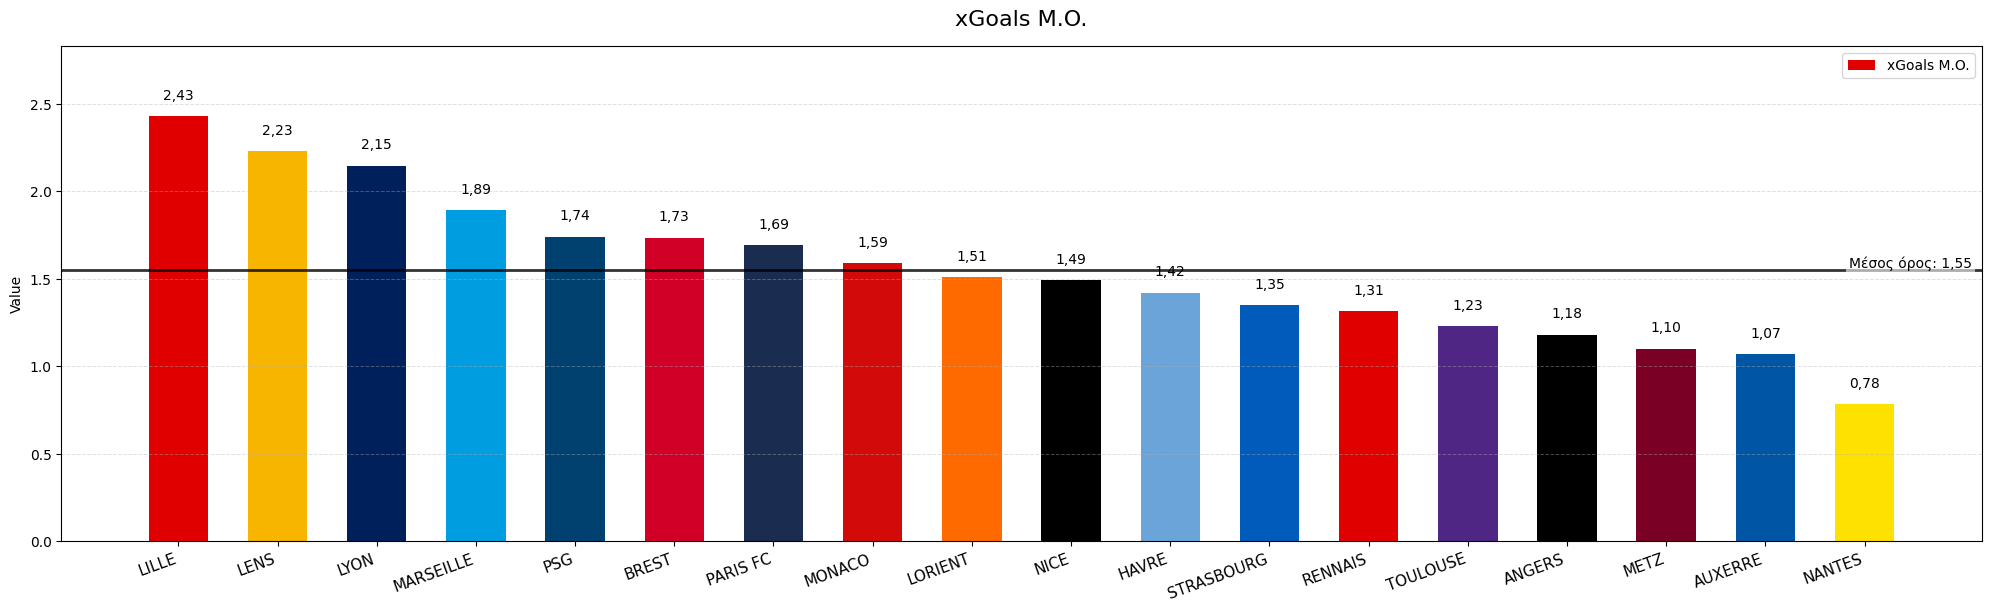

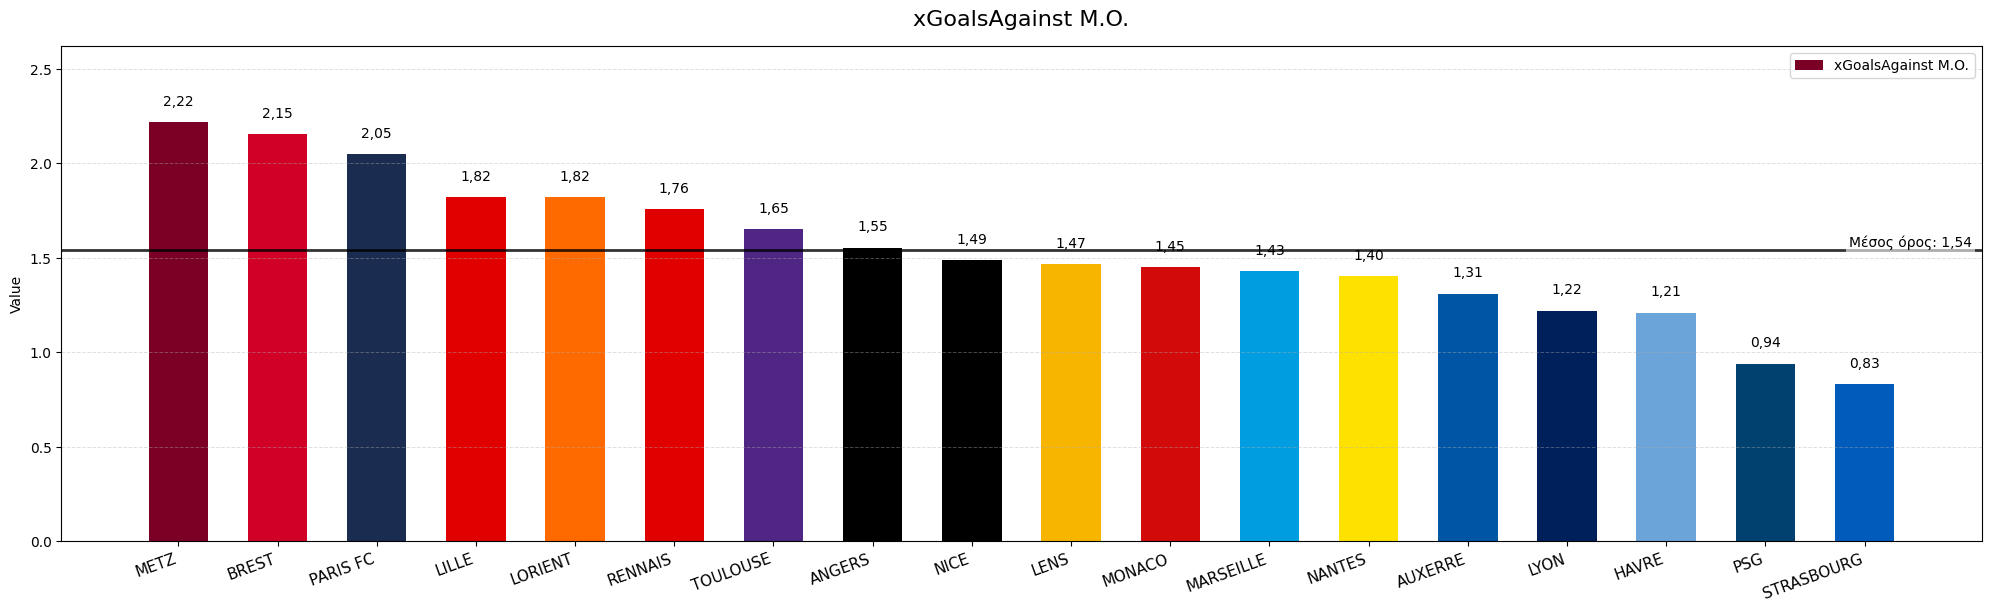

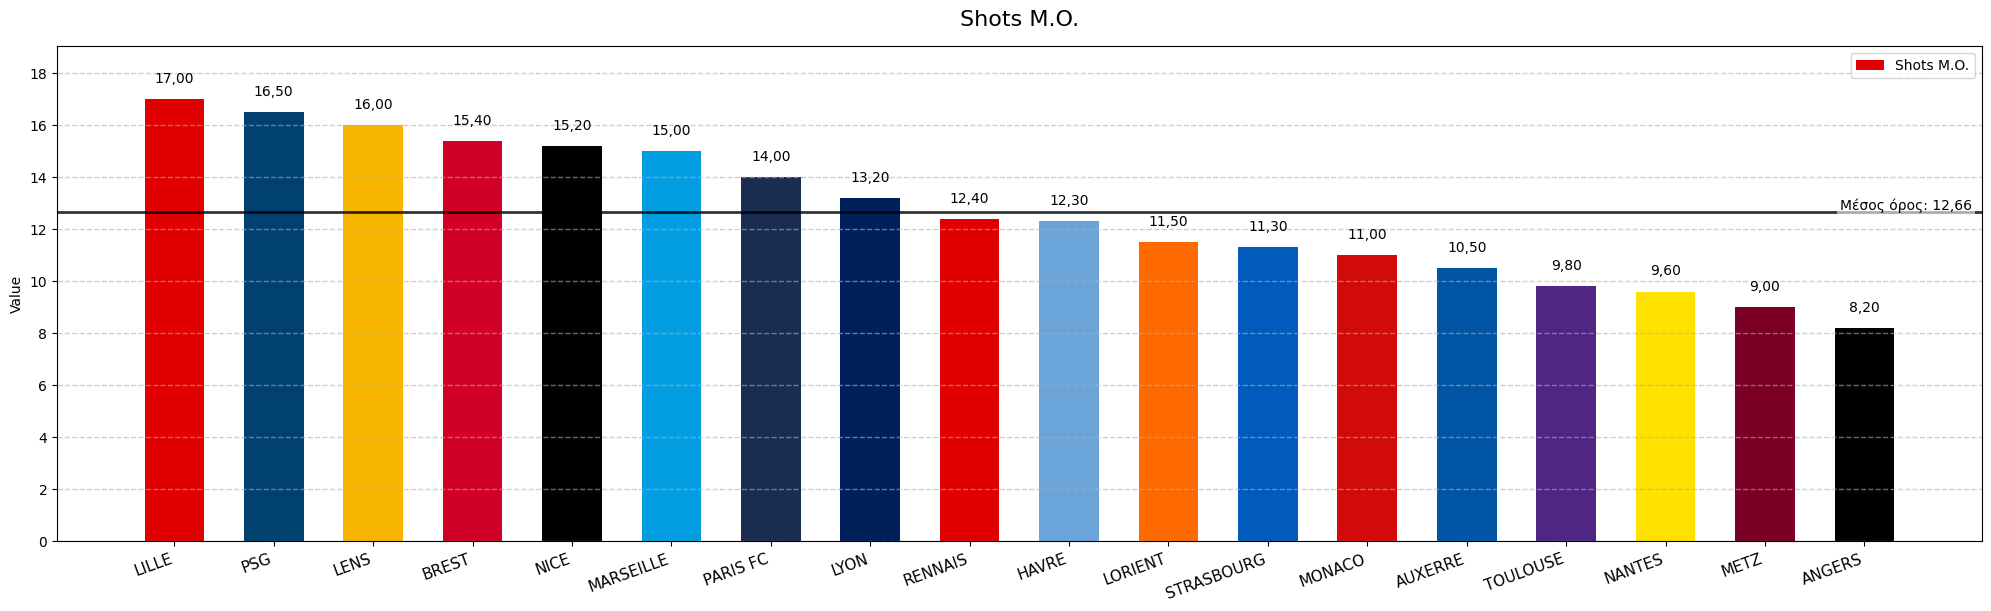

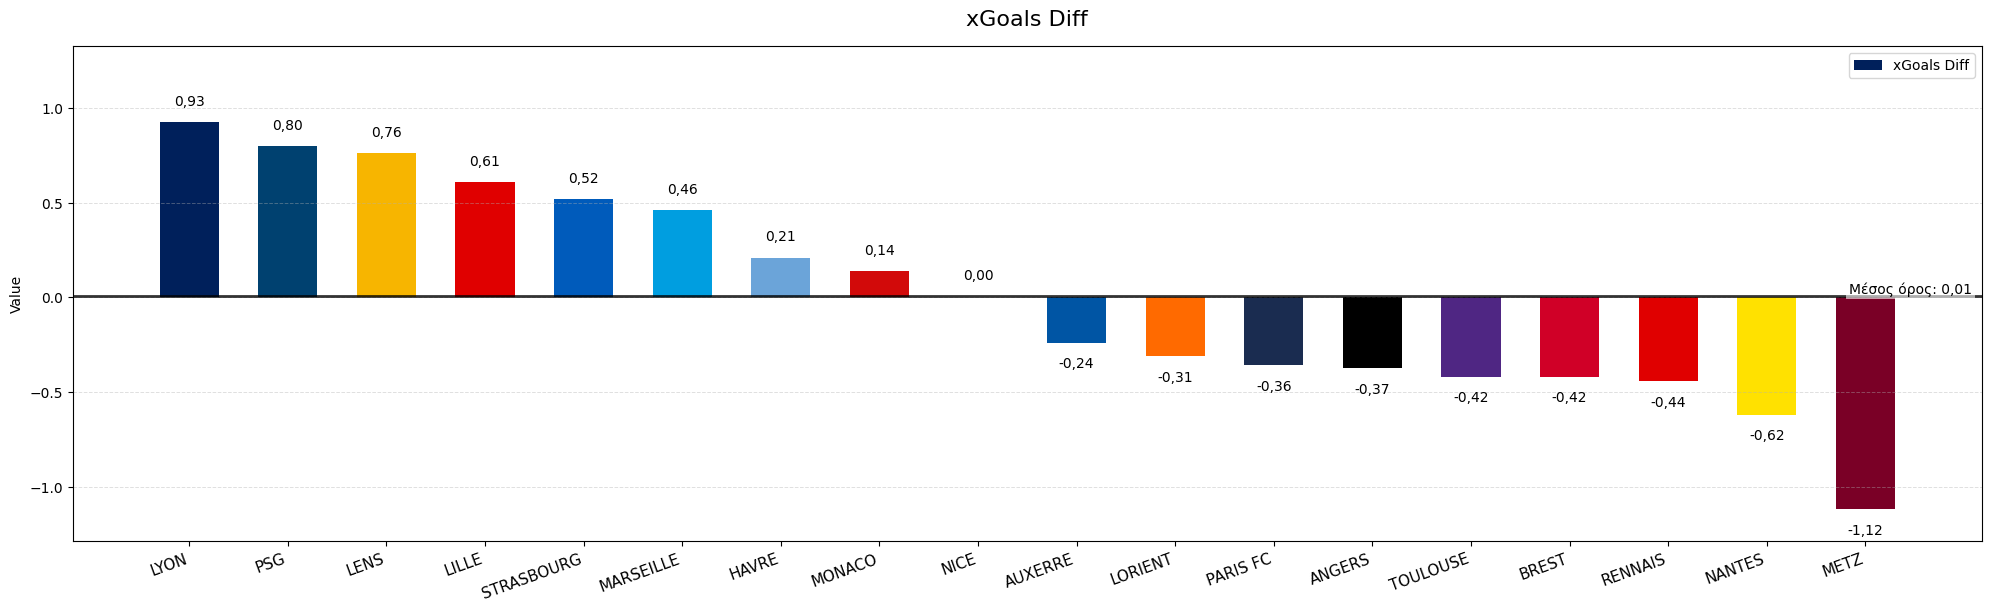

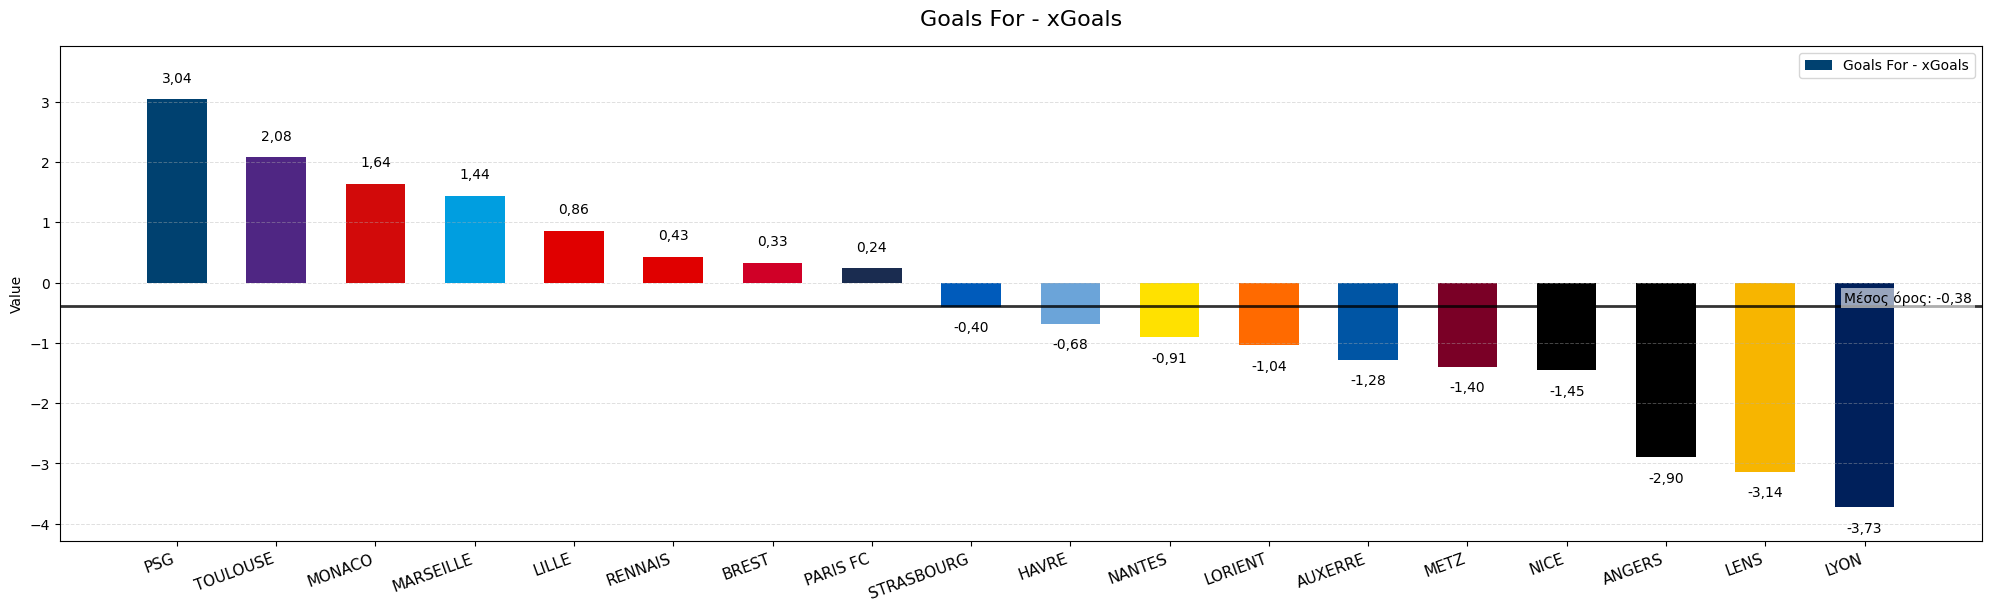

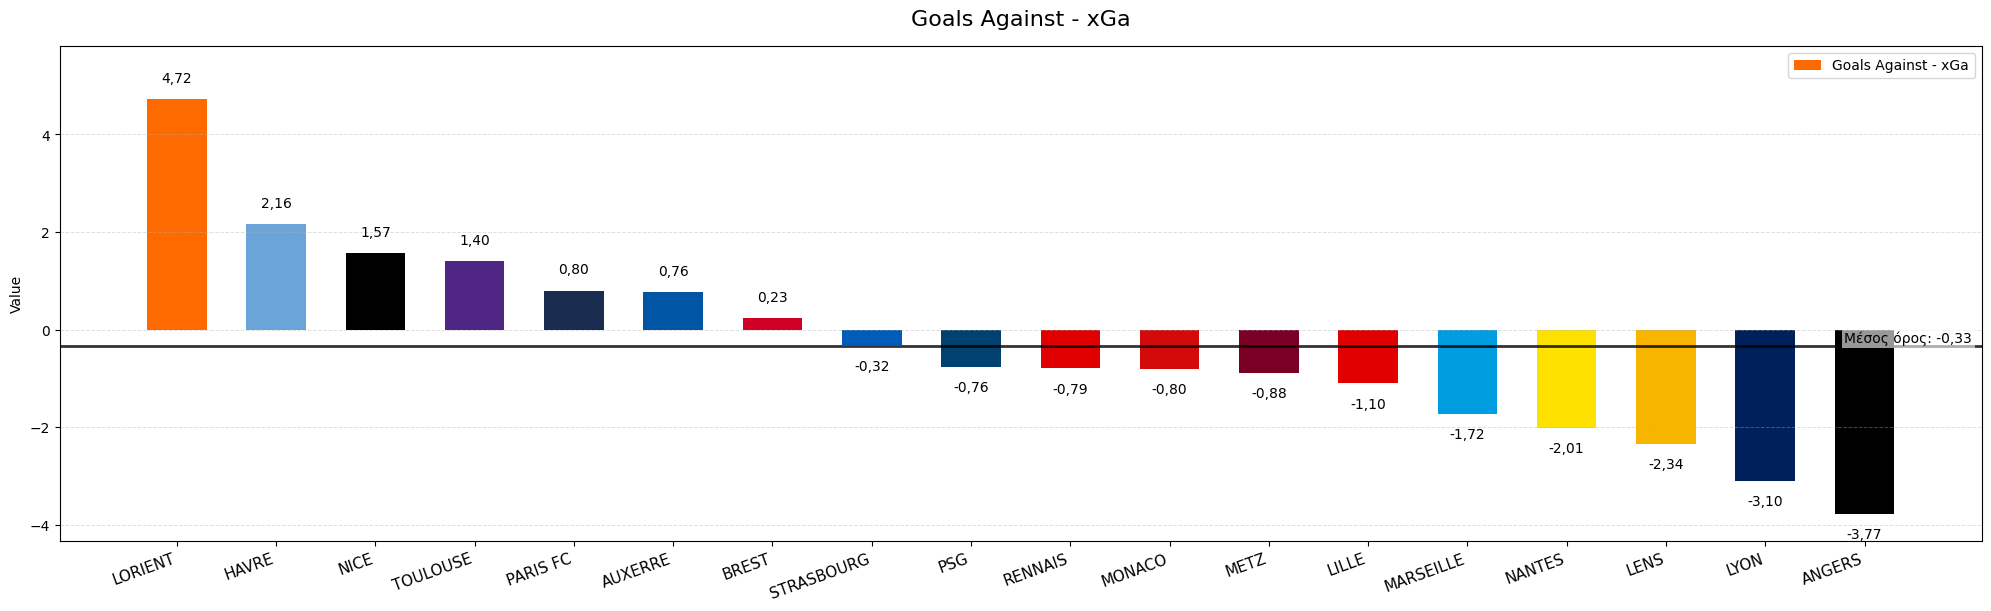

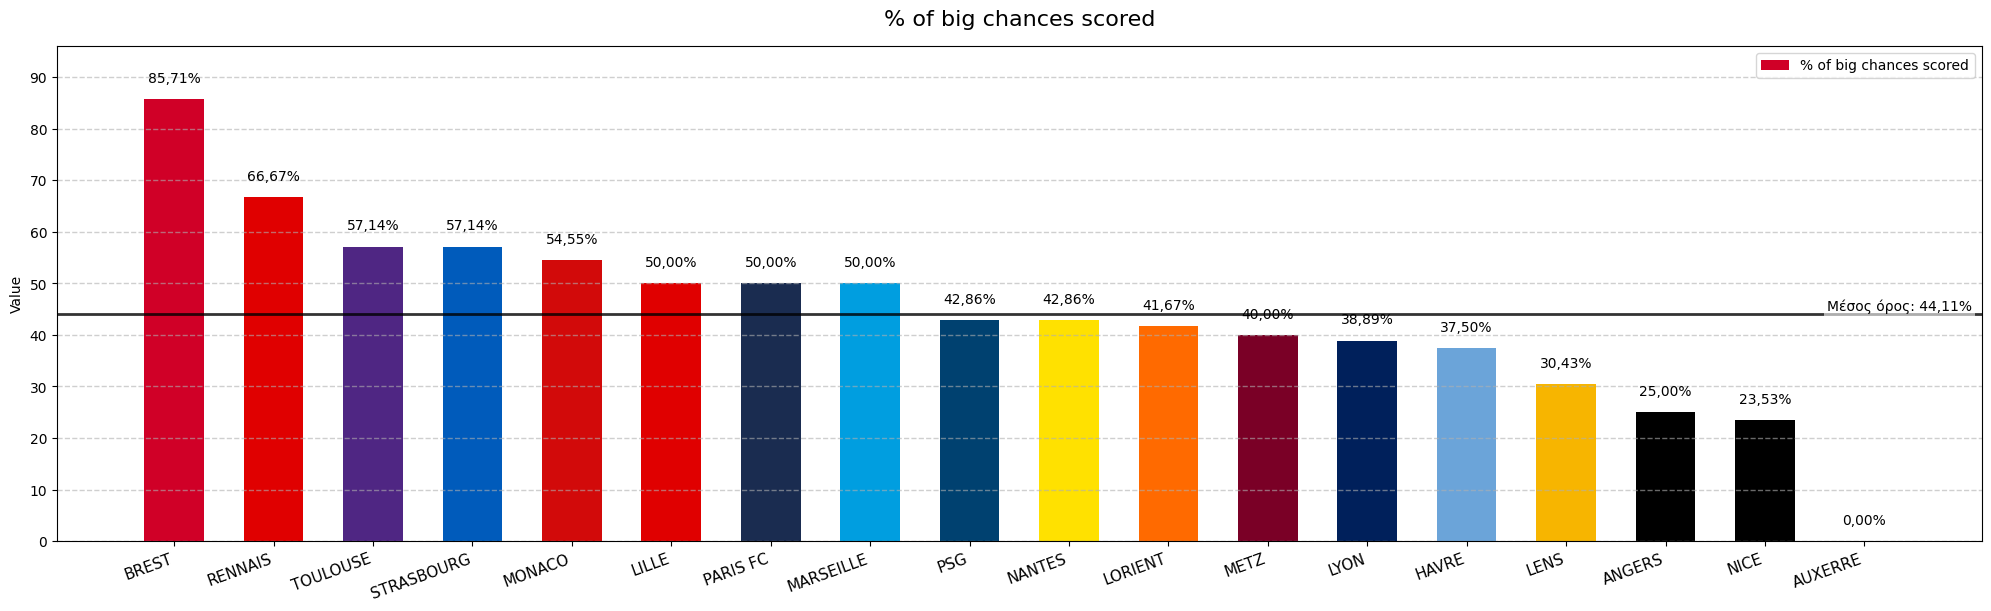

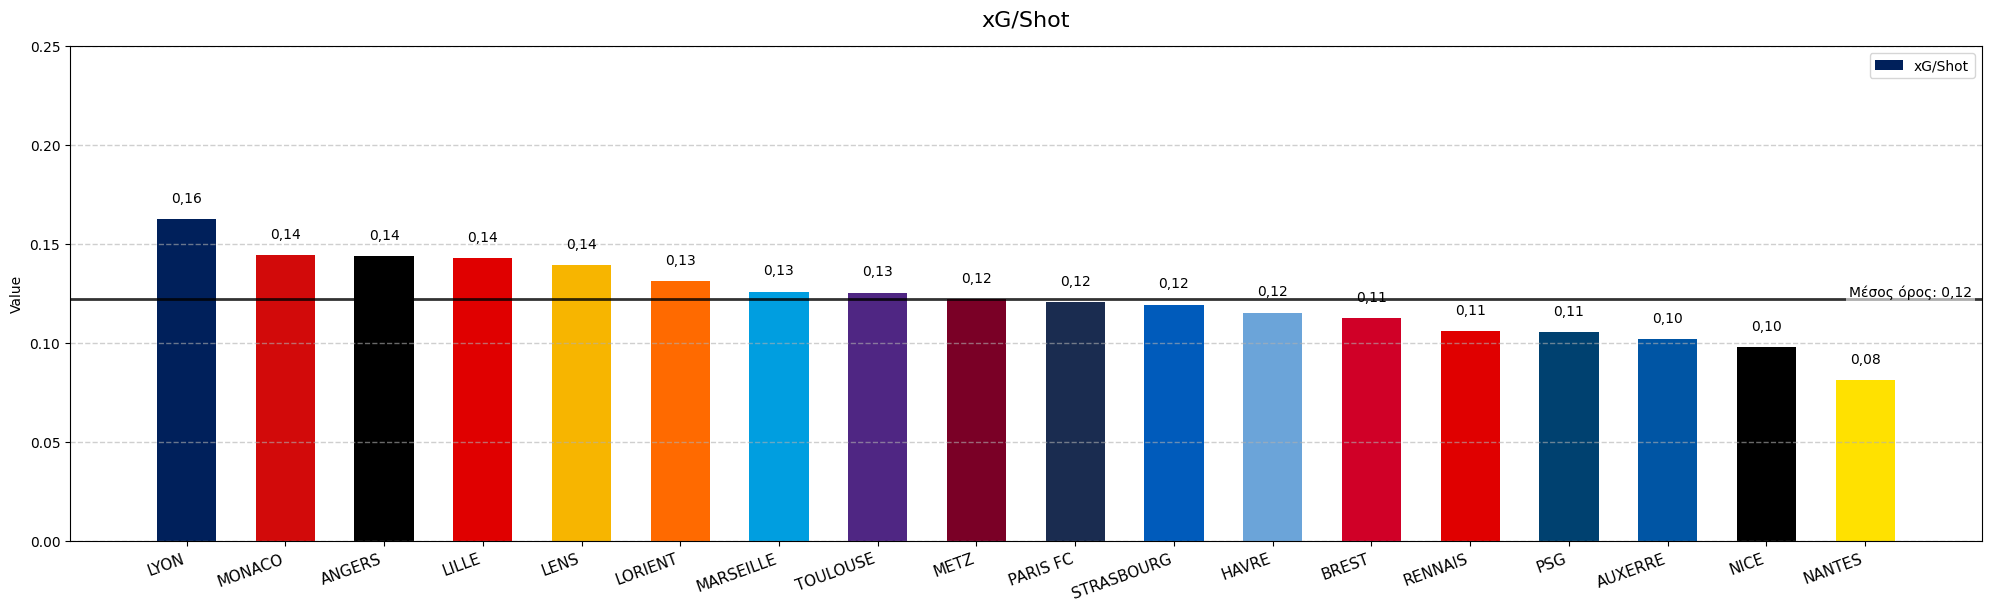

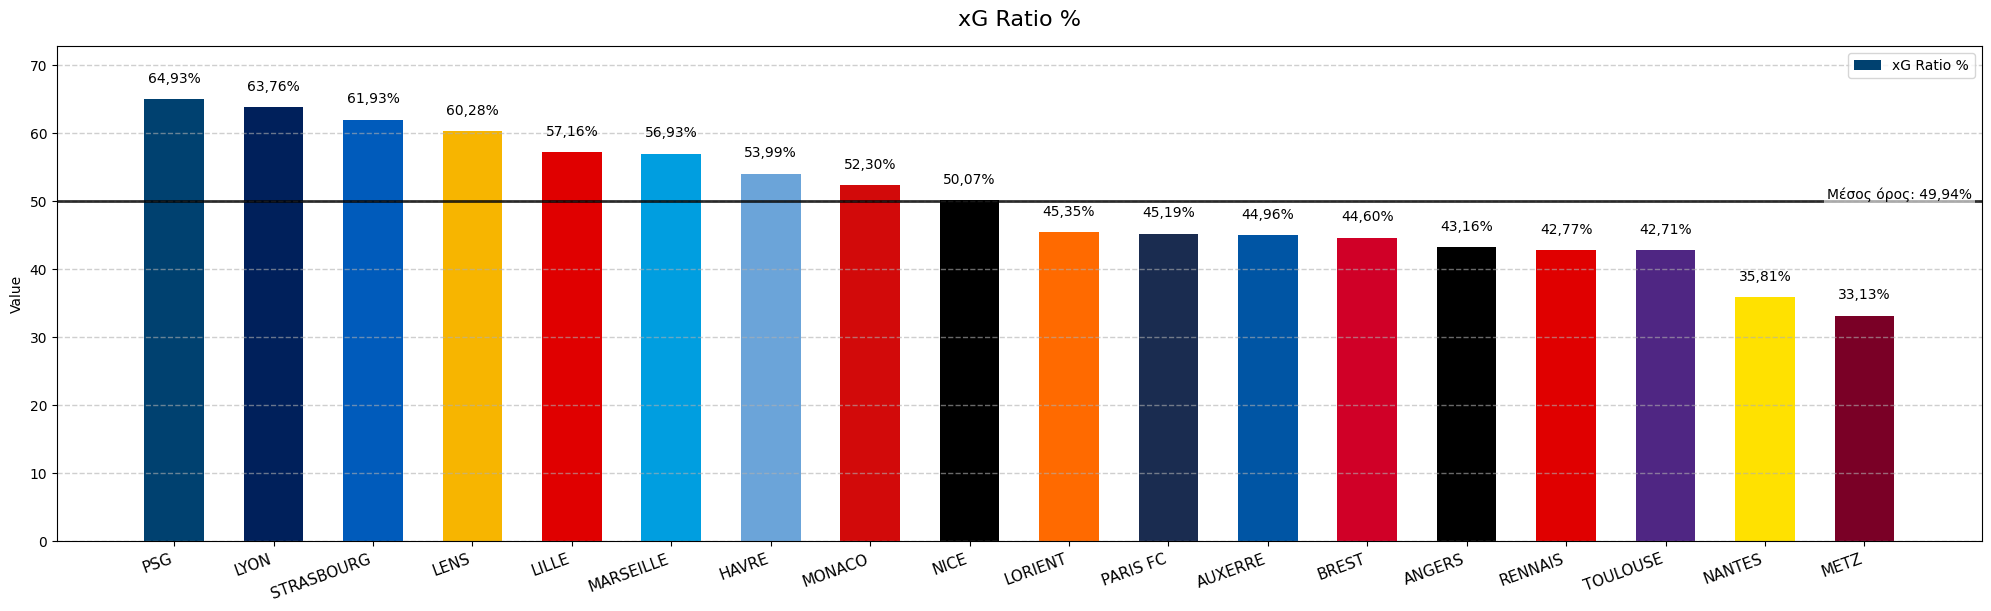

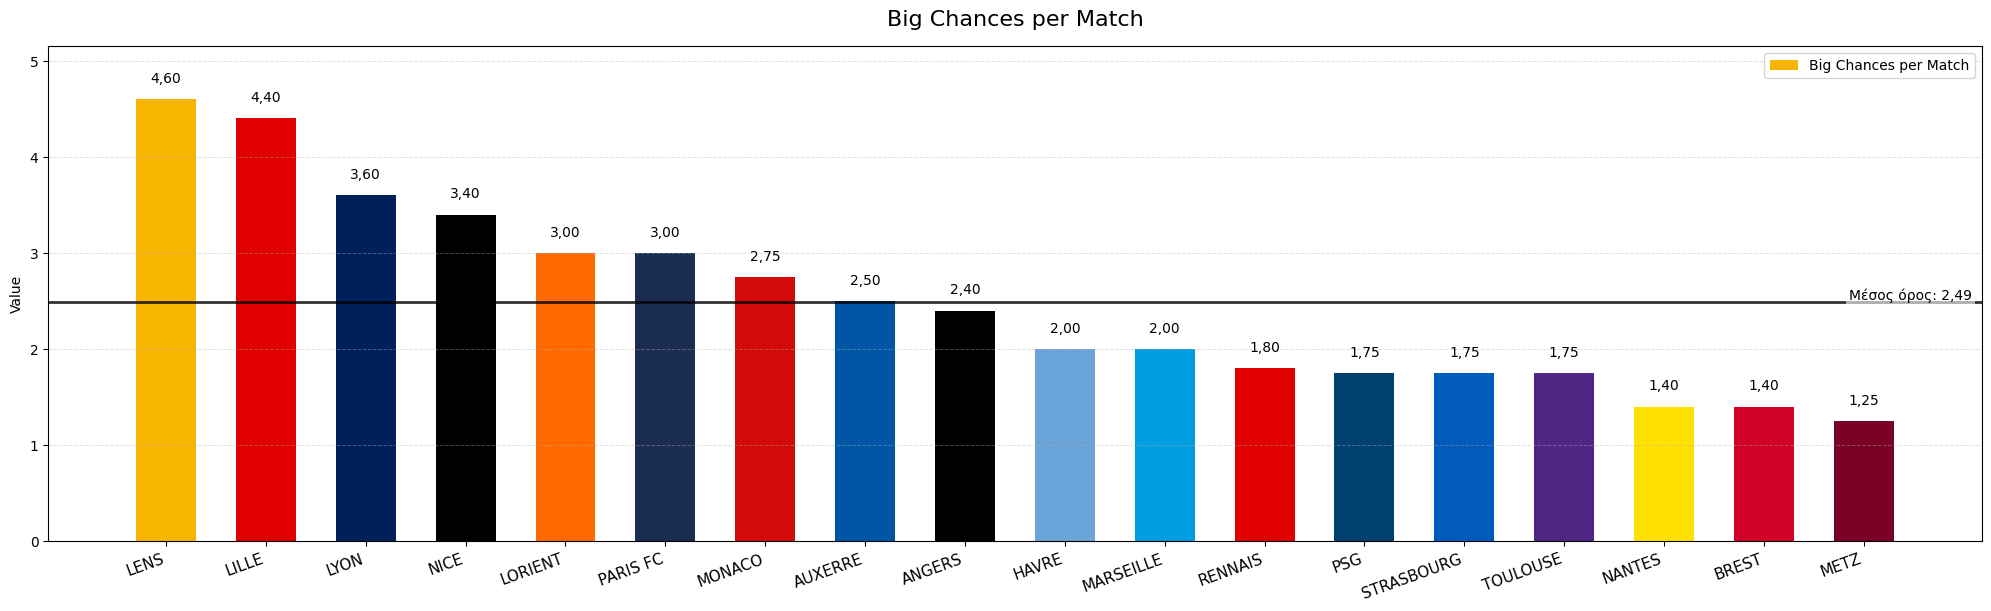

In [6]:
# ==== LIVE Google Sheet → Ligue 1 plots (1 chart per figure + xG Ratio %) ====
CSV_URL_LIGUE1 = "https://docs.google.com/spreadsheets/d/1C5944ZiAPxH-qdPK82tTRqTz_e5zm6_V1Z9y6LTfLOc/export?format=csv&gid=0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.errors import ParserError

# ---------- Load & clean ----------
def promote_first_row_to_header(df):
    if any(str(c).startswith("Unnamed") for c in df.columns[1:]):
        new_header = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df.columns = [df.columns[0]] + list(new_header.iloc[1:])
    return df

def prepare_sheet(csv_url):
    tried = []
    for kwargs in ({},
                   {"sep": ";"},
                   {"sep": None, "engine": "python"}):
        try:
            df = pd.read_csv(csv_url, **kwargs)
            break
        except ParserError as e:
            tried.append((kwargs, str(e)))
            df = None
    if df is None:
        raise RuntimeError(f"Could not parse the sheet. Tried: {tried}")

    df = promote_first_row_to_header(df)
    raw_df = df.copy()

    metric_col = df.columns[0]
    df[metric_col] = df[metric_col].astype(str).str.strip()

    # Normalize numbers
    num_df = df.copy()
    for c in num_df.columns[1:]:
        col = (num_df[c].astype('string')
               .str.replace('%', '', regex=False)
               .str.replace('\u00a0', ' ', regex=False)
               .str.replace(',', '.', regex=False))
        num_df[c] = pd.to_numeric(col, errors='coerce')

    # Optional 'Colors' row
    sheet_colors = None
    mask = raw_df[metric_col].astype(str).str.strip().str.casefold() == "colors"
    if mask.any():
        row = raw_df.loc[mask].iloc[0, 1:]
        if all(isinstance(x, str) and x.strip().startswith("#") for x in row):
            sheet_colors = row

    return {"num_df": num_df, "raw_df": raw_df, "metric_col": metric_col,
            "teams": list(num_df.columns[1:]), "sheet_colors": sheet_colors}

def get_metric_series(ctx, name: str) -> pd.Series:
    df = ctx["num_df"]; metric_col = ctx["metric_col"]
    target = name.strip().casefold()
    exact = df[metric_col].astype(str).str.strip().str.casefold() == target
    if exact.any():
        return df.loc[exact].iloc[0, 1:]
    contains = df[metric_col].astype(str).str.casefold().str.contains(target)
    if contains.any():
        return df.loc[contains].iloc[0, 1:]
    raise ValueError("Metric not found. Available:\n - " + "\n - ".join(df[metric_col].astype(str)))

# ---------- Colors (fallback if no 'Colors' row) ----------
LIGUE1_COLORS = {
    "PSG": "#004170",
    "LILLE": "#E00000",
    "MONACO": "#D20A0A",
    "LYON": "#00205B",
    "MARSEILLE": "#009EE0", "MARSELLE": "#009EE0",
    "NICE": "#000000",
    "STRASBOURG": "#005BBB",
    "LENS": "#F7B500",
    "RENNES": "#E00000", "RENNAIS": "#E00000",
    "TOULOUSE": "#4F2683",
    "NANTES": "#FFE100",
    "PARIS FC": "#1A2C50",
    "ANGERS": "#000000",
    "LE HAVRE": "#6BA4D9", "HAVRE": "#6BA4D9",
    "AUXERRE": "#0055A4",
    "LORIENT": "#FF6A00",
    "BREST": "#D00027",
    "METZ": "#7A0026",
}

def team_color(team, ctx, fallback_map):
    sc = ctx["sheet_colors"]
    if sc is not None and team in sc and str(sc[team]).startswith("#"):
        return str(sc[team])
    return fallback_map.get(team, "#4e79a7")

# ---------- Plot helpers ----------
def _plot_core(ax, s_sorted, colors, title, assume_percent, is_xgshot, special_ticks=None, fixed_ylim=None):
    bars = ax.bar(s_sorted.index, s_sorted.values, width=0.6, color=colors, edgecolor="none", label=title)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel("Value")

    # Y limits
    if fixed_ylim is not None:
        ax.set_ylim(*fixed_ylim)
    else:
        vmin = np.nanmin(s_sorted.values) if np.isfinite(np.nanmin(s_sorted.values)) else 0.0
        y_min = min(0, vmin - abs(vmin)*0.15)
        y_range = max(1e-6, float(np.nanmax(s_sorted.values) - y_min))
        y_max = float(np.nanmax(s_sorted.values)) + max(0.12*y_range, 0.4)
        ax.set_ylim(bottom=y_min, top=y_max)

    # Gridlines
    if special_ticks is not None:
        ax.yaxis.set_major_locator(MultipleLocator(special_ticks))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif assume_percent:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    elif is_xgshot:
        ax.yaxis.set_major_locator(MultipleLocator(0.05))
        ax.grid(axis='y', which='major', linestyle='--', linewidth=1, alpha=0.6)
    else:
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.4)

    ax.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=20, ha="right", fontsize=11)

    # Mean line
    mean_val = float(np.nanmean(s_sorted.values))
    ax.axhline(mean_val, linestyle='-', linewidth=2, color='k', alpha=0.8)
    mean_label = f"{mean_val:.2f}".replace('.', ',') + ("%" if assume_percent else "")
    ax.text(0.995, mean_val, f"Μέσος όρος: {mean_label}",
            ha='right', va='bottom', fontsize=10,
            transform=ax.get_yaxis_transform(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))

    # Fixed pixel offset labels
    LABEL_PAD_PT = 10
    for rect, val in zip(bars, s_sorted.values):
        if not np.isfinite(val): continue
        label = f"{val:.2f}".replace(".", ",") + ("%" if assume_percent else "")
        ax.annotate(label,
                    xy=(rect.get_x()+rect.get_width()/2, rect.get_height()),
                    xytext=(0, LABEL_PAD_PT if val >= 0 else -LABEL_PAD_PT),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if val >= 0 else 'top',
                    fontsize=10, clip_on=False)

def plot_metric_bar(ctx, metric_name: str, assume_percent=False, fallback_colors=LIGUE1_COLORS):
    s = get_metric_series(ctx, metric_name).astype(float).sort_values(ascending=False)
    name_ci = metric_name.strip().casefold()
    is_shots  = (name_ci == "shots m.o.")
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)

    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)
    colors = [team_color(t, ctx, fallback_colors) for t in s.index]

    special_ticks = 2 if is_shots else (0.05 if is_xgshot else None)
    fixed_ylim    = (0.0, 0.25) if is_xgshot else None

    _plot_core(ax, s, colors, metric_name, assume_percent, is_xgshot, special_ticks, fixed_ylim)
    plt.show()

def plot_custom_series(ctx, series: pd.Series, title: str, assume_percent=False,
                       fallback_colors=LIGUE1_COLORS, special_ticks=None, fixed_ylim=None):
    s = pd.Series(series.values, index=series.index, dtype=float).sort_values(ascending=False)
    name_ci = title.strip().casefold()
    is_xgshot = ("xg/shot" in name_ci) or ("xgshot" in name_ci)
    fig_width = max(18, len(s.index) * 1.1)
    fig, ax = plt.subplots(figsize=(fig_width, 6), constrained_layout=True)
    colors = [team_color(t, ctx, fallback_colors) for t in s.index]
    _plot_core(ax, s, colors, title, assume_percent, is_xgshot, special_ticks, fixed_ylim)
    plt.show()

# ---------- Build context ----------
ctx_l1 = prepare_sheet(CSV_URL_LIGUE1)

# ---------- Base plots (one figure each) ----------
BASE_METRICS = [
    ("xGoals M.O.", False),
    ("xGoalsAgainst M.O.", False),
    ("Shots M.O.", False),          # grid every 2
    ("xGoals Diff", False),
    ("Goals For - xGoals", False),
    ("Goals Against - xGa", False),
    ("% of big chances scored", True),
    ("xG/Shot", False),             # fixed 0..0.30, ticks 0.05
]

for name, is_percent in BASE_METRICS:
    plot_metric_bar(ctx_l1, name, assume_percent=is_percent, fallback_colors=LIGUE1_COLORS)

# ---------- Keep ONLY xG Ratio % as the extra derived chart ----------
xg  = get_metric_series(ctx_l1, "xGoals M.O.")
xga = get_metric_series(ctx_l1, "xGoalsAgainst M.O.")
xg_ratio_pct = (xg / (xg + xga).replace(0, np.nan)) * 100
plot_custom_series(ctx_l1, xg_ratio_pct, "xG Ratio %", assume_percent=True, fallback_colors=LIGUE1_COLORS)

# ---------- Big Chances per Match (extra chart) ----------
matches = get_metric_series(ctx_l1, "Match Played")
big_chances = get_metric_series(ctx_l1, "Big Chances")

# avoid divide-by-zero
bc_per_match = big_chances / matches.replace(0, np.nan)

plot_custom_series(
    ctx_l1,
    bc_per_match,
    "Big Chances per Match",
    assume_percent=False,
    fallback_colors=LIGUE1_COLORS
)

